In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

In [27]:
assert torch.cuda.is_available()
device = torch.device("cuda")

In [84]:
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

class Permute(nn.Module):
  def forward(self, img):
    return to_tensor(img).permute([1, 2, 0])

def expand_bits(x):
  return 1 & (x.unsqueeze(-1) >> torch.arange(7, -1, -1))

class ToBits(nn.Module):
  def forward(self, x):
    x = torch.clamp((x * 256).int(), 0, 255)
    x = expand_bits(x).flatten()
    return F.one_hot(x, 2)

class ToBytes(nn.Module):
  def forward(self, x):
    x = torch.clamp((x * 256).long(), 0, 255)
    x = x.flatten()
    return F.one_hot(x, 256)

batch_size = 64
transform = transforms.Compose([Permute(), ToBytes()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [116]:
class Raster(nn.Module):
  def __init__(self, input_dim=256, hidden_dim=256, d_head=16, n_head=8, output_dim=256, n_layers=6):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.n_layers = n_layers
    if input_dim != hidden_dim:
      self.fc_in = nn.Linear(input_dim, hidden_dim)
    else:
      self.fc_in = nn.Identity()
    if hidden_dim != output_dim:
      self.fc_out = nn.Linear(hidden_dim, output_dim)
    else:
      self.fc_out = nn.Identity()
    self.layers = nn.ModuleList([
        nn.TransformerEncoderLayer(d_model=hidden_dim, dim_feedforward=d_head*n_head, nhead=n_head, batch_first=True, activation=nn.ELU())
        for i in range(n_layers)
    ])

  def forward(self, x):
    x = self.fc_in(x)
    
    mask = torch.tril(torch.ones((x.shape[1], x.shape[1]), device=device))
    for layer in self.layers:
      x = x + layer(x, src_mask=mask)
    x = self.fc_out(x)
    return x


In [178]:
def train_raster(raster, optim, epochs=10, beta=16):
  raster.train()

  for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (img, labels) in enumerate(pbar):
      img = img.float().to(device)

      with torch.no_grad():
        color = torch.argmax(img, dim=-1).unsqueeze(-1).float() / 255
        error = (torch.arange(256, device=device).float() / 255 - color)**2
        target = torch.softmax(-beta * error, dim=-1)

      optim.zero_grad()
      p = raster(img)
      loss = F.cross_entropy(p[:, :-1], target[:, 1:])
      loss.backward()
      optim.step()

      total_loss += loss.item()
      if batch_idx % 1 == 0:
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(target), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), total_loss / (1 + batch_idx)))


In [181]:
raster = Raster(n_layers=3).to(device)
optim = torch.optim.Adam(raster.parameters(), lr=1e-3)
train_raster(raster, optim, 10, beta=16)

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

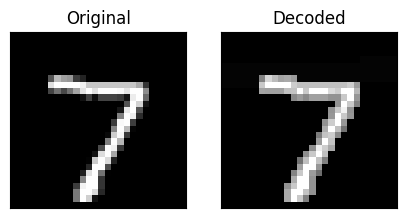

In [177]:
with torch.no_grad():
  x = test_data[0][0]
  # x = next(iter(train_loader))[0][0].float()
  y = raster(x.unsqueeze(0).float().to(device))[0]

  pred = F.softmax(y, dim=-1).float().reshape(28, 28, 256) @ (torch.arange(256, device=device).float())
  # pred = torch.argmax(y, dim=-1).reshape(28, 28)
  pred = pred.int().cpu()

  img = x.argmax(dim=-1).reshape(28, 28)

  fig, ax = plt.subplots(1, 2, figsize=(5, 10))
  ax[0].set_title("Original")
  ax[1].set_title("Decoded")
  ax[0].imshow(img, cmap="gray")
  ax[1].imshow(pred, cmap="gray")
  ax[0].get_xaxis().set_visible(False)
  ax[1].get_xaxis().set_visible(False)
  ax[0].get_yaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.show()

In [138]:
def sample(raster, beta=0.3):
  x = torch.zeros((1, 1, 256), device=device, dtype=torch.float32)
  bits = [0]
  with torch.no_grad():
    pbar = tqdm(range(783))
    for i in pbar:
      y = raster(x)
      p = torch.softmax(beta * y[0, -1], -1)
      idx = torch.multinomial(p, 1)
      bits.append(idx.item())
      x = torch.cat((x, F.one_hot(idx, 256).unsqueeze(0).float()), dim=1)
  return bits

In [139]:
s = sample(raster, beta=2)

  0%|          | 0/783 [00:00<?, ?it/s]

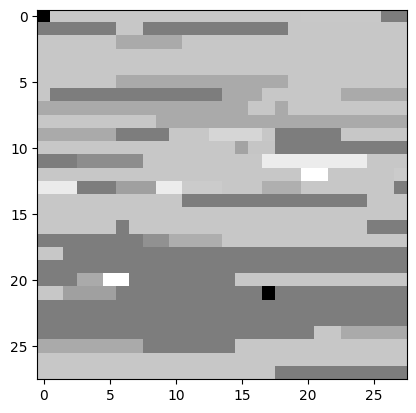

In [140]:
plt.imshow(np.array(s).reshape(28, 28), cmap="gray")

In [171]:
def arithmetic_encoding(img, raster, quality=1):
  """
  Arithmetic encoding using a raster-wise predictor network.

  img - the image you want to encode (obviously),
  raster - the next-pixel predictor,
  quality - ratio of bits to squared loss that is acceptable.
  """

  raster.eval()
  img = img.to(device)
  x = img[0].unsqueeze(0).unsqueeze(0).float()
  encoding = [img[0].argmax().item()]
  code_length = 0
  with torch.no_grad():
    pbar = tqdm(range(1, 784))
    for i in pbar:
      y = raster(x)
      logits = y[0, -1]

      correct_pixel = torch.argmax(img[i]).float() / 255
      error = (torch.arange(256, device=device).float() / 255 - correct_pixel)**2

      p = torch.softmax(logits, dim=-1)
      bits = -torch.log2(p)
      cost = error * quality + bits

      idx = cost.argmin()

      encoding.append(idx.item())
      code_length += bits[idx].item()
      x = torch.cat((x, F.one_hot(idx, 256).unsqueeze(0).unsqueeze(0).float()), dim=1)
  return encoding, code_length

In [185]:
raster = Raster(n_layers=3).to(device)
optim = torch.optim.Adam(raster.parameters(), lr=1e-3)
train_raster(raster, optim, 2, beta=16)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

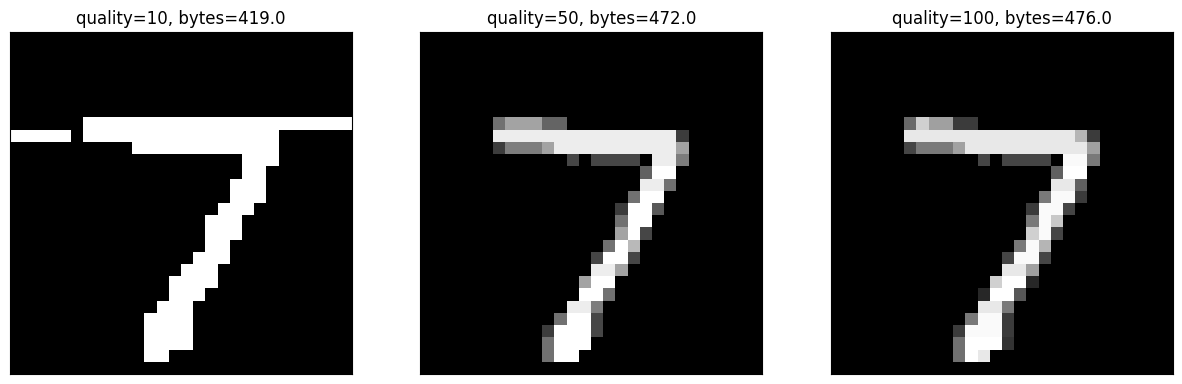

In [187]:
img = test_data[0][0]

qualities = [10, 50, 100]
fig, ax = plt.subplots(1, len(qualities), figsize=(5*len(qualities), 10))
for i, quality in enumerate(qualities):
    encoding, code_length = arithmetic_encoding(img, raster, quality=qualities[i])
    ax[i].set_title(f"{quality=}, bytes={np.ceil(code_length/8)}")
    ax[i].imshow(np.array(encoding).reshape(28, 28), cmap="gray")
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
plt.savefig("quality_plot.png")

In [205]:
def gather_data():
    byte_losses = dict()
    for quality in list(range(10, 100, 5)) + list(range(100, 2000, 100)):
      for i, (img, label) in enumerate(test_data):
        reconstruction, length = arithmetic_encoding(img, raster, quality)
        length = np.ceil(length / 8)
        reconstruction = torch.tensor(reconstruction, dtype=torch.float32)
        loss = F.mse_loss(img.argmax(dim=-1), reconstruction).item() / 255**2

        if length in byte_losses:
            byte_losses[length].append(loss)
        else:
            byte_losses[length] = [loss]
        print(quality, i, length, loss)
        if i == 19:
          break
    bytes = []
    losses = []
    for x, y in byte_losses.items():
      if len(y) == 0:
        continue
      y = np.mean(y)
      if np.isfinite(y):
        bytes.append(x)
        losses.append(y)
    return bytes, losses

In [207]:
all_bytes = []
all_losses = []
for beta in [1, 2, 4, 8, 16, 32, 64, 256]:
    raster = Raster(n_layers=3).to(device)
    optim = torch.optim.Adam(raster.parameters(), lr=1e-3)
    train_raster(raster, optim, 2, beta=beta)
    bytes, losses = gather_data()
    all_bytes.append(bytes)
    all_losses.append(losses)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 416.0 0.008810563019631873


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 398.0 0.012513319321294694


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 429.0 0.007512828881169502


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 391.0 0.010602024874747693


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 417.0 0.011785439531970877


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 425.0 0.004999843246888216


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 412.0 0.012580345825523837


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 415.0 0.007694783575577902


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 396.0 0.011777240499447329


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 396.0 0.01163947891886534


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 403.0 0.011846699023512592


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 405.0 0.014863866962226066


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 409.0 0.01323790260206411


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 402.0 0.01359651711481161


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 421.0 0.0046290869384671765


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 409.0 0.013781120655216743


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 412.0 0.0107100681303465


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 410.0 0.009691700420210976


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 391.0 0.016773238132569205


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 421.0 0.011937853304618416


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 422.0 0.004926127514808007


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 403.0 0.00811300979491061


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 434.0 0.0036325313769043155


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 398.0 0.005490784606581603


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 425.0 0.0058230153178765376


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 427.0 0.003540376973399654


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 418.0 0.007371732777056901


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 418.0 0.005822387836108708


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 401.0 0.007481561328575548


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 402.0 0.007409767934057814


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 408.0 0.008222602747440888


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 409.0 0.012533621195874183


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 417.0 0.006485378407643695


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 410.0 0.008153692389946175


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 422.0 0.004137596004241157


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 416.0 0.007930917120218185


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 419.0 0.005718012791053922


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 415.0 0.005925507448307141


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 401.0 0.008360658122777297


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 428.0 0.006505680751543877


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 422.0 0.004463059580449827


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 407.0 0.005489470508638504


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 437.0 0.002302646658962298


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 400.0 0.004176690418048347


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 429.0 0.0038044825007208767


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 430.0 0.0023505089219741206


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 424.0 0.004868084277982026


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 420.0 0.004499741216569348


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 405.0 0.0055037899523320355


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 408.0 0.00457481046953095


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 412.0 0.006013562335550029


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 421.0 0.006369253449694829


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 421.0 0.004739523260284506


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 414.0 0.006444204903162245


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 427.0 0.0012793548361057045


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 420.0 0.006007304882737409


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 421.0 0.004477457870019944


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 418.0 0.0038916743072075644


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 407.0 0.005439293555964052


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 434.0 0.00329826052855272


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 425.0 0.0034554409568285033


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 412.0 0.00360657981981089


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 439.0 0.0015029541156421208


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 404.0 0.0028402734600273933


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 433.0 0.0020963091118800462


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 430.0 0.0020252415218155275


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 426.0 0.0037116022927629997


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 424.0 0.0029782108012092706


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 408.0 0.004285126025747309


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 411.0 0.0033374330842554545


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 416.0 0.0045024675004805845


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 424.0 0.004792916936995386


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 425.0 0.0031435123547734044


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 419.0 0.0038363777697430074


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 427.0 0.0012793548361057045


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 423.0 0.004650860133422242


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 425.0 0.003107066317642253


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 421.0 0.00247640232084715


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 411.0 0.003957622312481978


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 436.0 0.0025075520739469195


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 427.0 0.0027585935904309643


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 417.0 0.0022297351078911956


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 440.0 0.0011676042990151024


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 404.0 0.0026283847877769367


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 434.0 0.0017714929635686996


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 433.0 0.0011629946311589893


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 428.0 0.002894314564635597


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 426.0 0.0022044307440347464


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 410.0 0.003430450568516316


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 414.0 0.0024950568797908255


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 420.0 0.00357901990069925


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 428.0 0.0035367479511335784


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 428.0 0.0023570212159235633


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 423.0 0.0025638686799398067


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 427.0 0.0012793548361057045


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 427.0 0.002978917128853686


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 427.0 0.0022358550497404844


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 423.0 0.0019364608301194251


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 412.0 0.0035215262384059014


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 438.0 0.0018810268990217104


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 429.0 0.002212845898737865


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 418.0 0.0016914608789287773


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 441.0 0.000901615563744263


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 406.0 0.0019993880527471404


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 435.0 0.0014918516306453647


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 434.0 0.000976586728680826


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 431.0 0.0022351292452872694


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 428.0 0.0016649209110152945


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 413.0 0.002684348229947616


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 416.0 0.0019415609381007305


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 420.0 0.00336152096887315


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 431.0 0.002872560846489331


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 430.0 0.001683810834286993


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 426.0 0.0019625889691239546


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 427.0 0.0012793548361057045


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 430.0 0.002455884324088091


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 428.0 0.001994032868968666


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 424.0 0.0014862218942609212


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 415.0 0.0026039240278678873


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 440.0 0.0013381235253943796


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 431.0 0.0016255521792624833


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 419.0 0.0014148208518433415


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 441.0 0.000901615563744263


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 407.0 0.0018101357735381223


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 437.0 0.001147027402508951


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 434.0 0.000976586728680826


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 433.0 0.001818962874480368


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 429.0 0.0012857888708294285


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 415.0 0.002000368698337178


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 417.0 0.0015852026845894608


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 422.0 0.002905338673076461


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 432.0 0.002519556827977821


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 431.0 0.0015002078856013912


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 427.0 0.0017683543814278162


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 427.0 0.0012284128907000913


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 431.0 0.002112845157211169


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 430.0 0.0016324176370341335


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 424.0 0.0015925781766252763


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 417.0 0.0022753218695183344


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 442.0 0.0011060305972687787


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 432.0 0.0014961082520094434


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 419.0 0.0014148208518433415


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 441.0 0.0007914538531979887


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 407.0 0.0017591938281325092


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 438.0 0.0009935542557249616


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 434.0 0.000976586728680826


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 434.0 0.0012883781130980272


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 430.0 0.001189201146719411


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 416.0 0.0014843192681675919


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 418.0 0.0014075434478325645


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 423.0 0.0024944488748317954


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 434.0 0.002182049309460304


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 432.0 0.0012562671912170198


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 428.0 0.0014504821847741854


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 433.0 0.00011337868390932124


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 432.0 0.0018046630249258099


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 431.0 0.0014648212226066896


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 425.0 0.0012753532905387952


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 419.0 0.0018687278809156934


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 443.0 0.0006907664954960231


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 433.0 0.0012486759289921546


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 420.0 0.0013339453979163663


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 441.0 0.0007223085420308595


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 409.0 0.0013498144212111928


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 438.0 0.0009550879103364692


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 435.0 0.0007446507883273561


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 434.0 0.0012192327432658113


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 431.0 0.0010809422382617262


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 417.0 0.0013182920274804162


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 418.0 0.0013667624127814422


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 426.0 0.0018238276181336505


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 435.0 0.00205054565101163


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 433.0 0.0012221555552176446


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 428.0 0.001412643438483696


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 433.0 0.00011337868390932124


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 433.0 0.0015890669538533857


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 431.0 0.0013488336582909819


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 426.0 0.00104333885629926


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 420.0 0.0015965798395223593


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 444.0 0.0006174234627119077


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 434.0 0.0011527944151963788


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 420.0 0.0013339453979163663


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 442.0 0.0006859214046468005


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 409.0 0.0013498144212111928


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 439.0 0.0008622076437135056


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 436.0 0.00047273811126204466


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 434.0 0.0012295310472534601


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 432.0 0.0009073040825456254


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 417.0 0.0012161138725940745


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 418.0 0.0013020306520854358


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 426.0 0.0017552510649825187


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 435.0 0.002020121702365076


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 433.0 0.0011018524697907655


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 430.0 0.0012230971298599097


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 433.0 0.00011337868390932124


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 435.0 0.0013705677822982746


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 431.0 0.001347656719320694


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 427.0 0.0009493013035100683


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 422.0 0.0013386727479364907


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 444.0 0.0005747985253192882


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 434.0 0.0010737040225288952


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 421.0 0.0011863176403756968


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 442.0 0.0006230531404312644


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 410.0 0.0012969305441041306


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 439.0 0.0008231920171178152


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 436.0 0.00047273811126204466


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 435.0 0.0011786871898728855


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 432.0 0.0009073040825456254


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 418.0 0.0010844730551725899


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 419.0 0.001160797623660371


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 427.0 0.0016953251481927024


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 438.0 0.0016434024398668781


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 434.0 0.0009503801544553177


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 430.0 0.001182433776972799


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 433.0 0.00011337868390932124


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 435.0 0.0013705677822982746


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 433.0 0.001016308448260585


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 427.0 0.000953008643666949


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 423.0 0.0011266270879139032


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 444.0 0.0005064182655484068


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 434.0 0.0010737040225288952


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 422.0 0.0010648573274476764


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 442.0 0.0005750339483123979


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 411.0 0.0011456542874885862


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 439.0 0.0007497508963086613


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 437.0 0.00041834381349908987


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 436.0 0.001067426975577302


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 433.0 0.000816149977435061


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 419.0 0.0009224474187174104


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 421.0 0.0009772536333869486


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 427.0 0.0015415578546637712


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 439.0 0.0014471867321913447


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 435.0 0.0008309794553927576


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 431.0 0.000989042675893887


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 433.0 0.00011337868390932124


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 435.0 0.0013705677822982746


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 433.0 0.0010205062872077446


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 427.0 0.0009425142809593967


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 424.0 0.0010116006923794334


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 444.0 0.0005064182655484068


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 435.0 0.0010227031773761895


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 423.0 0.0008472604835917976


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 442.0 0.0005168930341169863


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 411.0 0.0010390234525182623


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 439.0 0.00072144546127466


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 437.0 0.00041834381349908987


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 437.0 0.00084565200424341


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 433.0 0.0007471812481790357


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 420.0 0.0008800774984568736


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 421.0 0.0009068921949715855


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 428.0 0.001430827268771326


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 440.0 0.0012747059799716456


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 436.0 0.0007572244763695154


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 432.0 0.0008276055675889381


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 435.0 0.0013694693372140524


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 433.0 0.0009527144382569205


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 427.0 0.0008759778648649258


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 425.0 0.0009408469018639165


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 445.0 0.00040349474140242037


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 435.0 0.0009986935519842128


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 424.0 0.000823250858199821


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 442.0 0.0005168930341169863


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 412.0 0.0010150138271262856


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 440.0 0.0007317240537931625


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 437.0 0.00041000715268203633


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 437.0 0.0008216423788514333


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 434.0 0.0006610291043596514


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 421.0 0.0007451804167304943


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 421.0 0.0009068921949715855


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 428.0 0.0013653892977610776


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 441.0 0.0011811979382554186


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 436.0 0.0007567536890483828


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 433.0 0.0007626383838998221


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 435.0 0.0012537956311124328


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 435.0 0.0008136784173304739


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 428.0 0.0007824698231486988


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 425.0 0.0009393365105405673


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 445.0 0.00039515805125282344


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 435.0 0.0009688581314878892


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 424.0 0.0007934153790384107


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 443.0 0.00042367928580841805


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 413.0 0.0009346483487983889


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 440.0 0.0007317240537931625


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 437.0 0.00041000715268203633


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 437.0 0.0008216423788514333


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 434.0 0.0005880195239285972


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 421.0 0.0007256431828916463


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 421.0 0.0009059506203293204


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 428.0 0.0013653892977610776


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 442.0 0.0009947311946952495


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 436.0 0.0007001624131193531


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 433.0 0.0007174634511816369


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 435.0 0.0012537956311124328


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 435.0 0.0008119522558180747


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 429.0 0.0006764274576635188


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 425.0 0.0009393365105405673


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 445.0 0.00039515805125282344


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 436.0 0.0009301171161632545


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 424.0 0.000736804508970408


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 443.0 0.00042352235670137386


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 414.0 0.0008474370068378147


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 440.0 0.0006097537066009768


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 437.0 0.00032244270556434126


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 438.0 0.0007509278352789492


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 435.0 0.0005643041626117359


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 421.0 0.0005956500330964954


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 422.0 0.0008644634336290429


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 429.0 0.001263701582999928


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 443.0 0.0008873941494106834


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 436.0 0.0007001624131193531


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 433.0 0.0007163650060974144


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 437.0 0.001036767662602725


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 435.0 0.0008119522558180747


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 430.0 0.0006425315331881067


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 425.0 0.0008524193739900219


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 445.0 0.00039515805125282344


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 436.0 0.0009125414668299152


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 425.0 0.0006987304570169827


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 444.0 0.00035710362277091443


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 414.0 0.0008253693718123738


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 441.0 0.0005701104222421965


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 437.0 0.00032228577645729707


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 438.0 0.0007198565760652454


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 435.0 0.0005643041626117359


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 422.0 0.0005631664705844807


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 422.0 0.0008644634336290429


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 429.0 0.0012599354017610413


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 444.0 0.000799829760958075


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 436.0 0.0006662664886439411


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 433.0 0.0007163650060974144


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 437.0 0.0010045194644187332


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 435.0 0.0008119522558180747


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 430.0 0.0005520443327836649


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 426.0 0.0007921600048471441


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 446.0 0.00032595389900368847


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 438.0 0.0005283878125488093


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 425.0 0.0006902565198969447


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 444.0 0.00035710362277091443


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 414.0 0.0008126191605241974


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 441.0 0.0005157160951466984


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 438.0 0.00030953556516912065


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 438.0 0.0006839010377243729


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 435.0 0.0005632253116664864


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 422.0 0.0005448061757159205


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 422.0 0.0008248201492702627


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 429.0 0.0012564829614060697


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 445.0 0.000750398206875811


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 436.0 0.0006662664886439411


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 433.0 0.0007163650060974144


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 438.0 0.0010013809996080234


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 435.0 0.0007683465555052444


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 430.0 0.0005520443327836649


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 426.0 0.0007723874066802733


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 446.0 0.00032595389900368847


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 438.0 0.0005283878125488093


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 426.0 0.0006185219077961301


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 444.0 0.0003542201164272005


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 415.0 0.000788766464239265


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 441.0 0.0005157160951466984


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 438.0 0.00030953556516912065


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 439.0 0.0006479454407184136


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 435.0 0.0005632253116664864


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 422.0 0.0005448061757159205


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 422.0 0.0008248201492702627


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 429.0 0.0012107000237288543


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 445.0 0.0007315671246861183


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 437.0 0.000594355411962196


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 434.0 0.0006444538707505827


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 433.0 4.5586860624472485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 438.0 0.0009566767955458838


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 436.0 0.0007203273633863778


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 431.0 0.000525367029902111


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 426.0 0.00077091620363487


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 446.0 0.0003190491942890054


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 441.0 0.0003170091452299746


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 430.0 0.00029898233204701916


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 447.0 0.0001473138259952227


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 420.0 0.00040172933294698853


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 444.0 0.00031361563395463884


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 440.0 0.00017934625399016455


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 445.0 0.0002941372705303399


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 438.0 0.00032779777201264235


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 426.0 0.0003292493515865292


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 428.0 0.0004404506954675636


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 440.0 0.0005069478939515451


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 449.0 0.0004931580199960652


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 443.0 0.00023256361278283142


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 440.0 0.0002941176470588235


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 433.0 3.303282171980503e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 447.0 0.00038758641249947434


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 440.0 0.0004098109766319595


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 435.0 0.00016288868787883566


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 433.0 0.00031744071494061777


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 447.0 0.0002440584058809262


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 444.0 0.00023209284012797062


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 434.0 0.00014915769900417658


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 449.0 6.816451891437488e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 425.0 0.00021153559642587887


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 447.0 0.0002064158943056006


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 442.0 9.772536480532202e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 447.0 0.00020625897986482813


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 443.0 0.0001777377599755052


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 431.0 0.00017289268379255425


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 432.0 0.00026075135098654965


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 448.0 0.00016080942120931554


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 455.0 0.0002461768901609357


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 444.0 0.0001703230356629286


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 442.0 0.0002039835518115028


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 433.0 3.303282171980503e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 453.0 0.00017709044940835555


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 445.0 0.00022560003765359927


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 436.0 0.00014597995791789065


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 436.0 0.00021502718105998145


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 450.0 0.00013252359498055886


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 448.0 0.00011449678179760339


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 435.0 0.00010996555649560491


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 450.0 5.3491984729994175e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 428.0 0.00013689789850864902


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 449.0 0.0001497657919608369


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 443.0 7.334306211665885e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 449.0 0.00014911846672741554


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 444.0 0.00014851038843702693


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 432.0 0.00013558363923656165


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 435.0 0.00020977018797044706


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 449.0 0.00014362607997731492


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 459.0 0.0001524139046439846


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 446.0 0.00013630942902350508


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 444.0 0.00015319853551293373


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 433.0 3.303282171980503e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 453.0 0.0001628690644073193


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 448.0 0.0001515900414982744


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 437.0 0.00010812168348665101


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 438.0 0.00016453639950398435


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 452.0 9.319413950332354e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 449.0 8.287628537551663e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 436.0 8.919254260446328e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 451.0 3.717173158732894e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 430.0 0.00010392392520398554


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 450.0 0.00011435946882893973


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 444.0 4.274258655751957e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 451.0 0.00011416331477827038


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 445.0 0.00012293152330655952


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 433.0 0.00010129542132608251


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 438.0 0.00014605842247141274


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 450.0 0.00013015009356846677


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 461.0 9.784306163560514e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 448.0 0.00010000078552551152


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 446.0 0.00012224497312951298


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 433.0 3.303282171980503e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 456.0 8.821175768484477e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 450.0 8.889830786189131e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 438.0 9.442992688875298e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 440.0 0.00011441831724408131


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 452.0 8.562248608370278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 450.0 6.722296627151742e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 437.0 7.960047093046395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 451.0 3.24639647064737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 432.0 6.583025711217966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 452.0 8.703481138142106e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 445.0 3.19147274980908e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 453.0 8.883945944674975e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 447.0 8.968293139770461e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 435.0 8.158164957494563e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 439.0 0.00013003241140445532


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 452.0 9.133065035598914e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 463.0 6.430022765104242e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 449.0 7.289189826704273e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 447.0 9.421415669970309e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 433.0 3.303282171980503e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 457.0 8.171896254360928e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 452.0 7.167572701999382e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 439.0 7.261727966285128e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 441.0 0.00010419854380817699


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 452.0 7.814890602284878e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 451.0 4.817613222561447e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 438.0 6.161288269113367e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 451.0 2.8580059138044675e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 433.0 6.345675570008756e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 454.0 6.341752342332651e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 445.0 3.0973174855233337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 454.0 7.446116000494101e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 448.0 7.571656352875096e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 435.0 7.310767578922845e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 440.0 0.00010394354134236607


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 453.0 8.526940292598926e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 464.0 5.188349804847069e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 450.0 6.941992243818483e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 449.0 7.114610594999144e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 434.0 2.5088467170806262e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 458.0 6.188750129532511e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 452.0 6.592833047094642e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 440.0 6.30840564039935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 441.0 9.1212953525706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 453.0 7.703081546770248e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 452.0 4.231104251285188e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 439.0 5.867052793227815e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 451.0 2.6030019813663727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 434.0 4.6312643078280066e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 454.0 5.839590566151878e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 445.0 3.0973174855233337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 455.0 6.898838206008506e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 449.0 6.879222067627985e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 436.0 7.128341891865508e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 441.0 9.639149672798999e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 453.0 7.997316289342215e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 464.0 4.570455745475561e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 451.0 4.3272211294089865e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 450.0 5.8945146536469596e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 460.0 4.9098072396659336e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 452.0 6.263289988751321e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 441.0 4.348798514970767e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 442.0 7.585386916427876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 453.0 6.847836979532737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 452.0 4.231104251285188e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 440.0 4.603802447408862e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 451.0 2.5088467170806262e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 434.0 4.087909741018516e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 456.0 4.340952059618559e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 445.0 3.026700853980628e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 456.0 5.719935055285039e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 450.0 5.574778931180315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 437.0 6.394714449332889e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 443.0 7.844314076542076e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 453.0 7.903161025056469e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 464.0 4.570455745475561e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 452.0 3.8466367387899935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 452.0 3.850559966466098e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 460.0 3.781904948761444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 452.0 6.127941200523274e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 441.0 4.278181883428061e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 443.0 7.236227719704036e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 454.0 5.645395562723021e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 452.0 4.123218056789869e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 440.0 4.368413920037703e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 452.0 2.1616489508664412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 434.0 4.009447020780394e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 456.0 3.3444749626092205e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 445.0 3.0090466960949513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 457.0 4.2899511997995816e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 451.0 4.729342799789857e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 438.0 5.1236180148185197e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 443.0 7.161687860485226e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 453.0 7.400999615532487e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 464.0 4.5606476762853e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 452.0 3.603402122723419e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 452.0 3.615171439094939e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 461.0 3.7407117914759346e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 453.0 5.710127352751571e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 442.0 3.844675124951942e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 443.0 6.398637677008993e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 455.0 4.580263448009029e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 452.0 4.099679057390036e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 442.0 2.9972773797234313e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 452.0 1.9497996062235117e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 435.0 3.48570785903784e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 457.0 2.5853478234806964e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 445.0 2.956084405766318e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 458.0 3.593594420189951e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 451.0 4.2271810236090835e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 439.0 4.3723371477138073e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 445.0 5.957284829837457e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 455.0 6.396676063170941e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 465.0 4.3958761471136405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 452.0 3.3935142085901455e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 452.0 3.593594420189951e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 462.0 3.24639647064737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 453.0 5.445315351123216e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 442.0 3.8348674224184735e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 445.0 5.535547387732858e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 456.0 3.568093806952066e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 453.0 3.817213264532797e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 442.0 2.5441548495235832e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 452.0 1.9497996062235117e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 436.0 3.252281312161526e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 457.0 2.302881847295061e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 445.0 2.956084405766318e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 458.0 2.8246592118711667e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 451.0 4.213450093399511e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 439.0 4.356644603666183e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 445.0 5.490431369428037e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 455.0 6.124018339503962e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 465.0 4.3232979017328824e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 454.0 2.200880310985502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 453.0 2.954122791928266e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 462.0 3.1090868018948544e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 454.0 4.998077662437524e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 442.0 3.7975974928090686e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 446.0 4.8156516087233954e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 456.0 3.197357224666444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 453.0 3.6504797548662923e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 443.0 2.347998048928278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 452.0 1.6908724461093127e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 436.0 2.687349359790255e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 457.0 2.1322254766092442e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 445.0 2.391152453395047e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 459.0 2.5186546029424904e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 451.0 4.144795075694858e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 439.0 4.287989585961529e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 445.0 5.4610078951708405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 457.0 4.9411923277611826e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 466.0 3.322897943704232e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 454.0 2.043954870509258e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 453.0 2.8109282816615943e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 462.0 2.5441548495235832e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 454.0 4.9686541881803275e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 442.0 3.538670332694869e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 447.0 4.217373321075615e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 457.0 2.846236597432947e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 453.0 3.556324490580546e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 443.0 2.347998048928278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 453.0 1.6437948139664395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 437.0 2.342113390742518e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 458.0 2.085147844466371e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 446.0 2.2499195569664273e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 459.0 2.4303839968425043e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 452.0 3.9800235465231973e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 439.0 3.7662124047138195e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 446.0 5.0078853649709925e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 457.0 4.821536450237551e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 466.0 3.322897943704232e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 454.0 1.8968371325664822e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 453.0 2.7815048074043976e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 462.0 2.5441548495235832e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 455.0 4.101640671228089e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 442.0 3.426860910523446e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 448.0 3.352321417961429e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 457.0 2.5931940955045085e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 453.0 3.399399050104302e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 443.0 2.347998048928278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 453.0 1.6437948139664395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 437.0 2.342113390742518e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 458.0 1.777181438371247e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 446.0 2.2499195569664273e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 459.0 2.379383137023527e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 452.0 3.744635019152039e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 441.0 2.6677337713949225e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 446.0 4.998077662437524e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 458.0 4.083986513342412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 466.0 3.322897943704232e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 454.0 1.8968371325664822e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 453.0 2.652041227347298e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 463.0 2.4499995852378368e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 457.0 3.3327056462377e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 442.0 3.426860910523446e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 448.0 3.0404317841902004e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 457.0 2.469615356961565e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 453.0 3.336628873913804e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 443.0 2.3440748212521737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 453.0 1.518254369921246e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 437.0 2.342113390742518e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 458.0 1.7614888943236226e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 446.0 2.234227012918803e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 459.0 2.2224576965472827e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 452.0 3.71324993105679e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 441.0 2.638310297137726e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 446.0 4.988269959904056e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 459.0 3.2208962240662774e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 467.0 3.197357224666444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 454.0 1.8968371325664822e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 453.0 2.652041227347298e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 463.0 2.4499995852378368e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 457.0 3.3327056462377e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 442.0 3.426860910523446e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 448.0 2.8854679575520083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 458.0 2.2577658289902397e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 454.0 2.956084405766318e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 443.0 2.2989588029473526e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 453.0 1.2436346657594227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 437.0 2.342113390742518e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 458.0 1.732065420066426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 446.0 2.2106881968473665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 459.0 2.2165728550331265e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 453.0 3.1561644340377276e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 441.0 2.3734984788377666e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 446.0 4.746996957675533e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 460.0 3.0012004240711393e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 467.0 3.158126047875779e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 454.0 1.8654520444712332e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 453.0 2.6206561392520493e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 463.0 2.4499995852378368e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 457.0 3.199318838504497e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 443.0 3.3013205581424514e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 448.0 2.8854679575520083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 458.0 2.1008403885139955e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 454.0 2.8325054838949788e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 443.0 2.049839528695018e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 453.0 1.2436346657594227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 437.0 1.847797886585557e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 458.0 1.702641762480833e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 446.0 2.2106881968473665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 459.0 2.18714938077593e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 454.0 2.9678537221378385e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 441.0 2.304843461133113e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 448.0 4.229142637447136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 460.0 3.0012004240711393e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 467.0 2.9698153359758906e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 455.0 1.6771415158997403e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 454.0 2.2459965126187193e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 463.0 2.4499995852378368e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 457.0 3.1522412063616234e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 443.0 3.3013205581424514e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 449.0 2.4911925591949496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 458.0 1.8419132283997966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 455.0 2.6226177530901014e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 443.0 1.9909923968522287e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 453.0 1.2436346657594227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 437.0 1.81837441232836e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 458.0 1.702641762480833e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 447.0 1.8262206843521724e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 459.0 2.157725906518733e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 455.0 2.5833862096426444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 441.0 2.2891509170854884e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 448.0 4.0977174435519845e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 460.0 2.846236597432947e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 467.0 2.844274983594895e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 455.0 1.6771415158997403e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 454.0 2.0576858007188302e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 434.0 1.9792230804807083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 463.0 2.2440348987806673e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 457.0 3.1522412063616234e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 443.0 3.3013205581424514e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 449.0 2.4460765408901285e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 458.0 1.8419132283997966e-05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 538.0 0.03577479965638216


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 496.0 0.0280980046736832


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 529.0 0.023404754556540754


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 501.0 0.03631995881992503


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 529.0 0.03144342019896194


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 534.0 0.01628453261666186


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 524.0 0.02830167295931853


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 533.0 0.029431988673226644


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 504.0 0.023569741430579584


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 527.0 0.02464570229899558


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 508.0 0.021521588376465783


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 505.0 0.031001890799211843


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 537.0 0.03151705849312764


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 519.0 0.03210609726427335


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 520.0 0.012184246668949442


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 508.0 0.043639300389273356


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 533.0 0.02042346430759804


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 535.0 0.019266470528162244


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 499.0 0.02966037326388889


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 533.0 0.031019525993608226


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 539.0 0.03681197961721453


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 497.0 0.024085399095299883


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 531.0 0.026414663981401385


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 503.0 0.0340892625432526


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 535.0 0.023490886167579775


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 536.0 0.016718295697568244


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 528.0 0.022038913068291043


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 535.0 0.022978819744809687


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 506.0 0.023726646602268357


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 529.0 0.026578317984669357


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 507.0 0.043299711198817765


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 509.0 0.028551145067401962


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 539.0 0.03359971600466167


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 522.0 0.029379909094458864


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 522.0 0.012439917564758747


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 512.0 0.0432744467272203


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 536.0 0.019562099387855632


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 535.0 0.02084633914840446


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 503.0 0.0312339830233564


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 535.0 0.03426082366157247


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 543.0 0.026568098057237602


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 500.0 0.017182519568795657


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 537.0 0.016794246804113802


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 507.0 0.02599675079897155


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 538.0 0.021572177392709536


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 541.0 0.011897818372140522


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 532.0 0.017368359299908688


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 539.0 0.01793446706194733


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 510.0 0.008773960698709631


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 535.0 0.016637968644872166


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 514.0 0.018429803140618994


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 517.0 0.020724623642349095


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 545.0 0.021099087114931758


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 528.0 0.020403063875672818


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 524.0 0.011800072951208669


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 520.0 0.02469383770665129


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 540.0 0.013509050755718954


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 540.0 0.010377994641484044


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 509.0 0.01978018708249231


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 543.0 0.018908307501922336


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 549.0 0.011736851699166186


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 504.0 0.011500109445585832


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 541.0 0.004329300366745963


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 510.0 0.008330646003039696


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 544.0 0.006211249128940792


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 543.0 0.00776530229509083


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 534.0 0.013782434753159843


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 543.0 0.009168864026155805


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 511.0 0.008048337403282391


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 539.0 0.006981106369094819


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 520.0 0.007352941176470588


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 521.0 0.013564111459534794


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 550.0 0.008607835252667244


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 532.0 0.013777628909253652


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 530.0 0.004198130395310698


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 522.0 0.019768103013264128


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 544.0 0.00624851882388985


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 541.0 0.00892215715560121


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 511.0 0.009710472309328142


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 550.0 0.0065117026053681274


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 549.0 0.013022836394055172


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 507.0 0.010683822778498653


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 542.0 0.004161605981623654


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 511.0 0.008807169831014514


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 544.0 0.006101499423298731


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 544.0 0.00761710583819925


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 535.0 0.010331073835784313


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 544.0 0.008353596723615917


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 512.0 0.007857476410064639


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 540.0 0.00808240914702278


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 519.0 0.008167051134179162


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 522.0 0.015044154629529507


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 550.0 0.00788378136564062


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 533.0 0.013515641895544982


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 530.0 0.004198130395310698


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 522.0 0.019505645740220106


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 545.0 0.005328582212220059


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 544.0 0.008112754484453095


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 512.0 0.008655658092740773


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 549.0 0.006619647772941897


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 549.0 0.012920050468870146


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 508.0 0.01093937540549308


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 543.0 0.004019960772299116


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 511.0 0.008804031014213284


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 545.0 0.005693649884509564


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 542.0 0.00732695019643887


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 536.0 0.009993723305038928


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 544.0 0.00820224173845396


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 513.0 0.00757012589809208


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 542.0 0.007157490226865869


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 520.0 0.008413463271337946


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 524.0 0.014524711424091695


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 551.0 0.007733269749765715


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 534.0 0.01335322408298491


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 530.0 0.004193187040441177


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 525.0 0.013988517224444925


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 545.0 0.0052205394259419455


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 544.0 0.008112754484453095


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 513.0 0.008345200576400903


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 549.0 0.009720083997140522


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 551.0 0.006010600452650423


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 509.0 0.010170656268021914


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 543.0 0.003907621824388456


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 512.0 0.006671492222042003


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 546.0 0.0043889909192077565


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 542.0 0.0056992990977028065


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 537.0 0.008970411770713187


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 546.0 0.007366946644619858


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 515.0 0.006337574302852269


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 543.0 0.005002177178699298


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 523.0 0.005099392736567667


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 524.0 0.010558026998329969


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 552.0 0.004749723476247116


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 536.0 0.005839492698120915


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 530.0 0.004117234995254229


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 524.0 0.011167447428573144


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 546.0 0.004979579856605632


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 544.0 0.008112754484453095


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 515.0 0.007077517511293733


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 550.0 0.0049427222252258745


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 551.0 0.0056070860291114


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 509.0 0.009508038337117936


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 543.0 0.003907621824388456


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 512.0 0.0066206483646614285


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 546.0 0.004387108004583574


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 544.0 0.004388853408244425


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 539.0 0.0058970060718834105


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 547.0 0.007114277054648453


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 515.0 0.006325098820165321


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 544.0 0.004894683497633122


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 523.0 0.005074147507118656


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 526.0 0.00904628497002355


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 554.0 0.004294600202596357


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 537.0 0.005613088171466503


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 530.0 0.004095461800299164


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 526.0 0.009601251997428874


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 546.0 0.004873419984951701


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 544.0 0.008102005163278546


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 517.0 0.0060997929732554785


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 552.0 0.004568553016718329


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 552.0 0.005467382868818483


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 510.0 0.009379752341347077


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 543.0 0.003801226353746155


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 512.0 0.0066206483646614285


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 547.0 0.004191264702878701


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 544.0 0.004283850881421809


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 539.0 0.005854224205383746


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 547.0 0.007114277054648453


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 516.0 0.006137827660935698


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 543.0 0.004680303436478758


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 523.0 0.005058788048767301


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 526.0 0.009026551912125143


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 554.0 0.0042333796646722415


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 538.0 0.005274854848495771


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 532.0 0.0039776106808378986


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 527.0 0.0062368280454032105


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 546.0 0.00518017033712995


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 544.0 0.008100828106978085


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 520.0 0.0053237960797830166


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 552.0 0.004433381147725635


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 552.0 0.005476681050407295


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 510.0 0.00922639617274606


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 543.0 0.003797931018493488


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 513.0 0.009716788427227509


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 546.0 0.004598858931210352


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 544.0 0.004283850881421809


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 540.0 0.005728232249164984


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 549.0 0.006756526091977845


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 518.0 0.0056310758257040565


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 544.0 0.004373161201521049


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 524.0 0.004891525438683439


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 527.0 0.008847794230284025


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 555.0 0.004137125275585111


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 539.0 0.005058297608642109


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 532.0 0.003918410568501298


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 527.0 0.006150989759797915


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 547.0 0.00508581857413615


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 544.0 0.007575187052455786


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 520.0 0.005283603455551951


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 553.0 0.0043306341761582086


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 552.0 0.005438077076725298


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 511.0 0.009106348632437044


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 543.0 0.003795969257992719


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 514.0 0.009554566790717513


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 546.0 0.004558725441386726


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 544.0 0.004282811336084679


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 541.0 0.005607537046298299


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 549.0 0.006638537930873943


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 520.0 0.005305867559952902


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 544.0 0.004083888351986015


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 525.0 0.004697271256848328


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 527.0 0.008801716324550653


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 556.0 0.004009603803224722


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 538.0 0.004987857735005767


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 533.0 0.0037894961523212227


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 528.0 0.0059977129063941755


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 547.0 0.005079777008842753


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 545.0 0.0071410330274113325


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 521.0 0.0052073965692281815


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 553.0 0.0043306341761582086


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 552.0 0.005349983235864811


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 511.0 0.009106348632437044


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 543.0 0.003681119444369353


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 514.0 0.009551742418781237


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 546.0 0.004558725441386726


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 545.0 0.0042549374414287775


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 542.0 0.005453926505881152


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 549.0 0.006637753226673635


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 521.0 0.005109553529591984


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 544.0 0.003991714237012207


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 525.0 0.00465490098459727


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 529.0 0.008603245296280277


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 556.0 0.0040037189910431085


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 539.0 0.004911121454939206


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 533.0 0.003783454587027826


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 528.0 0.005847201759839965


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 548.0 0.004931011735270089


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 546.0 0.006734282168366734


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 521.0 0.005116321133998943


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 553.0 0.004298915606377355


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 553.0 0.00529396089394704


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 511.0 0.009080750004505478


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 543.0 0.0036731555415134803


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 514.0 0.009523750255310458


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 546.0 0.0045244570522755675


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 544.0 0.004855020267144848


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 542.0 0.005445452920751634


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 549.0 0.006606465962610534


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 521.0 0.004794898408965301


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 544.0 0.003991714237012207


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 525.0 0.004620809060067042


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 530.0 0.008460933182249615


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 556.0 0.0040037189910431085


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 539.0 0.0049074921980127835


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 533.0 0.003778060214971405


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 529.0 0.005795808327926759


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 548.0 0.004931011735270089


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 547.0 0.006190005327728518


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 521.0 0.008302791819852941


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 553.0 0.004293266393184112


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 553.0 0.00527138328332252


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 511.0 0.00905742664329825


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 544.0 0.0036419468886666187


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 515.0 0.009439462135957324


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 547.0 0.004495720076863466


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 545.0 0.00452488835799332


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 543.0 0.005072715140360678


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 549.0 0.006606465962610534


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 521.0 0.005198334455948433


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 545.0 0.0043118425755718955


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 528.0 0.0041406170215482025


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 531.0 0.008333823304137832


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 556.0 0.00394016452130791


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 539.0 0.004902058872338764


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 533.0 0.0037726658429149845


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 530.0 0.00578325446868392


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 548.0 0.004927559412245291


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 547.0 0.006469921330587995


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 521.0 0.008295631863345828


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 554.0 0.004106211121473712


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 553.0 0.005270441356689735


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 511.0 0.00905742664329825


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 544.0 0.003639828375054066


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 518.0 0.007830956036290129


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 547.0 0.004495720076863466


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 546.0 0.004466041174818579


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 544.0 0.004683775470972703


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 549.0 0.006603327615129998


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 521.0 0.0051750110947412055


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 545.0 0.004296326364108757


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 529.0 0.004108839786680604


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 531.0 0.008330705137447136


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 557.0 0.0033765075519331506


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 539.0 0.004899469630070165


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 533.0 0.0037726658429149845


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 530.0 0.0057503001775158595


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 549.0 0.004823517584883218


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 547.0 0.006465448704374519


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 521.0 0.008258990119485294


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 555.0 0.004077964586186803


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 554.0 0.00521630239871684


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 511.0 0.00905742664329825


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 544.0 0.0036379454604298827


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 518.0 0.007674010972342368


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 547.0 0.004495720076863466


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 547.0 0.00383078722163651


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 544.0 0.004680244771392013


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 549.0 0.006600189267649462


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 521.0 0.0051750110947412055


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 546.0 0.004479556672163351


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 529.0 0.004105504793829297


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 532.0 0.008299888602040081


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 558.0 0.003369916646767469


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 539.0 0.00489893976700668


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 533.0 0.0037726658429149845


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 530.0 0.005653496683216791


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 549.0 0.0048013323263588524


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 547.0 0.006461035212568483


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 522.0 0.008206106125048058


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 555.0 0.0040773366350982795


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 554.0 0.005196392406916811


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 512.0 0.009055308129685698


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 544.0 0.0036197419186731064


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 518.0 0.007592448667579777


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 548.0 0.0042692761272707614


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 547.0 0.0038056790338301377


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 544.0 0.00467916580311659


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 549.0 0.006599796915549308


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 521.0 0.004563276444156094


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 546.0 0.004452879075956363


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 529.0 0.004084457168667099


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 532.0 0.008248711057646097


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 558.0 0.0033687984902141003


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 539.0 0.00489893976700668


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 533.0 0.0037726658429149845


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 531.0 0.005611263921929066


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 549.0 0.004799743206489091


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 547.0 0.006377531328094963


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 523.0 0.008159028566236544


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 555.0 0.004049090099811371


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 555.0 0.0033123640847270283


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 513.0 0.0038692339728860293


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 544.0 0.0036197419186731064


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 520.0 0.00555694849937524


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 549.0 0.0035797457051524656


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 547.0 0.0037838077508500338


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 546.0 0.0038667820069204152


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 551.0 0.00351140463365953


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 522.0 0.0042685111345396


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 547.0 0.0036299618461048634


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 529.0 0.00371536859133206


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 533.0 0.003689730775122549


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 559.0 0.0030941787713860054


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 541.0 0.003818292027480416


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 533.0 0.0037726658429149845


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 533.0 0.00387170565032079


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 551.0 0.0032519477278120192


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 548.0 0.004152111623984766


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 525.0 0.003459030556156286


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 555.0 0.0032811164782625673


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 555.0 0.0033123640847270283


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 514.0 0.004389324136900471


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 544.0 0.0036197419186731064


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 520.0 0.00555694849937524


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 549.0 0.0035797457051524656


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 547.0 0.0037813557848844193


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 546.0 0.0036623081323138938


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 552.0 0.0034647389037569683


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 522.0 0.004024962792255383


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 547.0 0.0035823152359519177


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 529.0 0.003713779706122645


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 534.0 0.0035808049619587418


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 559.0 0.003043433002030469


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 541.0 0.003792085394589821


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 533.0 0.0037726658429149845


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 533.0 0.00387170565032079


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 551.0 0.0032240151680693724


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 548.0 0.004127513587772732


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 525.0 0.0034339226030102605


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 555.0 0.0032582051806246395


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 600.0 0.0008484374225620855


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 574.0 0.0009664061655222751


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 603.0 0.0012240974869190935


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 574.0 0.000715325343430111


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 598.0 0.0008318817830919898


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 609.0 0.0006357445106374352


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 591.0 0.0012247447974862433


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 586.0 0.0013156046971867792


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 563.0 0.0015367322992884348


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 581.0 0.0011269802517361112


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 589.0 0.0006546932749911393


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 597.0 0.0006531043897817245


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 607.0 0.0006017112511939518


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 598.0 0.0004865671734954705


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 610.0 0.00026461564958301796


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 584.0 0.0013570330428050508


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 600.0 0.0008297240225364043


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 596.0 0.0008322348295840241


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 559.0 0.0018262402784911453


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 611.0 0.0007928661564962995


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 605.0 0.0006762705285564747


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 579.0 0.0008235254694708765


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 611.0 0.0011513821118980681


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 577.0 0.0005749358602873594


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 601.0 0.000741943863894746


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 612.0 0.0004918241812512765


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 597.0 0.0012358472824829992


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 594.0 0.0010484389642805652


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 564.0 0.0015019733527219098


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 585.0 0.0009388068821374291


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 595.0 0.0004946292230414684


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 603.0 0.0004630675823676591


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 609.0 0.0005653437666139526


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 598.0 0.00044602153210491455


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 610.0 0.0002627325296310313


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 589.0 0.0012361611406970876


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 603.0 0.0007576560167476151


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 600.0 0.0005743277966632426


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 569.0 0.0014300229704320455


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 616.0 0.0007512220406889778


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 605.0 0.0006728965820875684


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 576.0 0.0007919834816011269


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 615.0 0.001089808527481918


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 581.0 0.0005128914298849901


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 600.0 0.0007314886894651396


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 618.0 0.00044005837269995316


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 596.0 0.0012320026073580474


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 598.0 0.0009724477894807586


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 572.0 0.0015624680861928105


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 588.0 0.0008686612139111159


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 593.0 0.0005064967007693856


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 606.0 0.00039541306838490603


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 613.0 0.0005252296949340398


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 600.0 0.00039276495570175833


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 653.0 7.049878804970594e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 590.0 0.0011936343499945935


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 607.0 0.0006957685154522899


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 602.0 0.0005386664637323985


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 571.0 0.001413074978861796


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 623.0 0.0005500631541391832


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 611.0 0.000594002306805075


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 583.0 0.0007194053828830858


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 628.0 0.000796200856022173


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 584.0 0.0004421180158979569


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 613.0 0.00042550353534585557


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 618.0 0.00043937181518977075


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 610.0 0.00034976734834558823


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 601.0 0.0009121687675338211


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 585.0 0.0006492793087957456


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 600.0 0.0005026912725874664


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 597.0 0.0004424710917225346


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 609.0 0.000363792586629091


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 615.0 0.0003932161195513745


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 600.0 0.0003886652634447238


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 653.0 7.049878804970594e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 602.0 0.0008666799766015474


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 609.0 0.0006662861414480008


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 608.0 0.0004481007987744347


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 582.0 0.0008039686414930556


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 626.0 0.0005287997587879362


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 619.0 0.0002053370433603512


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 595.0 0.0003309951365704447


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 628.0 0.0007885310999112421


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 592.0 0.00030680898793245085


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 620.0 0.00031081059216444694


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 621.0 0.0002967265421314819


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 615.0 0.0002521596730374135


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 618.0 0.0003044747334633915


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 594.0 0.0003796028275069985


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 606.0 0.0003236981090881512


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 605.0 0.00028589866840578144


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 620.0 0.00018050356948893603


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 621.0 0.0002566124411190257


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 615.0 0.00023173974963712124


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 653.0 7.002800806170929e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 607.0 0.0007493977911515403


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 619.0 0.0002577697859503406


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 616.0 0.00019382262679074004


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 595.0 0.0003702461274941579


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 628.0 0.0004931580199960652


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 619.0 0.0002016689061476881


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 597.0 0.00047950553967374327


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 630.0 0.0007792725172559833


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 599.0 0.0002414102931977785


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 620.0 0.0003301712734247345


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 622.0 0.000295549603161194


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 616.0 0.00024248915880929962


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 619.0 0.00036816686082463777


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 597.0 0.0003627725474333039


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 607.0 0.0003131448759660497


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 606.0 0.000291332228740148


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 624.0 0.0001597501790693108


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 621.0 0.00025084542843159784


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 619.0 0.00020773015357768797


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 653.0 6.855683434884945e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 618.0 0.0007062432840208694


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 621.0 0.0002637917864373078


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 619.0 0.00016818492791140276


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 596.0 0.0003478254166441393


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 629.0 0.0004879206650443189


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 620.0 0.00019904040226978505


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 598.0 0.00020151197704064392


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 647.0 9.51949416193216e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 603.0 0.0001593382474964557


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 621.0 0.00017724736384912805


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 621.0 0.00021092750346921857


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 618.0 0.00020388547845273604


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 620.0 0.00021051557189636348


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 597.0 0.00021432102941082605


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 608.0 0.00021428179713406503


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 606.0 0.00023056281066683338


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 625.0 0.00014148797222578906


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 621.0 0.0001860352031820694


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 622.0 0.00014093873501740616


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 653.0 6.80860543608528e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 624.0 0.00014191951260388884


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 621.0 0.00019170412784445888


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 624.0 0.00014666651542807305


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 596.0 0.0002328578475254034


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 633.0 0.00014758845193255


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 641.0 0.00010404161470113282


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 599.0 0.00019845193278464113


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 650.0 8.01104758620858e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 610.0 0.00013220975143274222


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 639.0 9.972616692132007e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 626.0 0.00018695713968654634


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 623.0 0.00017697275257807244


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 620.0 0.00020725938092282716


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 597.0 0.00021392870664321565


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 609.0 0.0002098094202472081


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 608.0 0.0002192641789525438


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 630.0 0.00012134265276341657


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 643.0 9.313529108818198e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 624.0 0.00013185666094189284


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 653.0 6.80860543608528e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 626.0 0.00013171935530636504


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 622.0 0.00018201397547855692


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 629.0 0.00012130342048665552


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 597.0 0.00023107281559845523


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 639.0 0.00012100918574408356


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 646.0 8.207204570132281e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 599.0 0.00019682382996473712


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 650.0 7.72858179335134e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 611.0 0.00012777660682264635


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 640.0 9.439069461199193e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 629.0 0.00016922454657989115


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 632.0 0.00013230782479150898


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 620.0 0.00020159044159416602


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 599.0 0.00020264968373417074


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 609.0 0.00020449355674312465


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 608.0 0.00021628258458379138


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 631.0 0.00011435946882893973


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 649.0 6.739951151694211e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 632.0 0.00010031463640646402


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 653.0 6.80860543608528e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 637.0 8.579902399599163e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 623.0 0.0001786989287567432


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 629.0 0.00012100918574408356


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 598.0 0.00022579619903740448


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 648.0 8.222896747523113e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 644.0 8.73094299856125e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 607.0 0.00016063288329702668


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 659.0 3.640672052332824e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 608.0 0.00013778060273636491


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 645.0 7.54615537298042e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 633.0 0.00014594072564112962


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 631.0 0.00013489709639265097


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 621.0 0.0001980596100170307


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 600.0 0.00019723576153759221


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 612.0 0.0001913314285483648


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 630.0 0.0001185376109732247


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 632.0 0.00011002440491074647


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 654.0 4.978461890713795e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 633.0 9.654842583503416e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 653.0 6.80860543608528e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 637.0 8.579902399599163e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 635.0 0.00012544233768731528


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 634.0 0.00010013809116103932


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 598.0 0.00022199075618921358


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 649.0 8.097356395142118e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 646.0 7.995354675504163e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 614.0 0.0001318958932186539


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 660.0 3.599478895047315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 621.0 9.743113006275005e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 655.0 4.2193349349136676e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 635.0 0.00013809444628418158


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 631.0 0.00013489709639265097


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 621.0 0.00019747114053188678


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 602.0 0.00018381863087702145


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 614.0 0.00018262206843521722


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 642.0 7.920815549598937e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 632.0 0.00010831783753732038


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 656.0 4.427261235208889e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 634.0 9.52930223112242e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 653.0 6.667372906313452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 640.0 7.512809404360702e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 642.0 9.590110793474865e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 635.0 9.968693464455903e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 598.0 0.00022142189550931432


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 651.0 7.214650700799047e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 656.0 4.8411522219612796e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 633.0 6.473177536227803e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 660.0 3.599478895047315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 624.0 8.70740436581821e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 655.0 3.9819847937044573e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 649.0 7.077340665389739e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 645.0 8.250358607942258e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 647.0 8.222896747523113e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 615.0 0.00013205282232569806


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 617.0 0.0001735988501079813


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 642.0 7.675618953037518e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 648.0 5.908245583856532e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 656.0 4.3801836030660156e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 634.0 9.513609320418003e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 653.0 6.667372906313452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 640.0 7.503001335170442e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 646.0 7.730543407189393e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 637.0 9.246835704951597e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 600.0 0.00021222213926978958


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 660.0 3.746596632990091e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 656.0 4.7842665206281464e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 635.0 6.151480199923107e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 660.0 3.599478895047315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 627.0 7.94631579618003e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 655.0 3.9819847937044573e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 655.0 4.919614942199402e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 645.0 7.944354182341978e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 648.0 7.689350249903884e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 626.0 9.274298298684325e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 625.0 0.00014048757116779002


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 644.0 7.181303998865746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 648.0 5.892553039808908e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 656.0 4.3664523061996515e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 636.0 8.666211941846285e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 653.0 6.620294907513787e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 641.0 7.03222501374171e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 651.0 6.13382604203743e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 639.0 8.556363766856122e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 615.0 0.000137859067289887


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 660.0 3.7230580002470505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 656.0 4.7842665206281464e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 637.0 5.539470615408962e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 660.0 3.552401262904442e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 627.0 7.5755795805512e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 655.0 3.944715230751844e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 655.0 4.919614942199402e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 645.0 7.944354182341978e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 653.0 5.937669058113729e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 631.0 7.734466634865496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 632.0 0.0001166937379642708


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 644.0 7.024378558389501e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 649.0 5.5022010524563496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 656.0 4.331144357085091e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 636.0 8.577940785761111e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 653.0 6.573217642027706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 641.0 6.98122378726594e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 651.0 6.11028740929439e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 639.0 8.509285768056457e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 617.0 0.00012811007384197934


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 660.0 3.7230580002470505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 656.0 4.6685342374374116e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 637.0 5.539470615408962e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 660.0 3.528862630161401e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 628.0 7.2833057185037e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 657.0 3.387629733732781e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 655.0 4.919614942199402e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 645.0 7.903161025056469e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 653.0 5.874898881923231e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 631.0 7.710927268808871e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 632.0 0.00011551679166084709


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 644.0 7.006724033847034e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 651.0 4.884306626428049e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 656.0 4.313490199199414e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 636.0 8.577940785761111e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 653.0 6.573217642027706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 641.0 6.98122378726594e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 651.0 6.063209777151516e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 639.0 8.47986229379926e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 620.0 0.00011710566220399005


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 660.0 3.7230580002470505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 656.0 4.533185815866156e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 637.0 5.539470615408962e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 660.0 3.528862630161401e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 629.0 6.728181468665898e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 657.0 3.2444348568093175e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 655.0 4.8607679936850086e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 645.0 7.875699164637324e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 654.0 5.67678065081827e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 634.0 7.03614750810423e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 632.0 0.00011449678179760339


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 645.0 6.439830834294502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 651.0 4.76661236274247e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 657.0 4.0918329686946204e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 637.0 8.422976959122919e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 653.0 6.573217642027706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 653.0 3.144395117666207e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 651.0 6.037709163913632e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 640.0 8.43278502831318e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 620.0 0.00011675258637941236


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 661.0 3.558286104418598e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 656.0 4.533185815866156e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 638.0 5.3531217006755216e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 660.0 3.4974775420661526e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 629.0 6.6987579944087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 657.0 3.2444348568093175e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 655.0 4.743073729999429e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 645.0 7.865891095447063e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 654.0 5.67678065081827e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 634.0 7.004762420008981e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 633.0 0.00010659165402551377


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 645.0 6.439830834294502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 651.0 4.6489184657136826e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 657.0 3.944715230751844e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 637.0 8.422976959122919e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 653.0 6.573217642027706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 647.0 3.3483981902853246e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 651.0 5.920014900228052e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 640.0 8.43278502831318e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 620.0 0.0001157129530446523


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 661.0 3.55043964906639e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 656.0 4.533185815866156e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 637.0 5.347236859161365e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 660.0 3.4974775420661526e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 629.0 6.669334520151504e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 658.0 3.203242066180601e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 655.0 4.743073729999429e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 646.0 7.809005760770723e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 654.0 5.629703018675397e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 634.0 7.004762420008981e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 633.0 0.00010535586664008435


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 645.0 6.422177043065618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 651.0 4.6489184657136826e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 657.0 3.897637598608971e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 637.0 8.385707029513513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 653.0 6.573217642027706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 653.0 3.1130100295709585e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 651.0 5.910207197694584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 640.0 8.426900186799022e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 621.0 0.0001152029407798946


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 661.0 3.55043964906639e-05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 503.0 0.012289582882785467


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 479.0 0.05455760705017301


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 503.0 0.003740457067669286


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 477.0 0.09125361940119185


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 505.0 0.004964574266057526


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 502.0 0.004106014945423635


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 496.0 0.008700323343185313


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 504.0 0.0065471480507797485


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 480.0 0.00735806099592104


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 503.0 0.007357099827139802


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 492.0 0.012136188229887544


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 491.0 0.010384428089556901


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 508.0 0.010149177337141964


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 500.0 0.006883067153408545


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 497.0 0.00871701614162822


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 492.0 0.00856899614931757


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 503.0 0.010455104031502307


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 499.0 0.005563382416768791


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 484.0 0.011330355211937716


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 509.0 0.0070266928960616105


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 510.0 0.004053013151492215


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 477.0 0.003962251691807237


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 502.0 0.001803250721627499


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 487.0 0.004877676723645953


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 505.0 0.0035136996118530135


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 501.0 0.0018936593694807886


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 501.0 0.004517297095768455


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 504.0 0.0038668603834763073


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 481.0 0.005034151058937668


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 503.0 0.0045284387690431565


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 493.0 0.006961765193975874


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 494.0 0.00475450960868416


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 512.0 0.004252779504877932


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 501.0 0.004191382502372885


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 495.0 0.0011646227046463499


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 489.0 0.00555526129148044


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 508.0 0.004748389666834872


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 501.0 0.0035657597138119956


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 487.0 0.004914887753508266


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 509.0 0.0028696968169544166


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 509.0 0.002799708195165321


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 477.0 0.0026222448997981545


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 502.0 0.0011621707386807358


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 489.0 0.003172504405982675


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 508.0 0.0017450313722111087


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 502.0 0.0009487324281638973


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 501.0 0.002648471244157896


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 505.0 0.0024499408468197327


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 484.0 0.003495143140934376


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 504.0 0.002669499157850947


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 493.0 0.004219276108497934


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 496.0 0.0036430650452199875


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 512.0 0.002658494760879229


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 502.0 0.002988332640615989


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 494.0 0.0009457704865992046


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 491.0 0.0032361769098724047


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 509.0 0.0024084536014543686


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 501.0 0.002619459481479479


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 489.0 0.003255419762305964


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 511.0 0.0019063900452950789


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 510.0 0.0017584681410094676


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 477.0 0.0016881458322069638


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 503.0 0.0007952004402979022


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 489.0 0.0023736356378105776


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 508.0 0.0012576992059844772


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 502.0 0.0009425534692373426


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 502.0 0.0018696694555579586


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 507.0 0.0015899497460787318


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 484.0 0.0025970780469050363


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 504.0 0.0022742431359032583


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 495.0 0.003276604663771146


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 497.0 0.0029148914611417482


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 512.0 0.002191837461853614


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 503.0 0.0021483495023698817


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 493.0 0.0008273701445958285


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 493.0 0.002572578098718041


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 508.0 0.0018654324283328527


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 501.0 0.0018817331093359524


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 489.0 0.0029584972201196656


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 510.0 0.0017066631148476548


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 511.0 0.0012398685395190552


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 478.0 0.0013940477792871132


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 503.0 0.0006147753206962166


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 489.0 0.00181070470754938


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 508.0 0.0011249598261485966


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 502.0 0.0006937873368078083


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 504.0 0.0017023867820144295


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 508.0 0.0013752363499014801


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 484.0 0.0017997786871335544


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 505.0 0.0017037796085039407


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 497.0 0.00237995199037029


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 498.0 0.0024011760801134177


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 514.0 0.0015441666910713428


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 503.0 0.0019159820216383121


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 491.0 0.0004832913443841461


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 493.0 0.0019773006475874663


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 508.0 0.0018004848974477966


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 502.0 0.001681927685002463


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 490.0 0.002304510096777682


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 512.0 0.0011397893041062933


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 511.0 0.0011086395510065239


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 479.0 0.0013276683509647732


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 503.0 0.0005252885360160455


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 490.0 0.001567293641568147


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 508.0 0.0009774498094370255


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 503.0 0.0005243862083168133


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 506.0 0.0023170444792117214


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 508.0 0.0012111707523849


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 484.0 0.001509956967046929


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 506.0 0.0014367315577617382


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 497.0 0.002133166977920151


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 500.0 0.0017678836527717705


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 514.0 0.001353404137869149


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 504.0 0.00147168668037834


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 492.0 0.00015333584114846153


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 495.0 0.0018905404988090518


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 509.0 0.0014512667716443195


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 504.0 0.0013115246577338044


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 490.0 0.0017090953693441224


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 512.0 0.0008622664847955113


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 512.0 0.0010258613536560457


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 479.0 0.001090553926074106


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 503.0 0.0005015731746991842


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 491.0 0.0014506979549632354


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 509.0 0.0008195238652388805


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 503.0 0.00041646069354710327


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 506.0 0.0013981475302092343


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 509.0 0.0008744478207375168


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 486.0 0.0012010686244473278


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 505.0 0.0011999701793631056


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 498.0 0.0017298880360393238


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 500.0 0.001482024172643935


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 515.0 0.0009901804265862288


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 505.0 0.0011754113314290176


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 492.0 0.00015333584114846153


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 496.0 0.0013159381495398404


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 510.0 0.001140260032762339


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 504.0 0.0009819613892681


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 491.0 0.0015198236133263047


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 513.0 0.0005943357591581363


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 513.0 0.0009284302015938881


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 479.0 0.0009960847155766413


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 505.0 0.0003813289890193976


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 491.0 0.0014003052320997332


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 509.0 0.0007872560729159158


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 503.0 0.0003538474171311064


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 506.0 0.0009679950507316897


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 509.0 0.0008216031319084006


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 486.0 0.0011234690289642205


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 506.0 0.0011498913147136918


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 498.0 0.0014437344091665465


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 501.0 0.0011255875425767734


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 515.0 0.0009011055294800978


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 505.0 0.0010226443949592704


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 492.0 0.00015333584114846153


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 496.0 0.0012037756662101114


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 511.0 0.0008762916644139274


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 504.0 0.0009092656670511342


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 491.0 0.0014034830025185625


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 513.0 0.0005602240644936743


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 513.0 0.00091620961870885


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 480.0 0.0009744093739862673


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 505.0 0.0003813289890193976


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 491.0 0.0012380834782595635


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 510.0 0.0006134610467578575


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 503.0 0.00032526737082604946


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 507.0 0.0008240159095960688


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 510.0 0.0007349214183509648


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 486.0 0.0009453977873031106


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 508.0 0.0009037340186917292


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 498.0 0.001217722351942462


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 502.0 0.0009903177028892133


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 515.0 0.0008538709828964521


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 506.0 0.0008754285836577278


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 492.0 0.00015333584114846153


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 497.0 0.0011419274118578192


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 511.0 0.0008475743418058859


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 504.0 0.00084335696738484


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 491.0 0.0013958132464076316


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 514.0 0.00044794386966739053


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 513.0 0.0008423761457995423


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 480.0 0.0009085987623450115


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 505.0 0.0003267581680104257


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 491.0 0.0012539918071625097


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 510.0 0.0005888630105458237


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 504.0 0.0002521792965089299


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 507.0 0.0006708369682221081


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 510.0 0.0006874514487742095


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 485.0 0.0009556371328785804


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 508.0 0.0008986535635144836


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 499.0 0.0011896130929585375


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 502.0 0.0009186419905354912


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 516.0 0.0008207988922342068


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 506.0 0.0008327644579871624


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 492.0 0.00015333584114846153


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 498.0 0.0010004001193576388


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 511.0 0.0008433373145807803


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 505.0 0.0007261335643517518


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 492.0 0.0012884173013759733


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 514.0 0.00044794386966739053


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 515.0 0.0006760155114243921


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 480.0 0.0007551255568959354


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 505.0 0.00025212045542692414


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 491.0 0.0011621511445417628


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 510.0 0.00043846951682308187


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 504.0 0.0002521792965089299


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 507.0 0.0005205219390528883


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 510.0 0.0005903538077302


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 486.0 0.001095575540169346


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 509.0 0.0007380599418267613


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 499.0 0.0011035786313031647


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 503.0 0.0009248601377399918


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 516.0 0.000625995487856984


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 506.0 0.0005598317710586073


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 492.0 0.00015333584114846153


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 498.0 0.0009297836638101932


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 510.0 0.000781292884178411


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 506.0 0.0006656976719628568


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 492.0 0.001269998224090494


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 514.0 0.0003658326063555784


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 515.0 0.000586136433309154


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 481.0 0.0005956500330964954


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 505.0 0.0002161452789482636


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 491.0 0.0009464569854443003


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 510.0 0.0004842329190264111


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 503.0 0.000244823413278359


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 507.0 0.0004864887089419484


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 511.0 0.00047213001830538436


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 485.0 0.0006161091887735487


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 509.0 0.000691943434466311


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 499.0 0.0007696804235825764


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 503.0 0.0007943765478196487


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 517.0 0.00045861481428604683


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 507.0 0.0005179915378662954


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 492.0 0.00014798076003388872


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 498.0 0.0006614998916807839


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 511.0 0.00056675612857735


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 506.0 0.0005591844604914576


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 493.0 0.0007484366223703023


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 514.0 0.0003157929886491974


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 515.0 0.0005680703438506224


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 481.0 0.000587274125336409


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 506.0 0.0001867217460259801


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 491.0 0.0009408077135859706


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 511.0 0.0003912937819888985


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 504.0 0.00020410124864178592


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 508.0 0.0004369002550851836


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 511.0 0.0004474142705967957


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 485.0 0.0006161091887735487


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 509.0 0.0006253089303468018


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 499.0 0.0007467104608579032


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 504.0 0.0006605387228995459


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 517.0 0.00040934021864337034


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 507.0 0.00047954475728423265


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 492.0 0.00013897716517816916


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 497.0 0.0005447080876908821


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 511.0 0.000547787770084673


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 506.0 0.0005518874036766208


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 494.0 0.0007014962811966852


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 514.0 0.00033378058422166355


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 515.0 0.0005297216806261414


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 481.0 0.0004996312429977353


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 505.0 0.00018303400000807232


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 492.0 0.0006667765229081062


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 511.0 0.00036842187795672036


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 504.0 0.00019876577633245776


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 508.0 0.00040786901559796714


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 511.0 0.00044535459806624856


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 486.0 0.0004797016863912768


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 509.0 0.0006232493164813413


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 499.0 0.0005035543533436659


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 504.0 0.0006040847819385873


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 518.0 0.00036679377513681636


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 507.0 0.0004254643177353662


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 493.0 8.41513050377071e-05


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 498.0 0.00046885421852660333


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 512.0 0.00047022730421442474


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 506.0 0.0005488862151688953


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 495.0 0.0006194634824383951


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 514.0 0.0002986684738329308


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 515.0 0.0005297216806261414


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 482.0 0.00041642147593661395


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 505.0 0.00018303400000807232


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 492.0 0.0006063405718541246


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 511.0 0.00034959082509957107


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 504.0 0.00019876577633245776


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 508.0 0.00040416167544108636


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 510.0 0.00044201995720546185


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 487.0 0.000430799760712151


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 509.0 0.0005760343640366685


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 499.0 0.0005469246306633867


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 504.0 0.0005333309914230704


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 518.0 0.0003463149959882467


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 507.0 0.00040302395408128784


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 493.0 8.185627551227292e-05


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 498.0 0.000426582386291105


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 512.0 0.00047022730421442474


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 506.0 0.00044692385980414683


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 494.0 0.0005580271156601427


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 514.0 0.0002960203611497831


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 515.0 0.0005196196113536561


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 482.0 0.00037628778078518477


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 506.0 0.0001521981344549347


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 492.0 0.0005536136238541066


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 511.0 0.00025149276833129087


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 504.0 0.0001960195902905433


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 508.0 0.0003969430831797716


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 511.0 0.0004047108979831976


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 487.0 0.00041812804331004


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 510.0 0.0005374895247621108


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 499.0 0.0005372541017690011


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 505.0 0.00047034498637843616


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 518.0 0.0002824070691054072


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 507.0 0.00040155278036842803


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 493.0 8.185627551227292e-05


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 498.0 0.00041577416536946426


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 512.0 0.0004279358778399534


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 506.0 0.0003879198648525357


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 495.0 0.0005271324383575428


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 514.0 0.00028866449258548396


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 516.0 0.0005093017718921208


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 482.0 0.0003643221856996858


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 506.0 0.00012389269942093335


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 492.0 0.0005456104153901144


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 511.0 0.00024078259143587352


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 503.0 0.00019405802045130628


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 508.0 0.0003969430831797716


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 511.0 0.00039296110241929185


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 487.0 0.0003835259671854725


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 510.0 0.0004988073505194817


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 499.0 0.0005258770055011895


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 505.0 0.0004517101095713638


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 518.0 0.0002730896160355993


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 507.0 0.00037917128712889876


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 493.0 7.38530670482807e-05


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 498.0 0.0004079278860125162


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 513.0 0.00035945750071149016


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 506.0 0.0003611836915564326


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 495.0 0.0004671280276816609


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 514.0 0.0002839371132328161


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 516.0 0.00032208962973976355


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 482.0 0.00033578135700511823


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 506.0 0.00010855322386475078


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 492.0 0.0005423738038892793


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 511.0 0.00022181421827692475


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 504.0 0.00019329299838760183


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 508.0 0.0003826628570967296


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 511.0 0.0003817997763405301


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 487.0 0.00036092867442435


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 510.0 0.0004883325819509022


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 500.0 0.0004322513402860378


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 505.0 0.0004408233947636576


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 518.0 0.0002730896160355993


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 507.0 0.00037150153101796787


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 493.0 6.108325795456337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 498.0 0.0003701480688016628


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 514.0 0.00038187824089405215


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 506.0 0.0003611836915564326


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 495.0 0.0004457077032233696


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 514.0 0.0002839371132328161


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 516.0 0.00027873894655901574


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 482.0 0.00026082981554007175


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 506.0 0.00010855322386475078


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 492.0 0.0005346844536393755


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 511.0 0.0002164591371623519


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 504.0 0.00016773376406178662


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 508.0 0.00036061484554280503


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 511.0 0.0003817997763405301


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 487.0 0.00036092867442435


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 510.0 0.00046438182697347476


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 500.0 0.0004063782477461343


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 505.0 0.000430799760712151


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 518.0 0.0002702649801064344


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 507.0 0.0003446476755578534


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 493.0 6.108325795456337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 498.0 0.000361222909166922


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 514.0 0.00037746471975547266


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 506.0 0.00033040666708530073


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 495.0 0.0004350367586047133


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 515.0 0.00018466210282797632


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 517.0 0.00016853800373598044


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 484.0 0.000133975159888174


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 506.0 4.782304906790094e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 495.0 0.00021665528387988545


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 512.0 0.00013152319392255982


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 504.0 7.114610594999144e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 510.0 0.00022703199375596975


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 513.0 0.00021045673081435777


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 491.0 0.00011914569659674914


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 514.0 0.00025533744345624277


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 501.0 0.000209730955693686


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 507.0 0.00012465770681836612


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 519.0 0.00013795714064865377


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 509.0 0.00015153120041626867


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 494.0 1.4221374917974475e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 500.0 0.00019564689099444926


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 515.0 0.00015727860429845192


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 508.0 0.00015951478540874453


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 497.0 0.00025571011341979344


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 516.0 0.00010362969046141358


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 515.0 8.664250328008232e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 485.0 5.843513793827982e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 508.0 2.200880310985502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 496.0 6.741912765532262e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 515.0 7.838429235027919e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 504.0 4.331144357085091e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 511.0 8.738789453913459e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 513.0 9.580302724284604e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 494.0 6.445715675808658e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 517.0 0.00012069533486313106


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 503.0 0.00010251159257313143


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 509.0 6.078902321199141e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 519.0 9.13894987711307e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 509.0 0.00010286467573084496


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 494.0 1.3475979075712316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 502.0 4.1467566895329095e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 517.0 8.03458621895162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 507.0 5.843513793827982e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 498.0 0.00011447716565922287


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 517.0 5.486508508408725e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 517.0 4.615571763780382e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 486.0 5.4296228070755915e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 508.0 2.200880310985502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 496.0 4.850959924494748e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 516.0 5.566932475828107e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 505.0 1.732065420066426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 511.0 6.645795887408464e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 515.0 4.6116485361042776e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 494.0 6.0475168664471e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 518.0 0.0001046693164630378


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 504.0 5.680703511837582e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 509.0 4.7881897483042505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 519.0 7.359806458246978e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 509.0 5.3060440685326484e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 493.0 1.1122095635284693e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 502.0 3.703442228523322e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 518.0 5.8788221095993354e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 508.0 5.6277414048373444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 499.0 0.0001145163979359839


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 518.0 4.3017205161711016e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 517.0 4.331144357085091e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 486.0 4.998077662437524e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 508.0 1.926260790152075e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 497.0 4.050639811409111e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 517.0 5.0235779090186166e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 506.0 1.5359084361427247e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 512.0 5.013770206485148e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 515.0 4.454723095628034e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 495.0 6.0985177262660774e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 519.0 8.752520750779823e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 506.0 4.739150502323325e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 509.0 4.1840266191423144e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 520.0 5.3923528774661866e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 510.0 4.3919529194375364e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 493.0 1.0357083654642013e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 503.0 3.138510276152051e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 518.0 5.6179333356470844e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 508.0 5.072617154999542e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 500.0 8.915331032770223e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 518.0 3.7407117914759346e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 519.0 2.756004377494909e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 486.0 4.592032764380549e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 508.0 1.657525744176012e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 497.0 3.9976773377520815e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 516.0 4.605763694590122e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 506.0 1.5045233480474757e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 512.0 3.668133912751969e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 515.0 3.962369388637521e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 495.0 4.982385118389899e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 518.0 8.120895761198743e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 506.0 4.643033624199527e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 509.0 4.136948986999441e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 521.0 3.7720972462279754e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 511.0 2.652041227347298e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 494.0 8.062048629355954e-06


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 503.0 3.032585512166388e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 518.0 4.988269959904056e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 508.0 4.448838254113877e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 500.0 7.803120919256565e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 518.0 3.073778486123501e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 519.0 2.4558842434235968e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 487.0 5.6669725816280094e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 508.0 1.4672536017664668e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 497.0 3.8858679155806585e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 515.0 3.726980861266362e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 506.0 1.2004801696284557e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 513.0 2.6324254556235697e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 515.0 3.31112826067592e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 496.0 4.6901112563424e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 518.0 5.288389910646972e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 506.0 4.266412567056541e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 510.0 3.656364596380449e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 521.0 3.479823384180476e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 511.0 2.4460765408901285e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 494.0 8.062048629355954e-06


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 503.0 3.032585512166388e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 519.0 3.756404702180351e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 508.0 3.7505198606661954e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 501.0 7.000839192332876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 518.0 2.683426315442547e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 519.0 2.2891509170854884e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 489.0 4.772497204256626e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 508.0 1.4613688519165087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 497.0 3.4621692262947994e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 515.0 3.4994391559042044e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 506.0 1.137709993437958e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 513.0 2.0988787746759434e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 516.0 2.5520011215473953e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 496.0 4.597917605894705e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 518.0 4.6803035538089316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 506.0 3.0012004240711393e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 510.0 3.5367087188568176e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 521.0 3.107125188056802e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 511.0 2.4323454273521602e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 494.0 8.062048629355954e-06


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 503.0 2.9815848356758068e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 519.0 3.817213264532797e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 508.0 3.687749684475697e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 501.0 6.078902321199141e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 518.0 2.077301572442559e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 519.0 1.820336026166412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 489.0 4.743073729999429e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 509.0 1.3848676538522405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 497.0 3.17970343343756e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 516.0 2.881544729875904e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 506.0 1.0847476114451266e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 514.0 1.920375948637919e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 517.0 2.0596474145568823e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 497.0 4.052601425247163e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 519.0 3.1895111359710284e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 506.0 2.756004377494909e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 510.0 3.4739385426663195e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 521.0 3.085547802495021e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 511.0 2.3989987254188594e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 494.0 7.414730729070456e-06


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 503.0 2.7932741237759177e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 520.0 2.8658521858282796e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 509.0 2.3244592328568413e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 502.0 5.4178534907040715e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 518.0 1.922337562475971e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 519.0 1.8026818682807358e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 489.0 4.7195347305995965e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 509.0 1.1494794014736763e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 498.0 2.8952758434138724e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 516.0 2.5461164633616353e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 506.0 1.0847476114451266e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 514.0 1.2730582316808177e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 517.0 1.8085665264664958e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 497.0 3.7877897902756e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 519.0 3.091432644009178e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 506.0 2.4088066112807236e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 510.0 2.9953157658853792e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 522.0 2.6304640251139135e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 511.0 2.3362285492283617e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 494.0 6.630103068368245e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 503.0 2.5833862096426444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 520.0 2.7403118334472844e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 509.0 2.1361485209569525e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 504.0 5.5100471411517655e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 518.0 1.6418332001283874e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 519.0 1.7085266039949893e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 490.0 2.130263862771192e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 509.0 1.1494794014736763e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 498.0 2.581424779132988e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 517.0 2.2087265830093144e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 506.0 1.0317852294522953e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 514.0 1.2318652577237044e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 517.0 1.6457564278044916e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 496.0 1.8654520444712332e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 519.0 2.7383502196092324e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 507.0 2.081224616790267e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 511.0 2.6030019813663727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 522.0 2.467653743123513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 511.0 2.043954870509258e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 494.0 6.630103068368245e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 505.0 1.6928340599473648e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 521.0 2.2303039685710948e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 509.0 1.924299176314023e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 505.0 2.8030820096377822e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 518.0 1.439791558018926e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 520.0 1.473138259952227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 490.0 2.112609704885516e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 509.0 7.5716561695467e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 498.0 2.581424779132988e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 517.0 2.1851877669378778e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 506.0 9.886307333213281e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 514.0 1.2318652577237044e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 517.0 1.5672935242379734e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 496.0 1.8419132283997966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 519.0 2.6598874993711104e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 507.0 1.934107062175887e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 511.0 2.2499195569664273e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 522.0 2.2146114245234706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 511.0 2.0263007126235815e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 494.0 6.630103068368245e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 505.0 1.4417531718569781e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 521.0 1.7163728760188014e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 509.0 1.8438748422378486e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 505.0 2.389191022885391e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 518.0 1.4044833339117711e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 520.0 1.3044433197760665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 490.0 2.0733783447664548e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 509.0 7.3951150490109254e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 498.0 2.5461164633616353e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 517.0 2.1793031087521174e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 506.0 9.650919172498915e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 514.0 1.2240189856998924e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 517.0 1.5437547081665368e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 496.0 1.6241790422427108e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 519.0 2.5127697614283342e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 507.0 1.934107062175887e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 511.0 2.194995652799742e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 522.0 2.2146114245234706e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 511.0 1.965492150271136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 494.0 6.630103068368245e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 505.0 1.284827639716536e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 521.0 1.6889108322712606e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 509.0 1.7712967801854867e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 505.0 2.120455976909328e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 518.0 1.4986386898617157e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 520.0 1.2985586615903063e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 491.0 2.0223776682758736e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 509.0 7.081263709737447e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 499.0 2.277381600713968e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 517.0 1.5751397962617855e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 506.0 9.650919172498915e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 515.0 1.1455562654617702e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 517.0 1.3750598596545743e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 496.0 1.5064849618855277e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 519.0 2.3734984788377666e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 507.0 1.7281421923903218e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 511.0 1.7869893242331112e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 523.0 1.8831062023569098e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 511.0 1.853682728099713e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 494.0 5.217773187440068e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 506.0 1.0729782034094083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 521.0 1.5731783657521296e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 509.0 1.7261805785522697e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 506.0 1.9929540106902807e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 518.0 1.290712389566494e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 520.0 1.1239789715641876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 491.0 2.010608168575957e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 509.0 6.375099227594349e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 499.0 2.2636504871759997e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 517.0 1.3319052718594092e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 506.0 8.081663851094494e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 515.0 9.650919172498915e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 517.0 1.2181343275141322e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 496.0 1.3495594297450856e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 519.0 2.0596474145568823e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 507.0 1.6791029464093965e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 512.0 1.745796350275998e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 523.0 1.3789829956664805e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 511.0 1.8242590705141203e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 494.0 5.217773187440068e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 506.0 1.0259005712665351e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 521.0 1.5731783657521296e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 510.0 1.65556413033796e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 506.0 1.9635305364330838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 518.0 1.290712389566494e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 520.0 1.1239789715641876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 491.0 1.8222974566760682e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 509.0 5.7473970073683815e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 499.0 2.2636504871759997e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 518.0 1.1906723754307895e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 506.0 7.1401107499160386e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 515.0 9.415531011784549e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 518.0 1.1534025374855825e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 496.0 1.326020613673649e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 519.0 2.0537627563711223e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 507.0 1.5417932776568806e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 512.0 1.6947954904570207e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 523.0 1.3319052718594092e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 512.0 1.661448971852116e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 494.0 5.217773187440068e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 506.0 9.650919172498915e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 521.0 1.4495994438807904e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 510.0 1.4849076679879453e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 506.0 1.9635305364330838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 518.0 1.290712389566494e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 520.0 9.670535310879436e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 491.0 1.7712967801854867e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 509.0 5.7473970073683815e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 499.0 2.1361485209569525e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 518.0 1.096517019480845e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 507.0 6.43394626777294e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 515.0 9.415531011784549e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 518.0 1.1063249053427093e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 497.0 1.1298637214141459e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 519.0 2.0537627563711223e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 508.0 1.4299837638212598e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 512.0 1.663410402361772e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 523.0 1.2828661175426818e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 512.0 1.6143711563808467e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 494.0 5.217773187440068e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 506.0 9.258605571308305e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 521.0 1.4260606278093537e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 510.0 1.4221374917974475e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 506.0 1.934107062175887e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 518.0 1.2671735734950575e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 520.0 9.493993732022671e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 491.0 1.7575658499759146e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 509.0 5.512008846654015e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 499.0 2.120455976909328e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 518.0 1.0670935452236481e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 507.0 6.43394626777294e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 515.0 9.415531011784549e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 518.0 9.670535310879436e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 497.0 1.0062848912070045e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 520.0 1.859567386285473e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 508.0 1.3829061316783866e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 512.0 1.657525744176012e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 523.0 1.2828661175426818e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 512.0 1.4888308039998513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 494.0 5.217773187440068e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 506.0 9.258605571308305e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 521.0 1.3789829956664805e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 510.0 1.290712389566494e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 506.0 1.922337562475971e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 519.0 1.1082864275165633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 520.0 8.964369912094356e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 491.0 1.6339869281045753e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 509.0 4.256604406202083e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 499.0 2.0733783447664548e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 518.0 1.0670935452236481e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 507.0 6.43394626777294e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 515.0 9.356683513284968e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 519.0 8.434746092166043e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 497.0 1.0062848912070045e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 521.0 1.6104481120331387e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 508.0 1.3338668856974613e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 512.0 1.657525744176012e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 523.0 1.2828661175426818e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 512.0 1.4888308039998513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 494.0 4.746996866011336e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 506.0 9.199758072808722e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 521.0 1.3691751098046162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 511.0 1.1592872873355406e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 506.0 1.892914088218774e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 519.0 9.84707597309422e-06


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 463.0 0.23645316705113417


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 358.0 0.30698745674740485


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 430.0 0.28583907030949635


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 377.0 0.2794162101114956


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 438.0 0.25834850177816227


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 441.0 0.2692667183294887


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 448.0 0.24137095708381393


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 409.0 0.2767935709823145


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 429.0 0.2535063437139562


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 426.0 0.2299131193531334


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 425.0 0.25376748125720877


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 378.0 0.2791982951268743


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 466.0 0.22636582083813916


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 439.0 0.2422660304930796


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 377.0 0.32298508986928104


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 426.0 0.263067930603614


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 452.0 0.24057560493560168


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 462.0 0.2338063785563245


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 424.0 0.18659638119953864


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 440.0 0.27403976235101885


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 518.0 0.07211706435024991


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 507.0 0.052250114889705886


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 526.0 0.06494656502306805


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 520.0 0.05067823223039215


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 571.0 0.04369575403690888


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 587.0 0.03465144866157247


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 536.0 0.05525559204993272


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 545.0 0.05475164675245098


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 504.0 0.08452166834871204


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 521.0 0.06377757352941177


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 555.0 0.03969324823985967


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 555.0 0.04295988922529796


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 515.0 0.0724956221765667


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 558.0 0.048052240274173395


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 570.0 0.04044202124783737


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 500.0 0.07404828521482122


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 540.0 0.053053377907535566


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 523.0 0.06574304354094579


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 535.0 0.04537403357482699


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 480.0 0.09932586775519031


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 613.0 0.049543621293492886


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 586.0 0.03961625711865629


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 624.0 0.04650917390546905


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 580.0 0.040852849565071125


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 658.0 0.02016940036584487


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 643.0 0.02840092865424356


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 624.0 0.036477631800269125


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 623.0 0.04165069849937524


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 597.0 0.03536908881199539


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 597.0 0.04815914777369281


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 594.0 0.03590638216070742


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 624.0 0.027238836174788544


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 611.0 0.04970052834246444


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 594.0 0.04610269712970973


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 643.0 0.034051953425365246


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 593.0 0.04416721483323722


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 625.0 0.036171781135861204


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 608.0 0.0524691637531238


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 542.0 0.0549983517457228


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 625.0 0.04723030204728951


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 654.0 0.02922590620194156


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 604.0 0.040331055062956554


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 700.0 0.012751414157115053


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 626.0 0.016138142105800654


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 675.0 0.012584269346525375


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 690.0 0.011493969792267397


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 646.0 0.024281064524461746


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 643.0 0.030096959778090158


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 622.0 0.020045293201533063


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 638.0 0.018236568792651866


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 647.0 0.013675215624699635


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 642.0 0.03041499025314783


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 661.0 0.014031435663266532


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 650.0 0.016277216845684353


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 697.0 0.005408614531520329


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 629.0 0.030602908136293735


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 664.0 0.015733292934208


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 648.0 0.024620396527177048


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 605.0 0.02823831466563341


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 693.0 0.013373977444071991


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 644.0 0.032432402801806995


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 626.0 0.0223760092272203


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 714.0 0.00588529511260693


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 613.0 0.017408963049067666


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 677.0 0.01237755892415177


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 689.0 0.013906189926951173


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 648.0 0.023162774684015765


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 653.0 0.020841336189806804


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 615.0 0.02264954997777297


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 640.0 0.015901792204320454


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 647.0 0.013316228471321126


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 630.0 0.02949758281069781


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 658.0 0.021458053618199732


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 643.0 0.02432682892397155


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 699.0 0.0034890229644247406


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 623.0 0.038830238820405615


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 667.0 0.014147384156634468


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 654.0 0.018096159304714532


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 604.0 0.028637120863970588


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 690.0 0.013378410647347174


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 682.0 0.01133863309033785


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 637.0 0.017276655913590927


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 717.0 0.005123421956098616


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 622.0 0.016874690248341984


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 683.0 0.009174453635620914


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 702.0 0.006244497684183968


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 661.0 0.01702118025519031


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 665.0 0.014205349016904557


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 626.0 0.01803097629217128


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 646.0 0.010151354985161957


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 657.0 0.007661476355247982


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 664.0 0.014957688862156383


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 677.0 0.0068906584156334105


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 662.0 0.00882433382743416


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 701.0 0.003165207173172578


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 663.0 0.010208553914059497


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 680.0 0.007688742010284506


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 659.0 0.015564853737144368


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 626.0 0.020295765901336024


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 702.0 0.006911411776720492


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 686.0 0.008428076979106594


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 636.0 0.016737342608612073


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 718.0 0.0033319406241739957


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 622.0 0.009806177123882641


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 690.0 0.00658881199538639


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 697.0 0.006812685944858949


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 670.0 0.012186031026227893


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 668.0 0.013038137187319781


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 622.0 0.017109294276840638


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 644.0 0.009002796775879469


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 658.0 0.007046406711811563


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 664.0 0.01470372441639033


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 676.0 0.006354502700283544


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 654.0 0.008247749888864859


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 701.0 0.0031223077418390762


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 664.0 0.009862455245578624


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 681.0 0.006843776563551279


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 661.0 0.013347260894247405


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 623.0 0.017819342695717992


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 707.0 0.004013762453893935


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 683.0 0.008229467970552191


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 636.0 0.01641627281274029


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 718.0 0.003289413833471501


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 617.0 0.009738444761329778


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 690.0 0.006071134374399269


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 699.0 0.006194948682598039


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 668.0 0.013279174663891292


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 677.0 0.01119073136684208


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 626.0 0.013210833123077663


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 645.0 0.008125524700535852


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 660.0 0.006557211225099721


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 663.0 0.014138890390715109


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 676.0 0.006472098509287294


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 658.0 0.007259256787503604


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 701.0 0.002969815357975298


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 651.0 0.017967736267301037


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 679.0 0.007524852877348856


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 667.0 0.01196831691086361


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 628.0 0.016575434478325643


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 705.0 0.005024127307555988


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 684.0 0.008081879753279989


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 638.0 0.015589451773356402


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 717.0 0.0032374323427287583


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 619.0 0.009396189829332468


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 693.0 0.005446256867100394


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 702.0 0.0052858594801278354


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 671.0 0.012100114364066706


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 677.0 0.011093594185529604


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 637.0 0.010052452219398789


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 646.0 0.007312101359002547


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 661.0 0.006163681130004085


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 663.0 0.013548262499699634


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 677.0 0.005839453275182622


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 658.0 0.006878300263119954


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 701.0 0.002969815357975298


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 655.0 0.01613496386606113


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 681.0 0.007229950995410419


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 671.0 0.01047621032175125


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 630.0 0.016213445549788544


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 705.0 0.0049378182932946465


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 680.0 0.008427664915537293


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 639.0 0.015074499966959823


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 719.0 0.0031262113167111207


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 617.0 0.009253583920547386


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 695.0 0.0050358969319192134


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 703.0 0.005229679915777586


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 672.0 0.012792744414708285


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 678.0 0.010734117061346598


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 636.0 0.009944742181492695


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 647.0 0.006707938259173154


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 665.0 0.0046123547170859765


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 662.0 0.013841222801927143


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 678.0 0.006695129089472799


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 660.0 0.007336503219164504


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 701.0 0.002969815357975298


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 649.0 0.018317306970275855


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 681.0 0.00683702913993416


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 672.0 0.010147726197556228


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 631.0 0.015818857605848714


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 704.0 0.0050404474653678874


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 667.0 0.010873447111687813


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 643.0 0.013800421938076702


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 720.0 0.0030204435624969963


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 609.0 0.009074570928248751


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 696.0 0.0048794418387759515


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 703.0 0.005229679915777586


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 673.0 0.01236704520196559


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 679.0 0.010486214361663783


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 635.0 0.008877826061490773


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 649.0 0.006622531279285611


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 664.0 0.0045383250094615055


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 663.0 0.013427527873894656


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 679.0 0.006578474737781142


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 655.0 0.012183422541810842


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 701.0 0.0029415099229412964


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 650.0 0.017982820234405037


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 683.0 0.006504405607218378


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 672.0 0.010074049419093617


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 633.0 0.014974224907487505


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 705.0 0.004872007798983564


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 668.0 0.010748907233696174


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 644.0 0.013143198379229143


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 720.0 0.0030075952045186946


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 610.0 0.008716898811454729


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 692.0 0.00567195506611039


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 700.0 0.006398716464220492


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 680.0 0.009363706266820454


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 681.0 0.009997469422818147


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 648.0 0.007730013602790994


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 649.0 0.0066044262948745675


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 666.0 0.004207153554972847


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 664.0 0.013264442687307766


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 679.0 0.006340124122182574


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 658.0 0.011480788451256729


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 701.0 0.0029370964311352605


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 651.0 0.01796859981737793


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 682.0 0.006439026418625048


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 672.0 0.010026226579020088


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 625.0 0.014773066548923491


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 706.0 0.004727930569822905


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 683.0 0.003957798777062908


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 644.0 0.013043393579092176


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 722.0 0.002995021633806709


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 606.0 0.0126574552155421


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 694.0 0.00526993167441609


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 706.0 0.0045177678244245


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 691.0 0.005332682197802528


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 682.0 0.009980521313917724


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 648.0 0.007456492563707468


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 653.0 0.0054866653788506825


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 669.0 0.0040330642060745865


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 668.0 0.012557395104947616


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 688.0 0.004773497854641244


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 658.0 0.011380297504265186


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 701.0 0.0029326829393292245


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 668.0 0.01209224854923587


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 686.0 0.005686980837448338


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 673.0 0.009988563593329489


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 636.0 0.013402517774113321


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 710.0 0.0032298605573126923


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 683.0 0.004631852645316705


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 647.0 0.0036192122902699683


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 722.0 0.002978681764525663


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 613.0 0.008667074787942137


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 697.0 0.003864643781838716


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 708.0 0.0038730983594801277


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 690.0 0.005818719625564687


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 693.0 0.00404161663708069


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 646.0 0.005324031678771386


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 657.0 0.0038973629433391005


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 674.0 0.0032001232248414072


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 678.0 0.003612307644220372


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 690.0 0.0034817259662749903


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 670.0 0.0034485557875877067


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 701.0 0.002927661207903811


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 684.0 0.004057936794892589


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 692.0 0.004067823035310938


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 684.0 0.005654438140528883


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 638.0 0.004003209308769464


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 710.0 0.003210735269712971


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 684.0 0.004576006767979863


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 647.0 0.003606972171911044


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 721.0 0.0029535735767192905


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 612.0 0.00850243990442378


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 697.0 0.003900187549935722


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 708.0 0.003872019391204705


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 690.0 0.005818719625564687


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 691.0 0.004656117463836025


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 647.0 0.0052790332106341315


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 657.0 0.003879669553176663


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 674.0 0.0031963374494635476


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 679.0 0.003518858619581411


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 690.0 0.003455833308928657


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 670.0 0.003372505889036068


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 701.0 0.002896119337364235


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 684.0 0.003975452744287053


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 692.0 0.003998383753394127


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 681.0 0.006416802206483083


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 642.0 0.003895420894307478


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 710.0 0.0031876280306853133


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 684.0 0.004574712381505911


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 644.0 0.004346915380352509


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 722.0 0.002951376686550846


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 609.0 0.0102187935529604


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 697.0 0.0038964604396446076


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 708.0 0.0038649577573829775


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 690.0 0.00577174015477821


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 692.0 0.004586579624573481


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 644.0 0.005687314055141051


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 658.0 0.00383182676697364


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 675.0 0.0031267212336451126


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 679.0 0.0034220354138131967


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 691.0 0.0033843144670168924


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 671.0 0.003908955633800702


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 701.0 0.002896119337364235


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 684.0 0.003975452744287053


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 692.0 0.003993362021968714


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 683.0 0.006322862507058583


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 642.0 0.0038769233231359334


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 711.0 0.003167462963088115


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 684.0 0.004571867828779796


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 653.0 0.004386852694126057


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 722.0 0.002934114836766508


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 609.0 0.010205533366073145


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 697.0 0.0038897911579230345


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 708.0 0.003853031379907968


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 688.0 0.006124057322454104


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 692.0 0.004560000585712226


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 644.0 0.00564982847267277


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 658.0 0.0037928898102592753


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 675.0 0.003199711161272107


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 679.0 0.003406499960201605


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 691.0 0.0034336872386822375


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 667.0 0.003827825338736904


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 701.0 0.002896119337364235


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 685.0 0.003936025347447496


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 693.0 0.003955484087400278


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 683.0 0.005818190231821895


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 642.0 0.003853443443477268


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 711.0 0.003135764104776408


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 684.0 0.004552664164624183


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 653.0 0.004385185667021098


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 722.0 0.002934114836766508


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 613.0 0.010208240407835929


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 697.0 0.003814447352355464


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 708.0 0.003853031379907968


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 684.0 0.006104814704680892


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 692.0 0.0045299100894187335


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 648.0 0.005079992896361976


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 654.0 0.004372768849420896


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 675.0 0.0031451207167916186


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 679.0 0.003406499960201605


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 692.0 0.00341350269427624


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 666.0 0.0037888292476151


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 701.0 0.002882858915816633


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 686.0 0.00397710052924356


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 693.0 0.003942714340638216


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 682.0 0.005813933493127643


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 657.0 0.0036584437457197953


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 712.0 0.0031269763094422818


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 685.0 0.003815447709414648


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 659.0 0.0037793548361057046


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 723.0 0.0029017096508103853


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 618.0 0.009380909686178393


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 700.0 0.003263226912050053


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 709.0 0.0033426899453485436


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 695.0 0.0042359294840025475


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 691.0 0.005376954626826221


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 649.0 0.005076540573337178


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 657.0 0.00415326896881608


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 676.0 0.0030372344489649414


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 682.0 0.0029804471143160083


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 692.0 0.003270209934655541


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 667.0 0.003776000601105945


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 701.0 0.0027661456643778837


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 689.0 0.0030494550905150663


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 694.0 0.0035092664085778305


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 682.0 0.0057537525005406575


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 659.0 0.007582248451617166


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 713.0 0.002927092391222727


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 659.0 0.0017450901546280278


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 592.0 0.0016610173361432503


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 685.0 0.0012680758865280181


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 575.0 0.003285667246371588


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 670.0 0.0016934225220993728


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 672.0 0.0015012867365466406


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 659.0 0.0030871760373113706


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 657.0 0.002266651873678393


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 596.0 0.0033850794597480535


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 617.0 0.0021038219975490196


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 620.0 0.0010429466215292795


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 636.0 0.0013779825799422097


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 654.0 0.0012746863858326726


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 621.0 0.0013938320090980632


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 648.0 0.0006950034640560421


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 646.0 0.0018691398271548202


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 654.0 0.0018973863624417292


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 640.0 0.0023195356334552815


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 601.0 0.0020534096805465444


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 676.0 0.0011782948377727317


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 661.0 0.0010922996817254783


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 599.0 0.0009965947498408064


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 686.0 0.001238985747293709


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 579.0 0.0007715046731200139


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 668.0 0.0008408461603372201


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 672.0 0.0007893549337244089


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 656.0 0.0007716027611450524


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 667.0 0.0012024810450758123


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 593.0 0.0008581471983995038


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 616.0 0.0008601872181259912


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 621.0 0.0008478685472159145


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 637.0 0.0008969469961410575


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 655.0 0.0007771932505864632


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 609.0 0.0007427481035689399


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 648.0 0.0006904722900859945


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 646.0 0.0011838264861321367


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 661.0 0.0012521479634860992


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 643.0 0.0008426311629316248


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 600.0 0.0009589718324044538


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 673.0 0.0009649153683378989


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 773.0 0.00015474817377931566


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 694.0 0.0004857629338212767


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 794.0 0.0007669145994028738


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 666.0 0.00036104638592090484


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 773.0 0.00024611804907892997


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 774.0 0.0002387621658483591


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 759.0 0.00028964525550569494


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 761.0 0.00035639747112175906


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 699.0 0.0004060447660605296


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 725.0 0.0004560059192133885


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 722.0 0.0002648510432435842


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 745.0 0.00014115450520645604


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 758.0 0.00021275176767292779


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 712.0 0.0002496096483793042


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 751.0 0.0007019082274358119


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 755.0 0.00027977857989377585


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 748.0 0.00037885742891481043


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 694.0 0.0005335075146690876


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 784.0 0.0004668141694675726


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 773.0 0.00012457924226484405


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 693.0 0.00047344429224374337


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 795.0 0.0007612652688794574


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 660.0 0.00018585865060350887


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 773.0 0.00024295993146416042


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 778.0 0.00020871093116417064


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 759.0 0.0002849571230960598


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 761.0 0.0003399595138156749


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 699.0 0.00039133299959938784


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 711.0 0.00033589906850167305


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 726.0 0.0002485896385160605


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 746.0 0.00013016971703998313


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 758.0 0.00021253599748387788


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 712.0 0.000202885077394737


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 753.0 0.0006809390374945935


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 759.0 0.0002448822690266364


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 748.0 0.00037197231833910034


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 692.0 0.0004931384258570923


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 785.0 0.0004577321100583309


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 773.0 0.00010882784246894223


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 690.0 0.00046905036524413685


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 795.0 0.0006804094090914552


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 659.0 0.00016192751909759767


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 773.0 0.00023348554928730836


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 778.0 0.00020841669642159867


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 759.0 0.0002552589789027207


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 759.0 0.0002973934761701479


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 683.0 0.00034833542157576114


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 715.0 0.0002789939636910984


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 730.0 0.000217498770497112


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 746.0 0.00012273536925589017


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 758.0 0.0002112609704885516


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 712.0 0.00020133543912835507


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 753.0 0.0006651680435597186


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 760.0 0.00021508603680825885


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 747.0 0.00033717409549699934


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 690.0 0.0004752685417811809


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 785.0 0.0004544366868080336


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 773.0 0.00010853360772637027


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 690.0 0.00046569607157929044


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 795.0 0.0006792324701211674


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 659.0 0.00015947555313198348


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 775.0 0.00023323054682149744


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 779.0 0.00020402278408826382


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 760.0 0.0002511200690351968


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 760.0 0.0002839959543148218


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 682.0 0.0003283274004157806


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 717.0 0.0002722657822224325


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 736.0 0.00021620413469654098


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 744.0 0.00011579141759817439


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 758.0 0.00020555281354940106


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 714.0 0.00019537226505712195


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 753.0 0.0006644226449675306


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 761.0 0.0002093386329260756


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 748.0 0.0003135567928726331


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 682.0 0.00040492666817224746


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 787.0 0.0004483950335170067


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 774.0 9.907884902103458e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 695.0 0.00045302435417717945


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 795.0 0.0006782320543968967


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 659.0 0.00015855361662750654


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 775.0 0.00023103358332169418


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 780.0 0.0001956272675229329


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 760.0 0.00025053159955005285


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 761.0 0.00027732661392816167


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 699.0 0.00033330979690053103


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 718.0 0.0002650668134326341


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 736.0 0.00021471333751216478


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 746.0 0.00010731743647932136


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 759.0 0.0002016689061476881


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 714.0 0.00019468572221321127


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 753.0 0.0006630691240861388


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 761.0 0.0002052585788068291


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 748.0 0.00030741708088911115


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 684.0 0.00039250993856967573


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 786.0 0.00046406796875938643


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 774.0 9.880423041684313e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 707.0 0.00012559925212808775


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 805.0 0.00011330021935579915


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 660.0 0.00015251197800275135


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 778.0 9.82549858753244e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 783.0 0.00010584626276646152


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 763.0 0.00017410885503960316


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 764.0 0.00013862407468731978


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 713.0 0.00016310445806788556


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 721.0 0.00024837386832701064


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 741.0 9.996155324875048e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 746.0 0.00010602280067875036


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 760.0 9.286067248399053e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 714.0 0.00019311646047531298


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 761.0 7.767813336798797e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 764.0 0.00012993432337941687


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 751.0 0.00013778060273636491


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 688.0 0.00032881781120842944


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 792.0 8.844714401227517e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 774.0 9.460647213417766e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 708.0 7.399038001694436e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 806.0 9.284105634561001e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 660.0 8.014970813884683e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 778.0 9.631303217446791e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 780.0 0.00012573657242988725


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 764.0 0.0001682241455218921


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 765.0 0.00012730581950151385


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 713.0 8.368053238284629e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 722.0 0.00016645873706646033


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 735.0 9.484185846160807e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 746.0 8.970254753608513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 760.0 8.524978678760873e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 713.0 0.00016010325489388848


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 761.0 7.65404193413253e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 762.0 0.00014042871541951262


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 753.0 0.0001322882159862643


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 689.0 0.00021079019783369076


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 792.0 8.834906332037258e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 775.0 9.419454056132256e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 709.0 7.26368958012318e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 806.0 8.946716120865472e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 660.0 7.824698671475139e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 778.0 9.611687812379854e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 784.0 0.0001046693164630378


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 764.0 0.0001682241455218921


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 765.0 0.00012573657242988725


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 713.0 8.179742709713136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 721.0 0.00016549756828522234


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 736.0 9.015371138570126e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 747.0 8.801559630103957e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 761.0 7.960047093046395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 713.0 0.00015945594432673882


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 761.0 7.606964668646449e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 763.0 0.00011730182358779526


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 753.0 0.00013105242126769902


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 689.0 0.0002076516890241659


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 793.0 8.719174048846522e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 774.0 9.39003058187506e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 710.0 7.238189333542087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 807.0 8.836867945875309e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 661.0 7.744273970742172e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 778.0 9.548917636189356e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 784.0 0.00010449277855074896


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 765.0 0.0001665372016199824


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 765.0 0.0001251481029447433


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 708.0 8.126779869399315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 723.0 0.00014382224136112013


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 736.0 8.868253033970558e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 748.0 8.728982118036783e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 760.0 7.912969094246728e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 713.0 0.00015910285383588944


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 761.0 7.493193265980182e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 763.0 0.00011683104359979861


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 754.0 0.00012885545776789576


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 689.0 0.0002049251117874961


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 793.0 8.689750574589326e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 776.0 8.940831279351316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 710.0 7.091071962256103e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 807.0 8.744674295427615e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 661.0 7.461808177884933e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 779.0 9.499878023551639e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 784.0 0.00010417892766979647


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 766.0 0.00016284945560207463


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 765.0 0.00012483424473065498


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 708.0 8.126779869399315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 720.0 0.00014127220203673918


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 738.0 8.501440046017833e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 748.0 8.709365979656261e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 760.0 7.912969094246728e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 713.0 0.00015910285383588944


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 761.0 7.432384703627737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 765.0 0.00011355522915474593


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 754.0 0.00012858084649684014


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 689.0 0.00020255161037540398


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 793.0 8.689750574589326e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 776.0 8.940831279351316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 715.0 7.030263399903658e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 807.0 8.67405766388491e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 662.0 7.432384703627737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 779.0 9.43122373916057e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 784.0 0.00010412007925465491


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 765.0 0.0001625355973879863


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 765.0 0.00012118573098950824


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 711.0 7.761928495284641e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 720.0 0.000140781805910362


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 737.0 7.78350551418963e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 748.0 8.593633696465527e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 760.0 7.912969094246728e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 712.0 0.00015772975348179636


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 761.0 7.400999615532487e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 766.0 0.00011049517756560728


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 754.0 0.00012809045037046298


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 697.0 0.00020494472059274079


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 793.0 8.689750574589326e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 776.0 8.91140780509412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 715.0 6.994955084132305e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 807.0 8.59559531030358e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 661.0 7.357844844408927e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 779.0 9.43122373916057e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 784.0 0.00010382584451208295


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 765.0 0.00016194712790284236


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 765.0 0.00012118573098950824


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 712.0 7.4127692985608e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 721.0 0.00013960486694007413


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 738.0 7.57950207491372e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 749.0 8.55440215301807e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 760.0 7.734466634865496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 709.0 0.00015578780711407572


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 761.0 7.36176807208503e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 768.0 0.00010678781540931898


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 754.0 0.0001288946900446568


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 697.0 0.00020463087704492412


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 793.0 8.613249101532464e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 776.0 8.91140780509412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 715.0 6.955723540684847e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 807.0 8.562248608370278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 661.0 8.685827346913221e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 780.0 9.364530335293968e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 784.0 0.00010353160976951098


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 765.0 0.00016141751416597582


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 765.0 0.00012100918574408356


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 711.0 7.359806458246978e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 721.0 0.00013960486694007413


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 738.0 7.57950207491372e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 748.0 8.493593590665625e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 759.0 7.69523509141804e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 709.0 0.0001557289513657983


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 760.0 7.128341891865508e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 768.0 0.00010649358066674701


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 754.0 0.00012848275847180172


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 697.0 0.00020455241249140205


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 793.0 8.354321941418265e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 776.0 8.817252540808373e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 719.0 7.079302279227791e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 809.0 8.528901906436977e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 661.0 8.648557417303816e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 779.0 9.335106861036771e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 784.0 0.00010353160976951098


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 765.0 0.00016141751416597582


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 765.0 0.00012100918574408356


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 712.0 7.300959509732585e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 723.0 0.0001371725097797046


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 738.0 7.534386423265691e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 748.0 8.454362047218167e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 760.0 7.530463195589587e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 709.0 0.0001556701102837926


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 761.0 7.002800806170929e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 768.0 0.00010602280067875036


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 754.0 0.00012848275847180172


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 698.0 0.00020363047598692511


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 793.0 8.189550045589812e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 776.0 8.746635909265667e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 722.0 7.614810390685072e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 809.0 8.499478432179781e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 661.0 8.577940785761111e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 779.0 9.335106861036771e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 784.0 0.00010353160976951098


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 766.0 0.00016080942120931554


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 765.0 0.00012100918574408356


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 712.0 7.271536035475389e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 723.0 0.0001371136686976989


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 738.0 7.504962949008494e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 749.0 8.328821694837172e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 760.0 7.516731898723222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 710.0 0.00015439509795473795


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 761.0 6.943953857656535e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 768.0 0.00010602280067875036


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 755.0 0.0001296989443851223


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 699.0 0.00020412085744703058


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 793.0 8.189550045589812e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 776.0 8.736827840075406e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 722.0 7.591271757942032e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 809.0 8.499478432179781e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 661.0 8.364130010608525e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 779.0 9.335106861036771e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 784.0 0.000103237375026939


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 766.0 0.00016080942120931554


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 765.0 0.000120950337328942


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 711.0 7.094995189932208e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 725.0 0.00013781983501312596


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 738.0 7.404922843208592e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 749.0 8.328821694837172e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 760.0 7.516731898723222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 710.0 0.00015408123974064962


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 769.0 6.551640623122718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 761.0 6.790951644856396e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 769.0 0.00010521856100455654


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 755.0 0.00012920854825874514


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 699.0 0.00020412085744703058


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 793.0 8.142472780103732e-05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 446.0 0.009298778564734718


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 424.0 0.010909559461805555


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 425.0 0.006677729963385477


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 429.0 0.023356519652897922


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 439.0 0.015484076136582084


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 432.0 0.008195925620554594


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 438.0 0.014430458687764321


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 445.0 0.014357331014513648


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 427.0 0.015663363212165993


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 451.0 0.017421595284866396


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 438.0 0.01369565454092176


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 432.0 0.01579235600490196


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 453.0 0.014969222887531239


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 449.0 0.017266062406886773


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 423.0 0.010363028004553538


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 427.0 0.013678314079921185


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 448.0 0.01290520116211313


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 444.0 0.014453526738514032


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 429.0 0.021421294544165706


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 435.0 0.016350520983515957


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 444.0 0.009839072749963956


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 421.0 0.01028956711361015


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 424.0 0.00479476089800197


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 424.0 0.021728515625


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 446.0 0.006859429816657055


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 432.0 0.0062068553486039025


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 441.0 0.010918798508986928


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 444.0 0.010235270463884083


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 427.0 0.012010745378880718


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 451.0 0.011665391991661861


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 438.0 0.010957324106113034


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 437.0 0.00915199382449058


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 457.0 0.011764509706302865


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 449.0 0.009396013364751538


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 423.0 0.009915770076412918


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 426.0 0.011375432525951558


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 446.0 0.011342713364451173


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 444.0 0.0104024744088812


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 427.0 0.02082071987036236


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 449.0 0.007982604346885813


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 450.0 0.004700821667898164


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 426.0 0.0063958132464076315


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 427.0 0.003172072865604575


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 433.0 0.013789359110678585


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 448.0 0.005128600440635813


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 437.0 0.0031771727389255334


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 448.0 0.004727106442684304


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 450.0 0.004249994086559256


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 431.0 0.00938626463529652


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 455.0 0.009165999292639851


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 437.0 0.01181407841935794


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 436.0 0.00874210508728614


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 462.0 0.006375785455113418


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 451.0 0.006104873369767638


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 430.0 0.004068725539005431


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 432.0 0.00534694250708862


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 457.0 0.005918249873095685


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 451.0 0.004144363608648116


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 430.0 0.016961471399221453


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 449.0 0.004385832860258074


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 452.0 0.00333413751434244


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 429.0 0.0030617738200902295


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 429.0 0.0018089000521509155


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 446.0 0.004339264983720204


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 452.0 0.003176388269385573


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 437.0 0.0015038760961454127


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 450.0 0.003098572786383242


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 452.0 0.00306134227971213


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 436.0 0.004187949890817234


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 462.0 0.0034087163271788496


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 446.0 0.004761277213091119


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 446.0 0.004081789549842609


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 464.0 0.003925393591106786


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 455.0 0.00376986094778751


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 433.0 0.001580906874947436


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 433.0 0.004001443724318772


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 457.0 0.0034504978366193292


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 453.0 0.002949415160710424


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 442.0 0.006105285433336938


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 452.0 0.0026610056265919356


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 452.0 0.003163363446826341


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 430.0 0.00230668727547698


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 430.0 0.0016059757571456892


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 447.0 0.003802972226727701


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 453.0 0.0025042762155030518


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 437.0 0.0014452448004898958


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 451.0 0.002782563910214821


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 452.0 0.0021675336897166953


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 437.0 0.0037373576738063486


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 462.0 0.002580855977118176


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 449.0 0.003975413790669454


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 448.0 0.0036233904177479814


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 465.0 0.0028036901465932572


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 457.0 0.003298417516324851


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 434.0 0.0011989894164428946


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 436.0 0.0031350972000702853


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 458.0 0.0027982565862588907


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 453.0 0.002196604117481858


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 445.0 0.0037346311552347656


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 454.0 0.002281206681699947


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 454.0 0.002038089645133482


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 430.0 0.0018834788649873247


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 431.0 0.0010528721675557478


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 447.0 0.0032691114895713187


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 455.0 0.0016343595687355824


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 437.0 0.0012214101566254566


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 451.0 0.0024402310709823144


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 452.0 0.0017923640068197928


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 438.0 0.002617615755133242


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 463.0 0.0025128089350400086


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 449.0 0.0032951219464118367


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 449.0 0.0030511812520274653


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 466.0 0.0019198464082324106


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 458.0 0.0025105139568465254


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 433.0 0.0008513797699878052


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 437.0 0.002738605222075043


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 458.0 0.0019294580960447904


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 453.0 0.0018585473764222294


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 446.0 0.003326389264345444


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 456.0 0.0018576058017799645


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 454.0 0.0016369489283343545


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 431.0 0.0017877150333555603


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 431.0 0.0008338433675974986


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 449.0 0.002541663709946295


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 456.0 0.0013914977252964605


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 437.0 0.0009751743667174284


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 451.0 0.0020406985988712274


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 452.0 0.0016914412847898045


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 438.0 0.0024386616625816995


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 463.0 0.0021443283626639996


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 450.0 0.0030573014285371013


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 448.0 0.0025930763840079536


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 466.0 0.0018690417391297818


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 459.0 0.002184108923325764


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 433.0 0.0008513797699878052


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 437.0 0.0024484500496353566


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 459.0 0.001820159407589629


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 454.0 0.0016371842926623775


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 447.0 0.002711103968050149


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 456.0 0.0015639588833771866


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 455.0 0.0014248051802867286


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 431.0 0.0017067218972645736


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 431.0 0.0007580287160437091


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 449.0 0.002447783144929234


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 457.0 0.0012517164231079993


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 438.0 0.000871721243500847


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 453.0 0.001792187424908689


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 452.0 0.0015846338679083767


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 438.0 0.002306608898921088


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 464.0 0.0019639816782832924


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 451.0 0.0026754623465884515


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 450.0 0.002210080191888336


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 466.0 0.0016362427180201125


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 460.0 0.0018272407528805027


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 433.0 0.0008513797699878052


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 438.0 0.0019324003848054233


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 460.0 0.001582064219778751


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 454.0 0.001517430547107783


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 447.0 0.0023674567962141966


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 457.0 0.0011015190174377043


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 456.0 0.001327903715292796


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 431.0 0.001628808443567378


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 431.0 0.0007060079196928465


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 450.0 0.0021366782006920415


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 456.0 0.0011699385828167052


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 437.0 0.0008167972880022107


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 453.0 0.0016736695180714749


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 453.0 0.0014572495545207972


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 439.0 0.0019593720104271795


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 464.0 0.0018086842819618656


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 453.0 0.00232693071963007


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 450.0 0.0020021537595966694


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 467.0 0.0014102111839872284


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 461.0 0.0015694709375976188


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 433.0 0.000809637566155445


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 439.0 0.0017460121351313197


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 460.0 0.0015005217438154796


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 455.0 0.0014107408123903667


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 447.0 0.002320359525933535


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 456.0 0.000983295257345432


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 456.0 0.0011379453430997092


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 431.0 0.0015981098249846814


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 431.0 0.0006544775048020893


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 450.0 0.0021360701957330113


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 456.0 0.0011411231135185385


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 438.0 0.0006900407497078948


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 454.0 0.00146897975594573


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 454.0 0.0013491083282271242


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 439.0 0.0017847531504559544


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 465.0 0.001754525377859477


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 454.0 0.001809743538768142


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 451.0 0.0018945028560980151


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 467.0 0.0013675469996515762


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 461.0 0.001546442075125853


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 433.0 0.000809637566155445


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 440.0 0.0015892827240424356


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 461.0 0.0013660170141892541


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 455.0 0.0013827884238483995


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 448.0 0.0021291066499363226


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 456.0 0.000853910171174398


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 457.0 0.0010962620390144416


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 432.0 0.0014069353255433607


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 432.0 0.0006084198385236447


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 449.0 0.0020909933510398645


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 456.0 0.0010111103695844147


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 439.0 0.0006615783855668493


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 456.0 0.0010977724303377907


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 454.0 0.0012906534971525376


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 439.0 0.0016901662577944781


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 465.0 0.0016494245283514754


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 455.0 0.0014914789900143575


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 451.0 0.0017742586704182287


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 468.0 0.0012359649646470107


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 461.0 0.0013771390933249833


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 433.0 0.0007800571041261174


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 440.0 0.0014285714788557886


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 462.0 0.0012952435708696774


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 455.0 0.0013454401176831027


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 448.0 0.001893894851138985


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 456.0 0.000818660784482681


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 457.0 0.0010108356996482723


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 432.0 0.0013294141066161453


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 432.0 0.000544904263740959


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 450.0 0.002074594582011726


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 456.0 0.0009773909683550197


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 439.0 0.0006217977662399979


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 455.0 0.0010597965250744906


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 455.0 0.0011493420921715807


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 439.0 0.0016901662577944781


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 465.0 0.0015947358785157752


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 455.0 0.001401737129537017


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 451.0 0.0016817315089523862


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 468.0 0.001162935731411897


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 461.0 0.0013024425983245626


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 434.0 0.0006692873299557261


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 438.0 0.0013776295334501753


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 463.0 0.0011640734821042388


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 455.0 0.0013065618260554835


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 449.0 0.001850034133694072


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 456.0 0.0007222300481447941


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 458.0 0.0009428673274514309


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 432.0 0.0013266090941584968


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 432.0 0.0004938249833672746


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 450.0 0.0020240644655150665


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 456.0 0.0009365118452788591


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 439.0 0.0006217977662399979


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 456.0 0.0010255474954419573


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 456.0 0.001064504280955642


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 439.0 0.001683810834286993


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 466.0 0.0015164496668573985


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 456.0 0.0012668989475577302


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 451.0 0.0015612127706666305


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 469.0 0.001095241970486111


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 462.0 0.0012558160566999471


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 434.0 0.0006692873299557261


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 439.0 0.0012758240191948409


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 463.0 0.0010600906718194324


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 455.0 0.001273489735393238


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 449.0 0.0017942667502432957


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 456.0 0.0007162669180723761


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 458.0 0.0009117960682377271


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 433.0 0.0012519124818279027


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 432.0 0.00043870488115110477


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 450.0 0.0019499956869428224


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 456.0 0.0009013605466121805


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 439.0 0.0006149126556642877


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 455.0 0.0009330398694500012


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 456.0 0.001064504280955642


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 440.0 0.0015855754425506416


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 467.0 0.0012978721187463956


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 455.0 0.0013721174792297433


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 452.0 0.0013434196920955883


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 469.0 0.0009826283526393094


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 462.0 0.0011188789552470805


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 434.0 0.0006692873299557261


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 439.0 0.0011752740551260333


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 463.0 0.0009725262833668241


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 455.0 0.001273489735393238


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 449.0 0.0017932270875759924


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 457.0 0.0006676984447463115


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 459.0 0.0008821175768484477


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 434.0 0.0011825514591368104


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 432.0 0.00043870488115110477


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 450.0 0.00191633518546052


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 457.0 0.000801163629035407


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 440.0 0.0005560655898197207


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 456.0 0.0008809798261561058


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 456.0 0.001029313676680844


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 441.0 0.0015033268736033016


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 467.0 0.0011771963926885092


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 455.0 0.001353227555958045


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 453.0 0.0012745098039215687


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 469.0 0.0009810394674298947


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 462.0 0.0010607576938557286


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 434.0 0.0006550070745401409


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 440.0 0.001059227591063233


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 463.0 0.0009655626789050485


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 456.0 0.0012424185935097079


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 449.0 0.001642598258857771


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 458.0 0.0006370979728537402


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 459.0 0.0008585590859735439


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 434.0 0.0011622492325668013


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 432.0 0.00043870488115110477


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 451.0 0.0018634709024924307


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 456.0 0.0007742509031607434


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 440.0 0.0005496904548430892


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 452.0 0.0008530274962792255


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 457.0 0.000993632749611027


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 445.0 0.0014892623883767662


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 468.0 0.0010727035481395376


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 456.0 0.0013515013944456458


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 453.0 0.00121597659629109


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 469.0 0.0009227612769314987


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 463.0 0.0009944173364811611


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 434.0 0.0006550070745401409


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 440.0 0.0009753705427675052


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 463.0 0.0009636207472035996


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 457.0 0.0010214674559889825


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 450.0 0.001630809157685746


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 458.0 0.0006307228965421953


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 459.0 0.0008566171542720948


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 434.0 0.0011159954489033666


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 432.0 0.0004254643177353662


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 451.0 0.0018365777707567402


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 456.0 0.0007456904509946595


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 440.0 0.0005129698651059689


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 452.0 0.000750398206875811


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 457.0 0.0009525771032888493


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 445.0 0.0014087595750807982


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 468.0 0.0010416126947868608


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 456.0 0.0013495594627441969


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 453.0 0.0012028928739847655


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 470.0 0.000814423815922662


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 463.0 0.0009809021911269104


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 434.0 0.0006550070745401409


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 440.0 0.0009753705427675052


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 464.0 0.0008966723848700019


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 457.0 0.00105147945839641


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 450.0 0.0015402828276684449


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 458.0 0.0006062032368860535


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 460.0 0.0007718185313341022


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 434.0 0.001091044248869125


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 432.0 0.0004012192986828233


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 451.0 0.0018085665997978541


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 456.0 0.0007431403970040069


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 440.0 0.0005129698651059689


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 453.0 0.0007181500086918193


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 457.0 0.0009146207334994353


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 446.0 0.0013844360914747333


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 469.0 0.001012483367274606


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 456.0 0.001146733255764009


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 453.0 0.0011669373943089796


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 472.0 0.0006942777182679138


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 464.0 0.0009458685159591564


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 436.0 0.000535527940256602


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 439.0 0.0009627772605863731


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 463.0 0.0008581667925384767


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 457.0 0.00105147945839641


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 451.0 0.001512663891479539


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 458.0 0.0006062032368860535


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 460.0 0.000727977466693249


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 434.0 0.0010545002410431083


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 432.0 0.0004012192986828233


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 451.0 0.0016701582952995842


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 457.0 0.0006733870222127607


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 440.0 0.0005042409108538483


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 453.0 0.0007033205307341227


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 457.0 0.0008514778580128436


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 442.0 0.0012882996192119618


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 469.0 0.0010144841987231473


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 456.0 0.0011089925974985583


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 454.0 0.001134002579949719


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 472.0 0.0006942777182679138


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 464.0 0.0009119529973447713


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 436.0 0.000535527940256602


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 440.0 0.0009184065675423816


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 464.0 0.0008133645591163855


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 456.0 0.000987100744192438


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 452.0 0.0014488148056787053


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 458.0 0.0005389606691424272


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 458.0 0.0002740507848168373


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 433.0 0.0004823497990744245


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 428.0 9.501839637389691e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 456.0 0.0004699919105538585


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 458.0 0.00027152038363024435


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 435.0 9.684266057760612e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 454.0 0.00036755879720052085


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 457.0 0.00030378817595320913


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 448.0 0.0003945499876287065


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 473.0 0.0005622248959422158


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 458.0 0.0003443534408152814


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 456.0 0.0003412933818930069


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 472.0 0.00022787546570692463


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 466.0 0.00037346311552347657


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 430.0 0.0001617117489085478


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 443.0 0.00022915047803597925


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 466.0 0.00030761322760664467


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 458.0 0.0002732073275321541


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 455.0 0.0006253874242328672


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 456.0 0.00018028779929988616


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 460.0 0.00013528940449398968


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 436.0 0.00020706321953902195


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 428.0 4.801920678513823e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 458.0 0.0002677541730588145


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 459.0 0.00016120172931065424


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 435.0 5.61204886078972e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 460.0 0.00013275898864112512


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 459.0 0.00021563527401664172


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 449.0 0.0001883498488458841


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 478.0 0.000314733731842921


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 457.0 0.00018136666491140726


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 457.0 0.00014423415826770352


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 473.0 0.00011600718778722426


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 469.0 0.00019543112080539935


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 429.0 0.00010000078552551152


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 443.0 0.0001776200631452221


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 467.0 0.0001776004543399774


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 458.0 0.0001756388845007404


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 458.0 0.0003509639107873925


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 457.0 8.901599735903859e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 460.0 9.815691251655764e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 438.0 0.00011906723204322706


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 425.0 2.756004377494909e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 461.0 0.000186643281472458


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 460.0 0.00010498316734399029


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 435.0 4.2467967953328125e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 455.0 9.627380723084271e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 459.0 0.00016951878132246312


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 450.0 0.00015072696074207485


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 480.0 0.00024864847959806625


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 459.0 0.000131680123029604


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 458.0 8.903561349741912e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 474.0 0.00011022055896141583


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 469.0 0.00012179381661303269


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 428.0 5.2864282968089194e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 443.0 5.5845866337137836e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 468.0 0.00011208404810875024


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 458.0 0.00014745113163075048


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 460.0 0.0002893118031526336


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 459.0 6.369214202751796e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 460.0 5.574778931180315e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 440.0 9.558725705379617e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 425.0 2.610848253390185e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 464.0 7.608926282484501e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 459.0 6.824298346789697e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 435.0 2.8580059138044675e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 456.0 7.550078600656523e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 460.0 5.900399495161116e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 452.0 0.00010798437051798737


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 481.0 0.00011424177199865662


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 462.0 5.837629318970618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 458.0 6.035747550075579e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 475.0 5.564971228646847e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 469.0 6.726219854827845e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 429.0 3.175780205761456e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 443.0 4.0290624258473306e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 469.0 6.584986591742434e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 457.0 6.734066310180054e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 462.0 0.0001558662716675978


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 456.0 5.470815597704308e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 461.0 3.534747105018765e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 440.0 8.85648408425583e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 425.0 2.424499155328348e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 464.0 4.69991932553266e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 459.0 5.7983977755231614e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 435.0 2.6304640251139135e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 457.0 5.443353737285164e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 460.0 6.010247303494487e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 452.0 8.301359834418027e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 480.0 0.00012191150611017998


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 462.0 5.357044928351626e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 459.0 4.4998391139328546e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 475.0 4.411568691161265e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 471.0 3.142433503828155e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 430.0 1.2142111915022261e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 444.0 3.026700853980628e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 469.0 5.496316210942193e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 456.0 6.153441813761158e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 463.0 0.0001502954056977034


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 456.0 4.32133628789483e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 462.0 2.2126498106854186e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 440.0 6.439830834294502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 426.0 1.8968371325664822e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 464.0 4.509646816466323e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 459.0 4.562609290123353e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 436.0 1.8458364560759007e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 457.0 3.732865702780519e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 461.0 4.727381185951805e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 453.0 7.452000108694673e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 485.0 9.8353066567227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 462.0 4.694034484018504e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 459.0 4.199719163189939e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 476.0 2.6951958151424633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 472.0 2.395075681071151e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 430.0 1.2142111915022261e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 446.0 2.685387929280599e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 469.0 4.9058840119898294e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 459.0 2.952161178090214e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 463.0 0.00013287668547140824


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 456.0 3.3542830317994805e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 462.0 1.9439147647093554e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 440.0 5.62381817716124e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 426.0 1.7693351663474346e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 465.0 4.229142637447136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 460.0 3.470015314990215e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 436.0 1.8222974566760682e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 457.0 3.295435716628295e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 460.0 3.87606021304719e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 454.0 6.375099044265952e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 486.0 6.881183681466037e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 462.0 4.2232577959329794e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 459.0 3.8309441947423694e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 476.0 2.5245392611282508e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 472.0 2.2244191270569386e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 430.0 1.2142111915022261e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 446.0 2.4931541730330017e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 469.0 4.354682989828131e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 458.0 2.9717769498139426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 464.0 0.00011710566220399005


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 456.0 2.7167730173758478e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 464.0 1.8321053425379324e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 440.0 5.5532015456185346e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 426.0 1.5633704798902655e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 465.0 3.8054435815044845e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 460.0 2.610848253390185e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 434.0 1.6967571042950727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 458.0 2.5088467170806262e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 461.0 3.597517281209263e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 454.0 5.74347368802808e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 486.0 6.38294549961816e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 462.0 4.209526865723407e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 460.0 2.9737385636519947e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 476.0 1.7183343065284573e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 472.0 1.665372016199824e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 430.0 1.0455162513260657e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 446.0 2.3460364350902258e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 469.0 3.960407774799468e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 458.0 2.80112039579973e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 466.0 8.04439428814188e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 456.0 2.304843461133113e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 464.0 1.8321053425379324e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 442.0 4.3664523061996515e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 426.0 1.5221775059331523e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 466.0 3.0168929681187638e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 460.0 2.610848253390185e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 434.0 1.6967571042950727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 458.0 2.3362285492283617e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 462.0 2.5931940955045085e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 454.0 5.645395562723021e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 487.0 3.6583262102185006e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 463.0 2.761889035680669e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 460.0 2.9050835459473407e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 476.0 1.702641762480833e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 472.0 1.5712167519140776e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 430.0 1.0317852294522953e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 446.0 2.2224576965472827e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 470.0 3.487669472875892e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 459.0 2.761889035680669e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 466.0 6.596756274770746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 456.0 1.549639549680693e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 464.0 1.8321053425379324e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 442.0 3.86429089667567e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 426.0 1.4927539400117574e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 467.0 2.465692129285461e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 461.0 2.273458373037864e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 435.0 1.3730982458165222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 458.0 2.0694553004187468e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 462.0 2.5931940955045085e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 454.0 5.302120840856544e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 487.0 3.1306641874566344e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 464.0 2.2950355752712484e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 460.0 2.763850649518721e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 476.0 1.743834736437946e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 472.0 1.547677935842641e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 430.0 1.0141311632308168e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 446.0 1.8811445885188577e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 471.0 2.8678137996663317e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 460.0 1.8713367026569935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 467.0 5.033385978208877e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 456.0 1.588870909799754e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 464.0 1.7556042361378625e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 442.0 3.848598352628046e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 427.0 1.2554041654593392e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 468.0 1.8301439120282765e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 462.0 1.9635305364330838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 435.0 1.326020613673649e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 459.0 1.785027710395059e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 462.0 2.5127697614283342e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 454.0 2.4441149270520764e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 488.0 2.8540828694567596e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 465.0 2.1851877669378778e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 460.0 2.467653743123513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 477.0 1.5064849618855277e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 472.0 1.5398316638188285e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 430.0 1.0141311632308168e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 446.0 1.804643482118788e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 471.0 2.6951958151424633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 460.0 1.855644158609369e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 467.0 4.752881432532897e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 456.0 1.588870909799754e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 464.0 1.661448971852116e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 442.0 3.675980368104177e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 427.0 1.2083264416522678e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 468.0 1.8007202544426837e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 462.0 1.9635305364330838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 435.0 1.1220174493903336e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 459.0 1.7065649901569372e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 463.0 1.7928739824188713e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 454.0 2.1616489508664412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 488.0 2.5284623054759587e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 465.0 1.8713367026569935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 461.0 2.232265399080751e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 477.0 1.4594073297426545e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 472.0 1.5398316638188285e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 430.0 9.670535310879436e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 446.0 1.7104880345046452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 471.0 2.6696953852329746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 460.0 1.8242590705141203e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 466.0 4.737188888485273e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 456.0 1.5417932776568806e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 464.0 1.6300637004284712e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 442.0 3.660287824056553e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 427.0 1.1612488095093946e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 467.0 1.8732983164950456e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 462.0 1.9635305364330838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 436.0 1.1298637214141459e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 459.0 1.2573656876331931e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 463.0 1.775219824533195e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 454.0 1.7614888943236226e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 488.0 2.5127697614283342e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 465.0 1.8340669563759845e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 461.0 1.810528140304548e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 477.0 1.3946755397141049e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 472.0 1.5398316638188285e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 430.0 9.670535310879436e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 446.0 1.7104880345046452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 471.0 2.6696953852329746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 460.0 1.8007202544426837e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 466.0 4.605763694590122e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 456.0 1.5006002120355696e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 465.0 1.58494768212365e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 443.0 3.02866246781868e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 427.0 7.728581610022944e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 468.0 1.4456763078688841e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 462.0 1.1534025374855825e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 436.0 1.0827860892712727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 459.0 1.2573656876331931e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 463.0 1.7673735525093826e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 454.0 1.5202158920951002e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 488.0 2.4794230594950334e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 465.0 1.5594472522141613e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 462.0 1.6163327702188987e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 477.0 1.2357883937356107e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 472.0 1.5241390281070062e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 430.0 9.670535310879436e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 448.0 1.2593273014712452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 471.0 2.6696953852329746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 459.0 1.7948355962569233e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 468.0 3.736788930456623e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 457.0 1.1475177876356242e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 464.0 1.4986386898617157e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 443.0 2.9796232218377547e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 427.0 7.355883688891864e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 469.0 1.3829061316783866e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 462.0 1.1534025374855825e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 435.0 1.0514009095118257e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 459.0 1.1690950815332069e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 463.0 1.667333630037876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 455.0 1.4613688519165087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 488.0 2.463730515447409e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 466.0 1.2338268715617565e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 461.0 1.4044833339117711e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 477.0 1.1730182175451129e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 473.0 1.2436346657594227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 430.0 9.140911490951122e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 449.0 1.0494393873379717e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 470.0 2.1636105647044933e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 460.0 1.671256674385584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 468.0 3.736788930456623e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 456.0 1.1239789715641876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 464.0 1.4986386898617157e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 443.0 2.9796232218377547e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 427.0 7.1401107499160386e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 469.0 1.3829061316783866e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 462.0 1.0906323612950848e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 436.0 9.945154831712862e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 459.0 1.1298637214141459e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 463.0 1.6359485419426274e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 455.0 1.4142912197736354e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 488.0 2.3970372949092032e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 467.0 1.2279421217117984e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 461.0 1.3730982458165222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 477.0 1.1239789715641876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 473.0 1.1730182175451129e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 430.0 9.140911490951122e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 449.0 1.020015821416577e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 471.0 1.9733384222949483e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 460.0 1.4907924178379034e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 467.0 3.6112485780756274e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 456.0 1.1239789715641876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 464.0 1.4986386898617157e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 444.0 2.840351755918791e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 427.0 7.1401107499160386e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 469.0 1.3672135876307622e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 462.0 1.06120879537369e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 435.0 9.925538693332342e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 459.0 1.098478633318897e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 463.0 1.6359485419426274e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 455.0 1.4142912197736354e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 489.0 2.1694952228902533e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 467.0 1.2102880554903199e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 461.0 1.3730982458165222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 477.0 1.0847476114451266e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 473.0 1.1651719455213008e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 430.0 8.67013516952239e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 449.0 1.020015821416577e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 471.0 1.924299176314023e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 460.0 1.4849076679879453e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 468.0 3.487669472875892e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 456.0 1.1180943133784276e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 465.0 1.3436746798951275e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 444.0 2.8109282816615943e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 427.0 7.1401107499160386e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 469.0 1.322097477661743e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 463.0 6.159326288618522e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 435.0 9.925538693332342e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 459.0 1.0827860892712727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 464.0 1.4849076679879453e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 455.0 1.3515210435831377e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 489.0 2.077301572442559e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 467.0 1.0925938834689389e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 461.0 1.3730982458165222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 478.0 9.180142851070183e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 473.0 1.1651719455213008e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 431.0 8.022817269236892e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 449.0 1.0102080272189108e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 471.0 1.9164529042902106e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 460.0 1.4692151239403208e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 469.0 3.10516357421875e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 457.0 1.0710166812355544e-05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 393.0 0.01898500576701269


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 385.0 0.0216071530481065


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 358.0 0.01252948272599481


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 369.0 0.026011541909962514


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 399.0 0.02067162231773837


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 360.0 0.012823227732422626


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 389.0 0.017447665110774703


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 370.0 0.018676628279988467


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 359.0 0.02315959644427624


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 403.0 0.02530335575559881


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 368.0 0.020409516096573432


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 373.0 0.021704112826196654


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 397.0 0.019368159181564783


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 381.0 0.023476842215133603


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 355.0 0.013549988661212034


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 360.0 0.01804539382388985


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 376.0 0.019092891330858324


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 370.0 0.020040387861639752


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 366.0 0.026501227367478855


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 372.0 0.01440970532667724


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 374.0 0.013795419918120434


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 377.0 0.014844996515763167


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 362.0 0.008372015683571222


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 378.0 0.022318044366950212


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 383.0 0.013168521985234044


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 364.0 0.009765827746539793


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 385.0 0.013198337928921569


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 370.0 0.014984876609957709


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 389.0 0.01994382043564975


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 403.0 0.020606223417675894


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 399.0 0.017953279312644177


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 388.0 0.015875311253484237


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 397.0 0.014493993446030373


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 403.0 0.01730054809147924


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 361.0 0.009478144486195213


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 378.0 0.011440399650975586


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 385.0 0.014823909936983373


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 379.0 0.014031357756031334


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 396.0 0.023272329152249135


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 377.0 0.01300639890606978


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 395.0 0.007937038000708862


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 378.0 0.012792097690792002


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 363.0 0.004825518299001586


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 405.0 0.01637837422806132


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 383.0 0.009357390148921087


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 373.0 0.00878257179480248


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 390.0 0.010083954901660419


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 378.0 0.011280806210351787


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 397.0 0.01258293553711313


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 407.0 0.013325663694552577


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 397.0 0.013775627725814591


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 395.0 0.010654163587922915


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 404.0 0.010260359409542003


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 414.0 0.01088657025693243


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 364.0 0.008931886173587082


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 384.0 0.009595799429606401


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 394.0 0.010392235708621684


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 399.0 0.010143311767108804


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 403.0 0.01645040369088812


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 386.0 0.007402470935908064


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 399.0 0.006705466347078047


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 378.0 0.012010549202830642


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 366.0 0.003511169269331507


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 404.0 0.014166666666666666


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 393.0 0.0064351817435000964


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 368.0 0.005770013993265811


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 393.0 0.007780543484627307


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 392.0 0.008102417226847847


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 403.0 0.00922323858311707


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 410.0 0.010543629178080546


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 413.0 0.008598164430447424


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 400.0 0.00849828172307526


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 409.0 0.007321791423370819


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 424.0 0.009371179729551133


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 364.0 0.008931886173587082


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 395.0 0.006092103623005575


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 393.0 0.00847111368674308


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 410.0 0.0073216543817281815


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 411.0 0.012382345056588811


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 394.0 0.005141448563953768


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 403.0 0.0054111446393814875


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 407.0 0.004623084326791378


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 373.0 0.0019073119084681972


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 423.0 0.008146611279315649


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 408.0 0.0029326829393292245


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 390.0 0.0018066246680964052


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 411.0 0.004563531285292916


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 411.0 0.004386558430050942


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 411.0 0.005467853597474529


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 425.0 0.005234858869635477


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 420.0 0.005716502517060746


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 417.0 0.004624222429474241


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 425.0 0.0031541441111141147


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 429.0 0.007579384656742599


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 388.0 0.0033049298102742937


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 403.0 0.003646164439082925


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 412.0 0.004948214685307334


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 410.0 0.005212261547541811


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 420.0 0.00847490016610198


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 401.0 0.003428783306751009


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 412.0 0.0026272469197544212


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 413.0 0.0019885993086342993


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 374.0 0.0017893824124510405


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 435.0 0.003108243373942714


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 410.0 0.0025245391364649415


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 391.0 0.0017320653320687957


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 414.0 0.003629020154132425


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 416.0 0.0022674560546875


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 418.0 0.003137960994944853


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 433.0 0.0022066865339502835


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 428.0 0.002516026128397131


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 422.0 0.002771461425218065


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 428.0 0.0028198533166330256


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 434.0 0.002930191785085664


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 390.0 0.0029362136389099146


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 405.0 0.0032747217491469627


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 420.0 0.00262193115891424


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 416.0 0.0024737347020226596


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 429.0 0.0035242921799157776


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 402.0 0.0033248200906051757


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 412.0 0.0021492911943423202


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 413.0 0.001735027332298575


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 376.0 0.0016450698189623583


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 435.0 0.0025918798508986927


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 411.0 0.0019798704130472656


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 392.0 0.0016394204884389418


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 418.0 0.0019487991538335615


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 416.0 0.0022577462788500816


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 418.0 0.002600981621777081


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 433.0 0.002082911648689807


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 431.0 0.002334247429248967


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 424.0 0.0023185744646740435


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 428.0 0.0027252272356936033


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 435.0 0.002385032386882449


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 388.0 0.002346840711430099


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 406.0 0.0026734616324700835


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 421.0 0.002297703304092777


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 416.0 0.0022128264219290657


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 432.0 0.0025208122608341745


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 402.0 0.0025490785075902296


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 415.0 0.0012872796680138048


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 413.0 0.001679083366936695


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 377.0 0.001398029848045223


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 435.0 0.002555375148680796


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 412.0 0.0019390697838571702


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 396.0 0.00114604663958874


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 418.0 0.0018355185139504637


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 418.0 0.0017596450799797555


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 421.0 0.0017244152874270112


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 434.0 0.0018540749848691008


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 429.0 0.0019914633381692137


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 425.0 0.0022026653942444014


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 428.0 0.0023884455216293013


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 434.0 0.0019384027618208743


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 390.0 0.0020722015157932047


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 407.0 0.0026148303368145665


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 424.0 0.00199648483493428


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 417.0 0.0017971109509788902


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 433.0 0.0017979937432042363


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 406.0 0.002141385956573193


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 415.0 0.0012124653735191993


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 415.0 0.001438869665513264


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 378.0 0.0012927916049040634


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 435.0 0.002222241933691369


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 416.0 0.0017305157524675004


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 396.0 0.0010716835969413808


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 419.0 0.0014714121277723713


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 419.0 0.0016598208030339894


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 422.0 0.0017459729468533736


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 434.0 0.001513095431857639


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 430.0 0.0016958155883178947


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 426.0 0.0018461305588220276


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 428.0 0.002183147754544526


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 435.0 0.0015824172662707852


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 390.0 0.0016977771141583166


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 409.0 0.002069082645121468


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 426.0 0.001741520149439218


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 417.0 0.001664273600448145


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 433.0 0.00155289570398855


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 408.0 0.0019065077274590904


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 416.0 0.0010878272901723497


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 416.0 0.0014554253049833597


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 385.0 0.0008944950301754433


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 436.0 0.0021328924253141823


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 421.0 0.0011628769489949778


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 399.0 0.0008048905633312608


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 417.0 0.0011758624659460905


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 420.0 0.0015665678371149317


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 422.0 0.0014910277381671112


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 435.0 0.0013617212045472294


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 431.0 0.0013375743028522684


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 432.0 0.0015957951353220516


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 430.0 0.0017047603714241517


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 437.0 0.0015868896578239138


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 398.0 0.00035835902629472436


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 411.0 0.0017106254721366181


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 427.0 0.0014861827059829754


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 418.0 0.0013758051665825645


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 434.0 0.0015842808214163423


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 416.0 0.0011498717205747188


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 416.0 0.001038729188443147


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 418.0 0.0008996539792387544


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 393.0 0.0006968866133405721


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 441.0 0.0013795714651516245


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 418.0 0.0009987524517313052


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 400.0 0.0006853133410226836


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 418.0 0.0010978313300848833


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 421.0 0.0011946543011927503


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 423.0 0.000997477424735979


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 438.0 0.0011474393487480776


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 430.0 0.001358955380367527


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 429.0 0.0015040918663344627


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 433.0 0.0011341202621137302


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 437.0 0.0013002651849649174


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 413.0 0.0014294148481428417


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 427.0 0.0013407912615490437


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 419.0 0.0011596402788290562


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 435.0 0.001312407332628977


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 416.0 0.0007945727238697256


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 416.0 0.001002322456920115


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 418.0 0.0009151896088456063


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 393.0 0.0006928261680265703


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 440.0 0.0012524618217001873


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 423.0 0.0009157976724697232


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 402.0 0.00041273372991870613


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 418.0 0.00106087537601974


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 421.0 0.001160758435382425


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 423.0 0.0009472220368405481


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 438.0 0.0010822368593960256


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 431.0 0.0012629757785467127


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 431.0 0.001259170291699707


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 433.0 0.0010572071654757185


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 440.0 0.0011633868659289696


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 414.0 0.0012404765444780854


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 434.0 0.001020388605043733


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 420.0 0.0010064613961201822


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 435.0 0.0012236659465409939


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 417.0 0.0007493781970125673


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 417.0 0.0009509882180794346


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 418.0 0.0008295279051514141


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 392.0 0.0005834686971544898


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 440.0 0.0012390446470408017


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 419.0 0.000815188808653823


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 405.0 0.0003727961814848105


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 418.0 0.0009932797031189926


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 424.0 0.000944162007250817


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 426.0 0.0007007116356614643


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 438.0 0.0010135230299419093


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 432.0 0.0012325714240391315


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 432.0 0.0011630534135759084


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 435.0 0.000776447851994275


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 440.0 0.001016838076663723


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 413.0 0.0012201155354911572


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 430.0 0.000987336108520461


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 420.0 0.000976410146769722


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 436.0 0.0010671916112492792


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 418.0 0.0007018101394107735


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 417.0 0.0008332548981123546


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 419.0 0.0007252116425135465


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 388.0 0.0005411968649189915


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 440.0 0.0012152703859768478


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 421.0 0.0006262505049890667


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 406.0 0.00036496952559937883


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 419.0 0.000909697207429234


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 428.0 0.0007847845128113286


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 427.0 0.0006256620355039227


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 437.0 0.0009119334032057983


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 431.0 0.0011147008277690672


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 432.0 0.0010899064981767829


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 435.0 0.0007147957150269728


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 440.0 0.000993848519800077


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 415.0 0.0011567960780934617


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 430.0 0.0009814317608649618


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 423.0 0.0008491631683502139


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 437.0 0.0009430242565584751


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 418.0 0.000682174817546887


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 418.0 0.0007916107823050329


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 419.0 0.0006926692389195261


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 393.0 0.0004460804025194637


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 442.0 0.0010190154900233685


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 423.0 0.0005572425287900086


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 406.0 0.00036496952559937883


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 423.0 0.0007111275631480381


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 428.0 0.0006397264620653715


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 426.0 0.0005798201394145281


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 437.0 0.0008921608050389274


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 431.0 0.0010780783260569853


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 433.0 0.0010285094956717369


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 437.0 0.0006019466741870614


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 441.0 0.0009429065743944637


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 416.0 0.001039494181174308


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 429.0 0.0008816663836662882


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 423.0 0.000786255657191645


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 438.0 0.0009044205762019116


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 419.0 0.0006276824610914372


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 417.0 0.0007664242179427684


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 419.0 0.000680232885845438


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 394.0 0.00041116446818080787


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 442.0 0.0010262928940341456


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 423.0 0.0005259358465831952


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 405.0 0.000333604031643103


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 423.0 0.0006714058435682791


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 428.0 0.0006630691240861388


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 427.0 0.0005237977388316693


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 438.0 0.0008005555067462034


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 432.0 0.0009691523955630046


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 434.0 0.000980392156862745


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 437.0 0.00059535576902138


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 443.0 0.0008446319943801663


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 417.0 0.0009315687250696848


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 429.0 0.0008032820839828732


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 424.0 0.0006302128622780301


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 439.0 0.0009229770471205486


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 419.0 0.0005750142955083382


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 414.0 0.0007020063154608504


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 419.0 0.000680232885845438


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 395.0 0.00037416926717263193


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 442.0 0.0009768613399518814


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 421.0 0.0004931384258570923


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 406.0 0.00030374895834271975


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 424.0 0.0006358621928014465


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 428.0 0.0006515350987112829


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 426.0 0.0005197961345996732


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 438.0 0.0008005555067462034


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 432.0 0.0008922196461209331


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 435.0 0.0009260763236533124


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 436.0 0.0005461596379322255


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 442.0 0.0008029093846867792


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 417.0 0.0009058917792473147


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 429.0 0.0007468869841039204


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 423.0 0.0005672661041764285


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 440.0 0.0007943765478196487


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 421.0 0.0005175991857661416


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 415.0 0.0006440811714544886


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 418.0 0.0005678938206046052


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 395.0 0.0003688926652778529


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 442.0 0.0009768613399518814


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 423.0 0.00047503314812061465


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 406.0 0.0002797982033652922


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 425.0 0.0006072821464963896


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 425.0 0.0007320183178682778


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 426.0 0.0005197961345996732


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 438.0 0.0007487504805843906


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 434.0 0.0008795478700537354


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 434.0 0.0008158949603029785


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 436.0 0.0005160495474997597


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 443.0 0.0007562240606452446


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 399.0 0.00022134344562206392


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 421.0 0.0007853141412144668


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 428.0 0.0007170907518855428


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 423.0 0.000560851780921851


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 440.0 0.000788746870100292


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 420.0 0.0005014554925351727


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 414.0 0.0005991024147863803


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 418.0 0.000542040351536218


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 395.0 0.00028342710830119423


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 440.0 0.0008811760022061827


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 423.0 0.00042360082125489595


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 406.0 0.000275718134579774


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 422.0 0.0006147360737531838


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 427.0 0.0007154822725371552


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 426.0 0.0005197961345996732


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 438.0 0.0007009863055976067


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 435.0 0.0008379822481324791


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 435.0 0.0007767224632653306


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 436.0 0.0005160495474997597


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 443.0 0.0007203469575253509


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 398.0 0.00022055881475311479


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 423.0 0.0005616168323180988


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 428.0 0.0006934930727326929


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 423.0 0.000536116409741746


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 440.0 0.0007269574568300053


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 422.0 0.0004175984149069018


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 421.0 0.00023905640059093108


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 425.0 0.0002552785730416937


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 391.0 8.84667601506557e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 447.0 0.00036985383405909085


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 424.0 0.00023891909495540328


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 403.0 0.00013015009356846677


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 428.0 0.0002587505488705516


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 428.0 0.0002760712104043517


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 432.0 0.00024690269461415083


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 446.0 0.0003315051415020665


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 441.0 0.00024925657255472656


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 444.0 0.00029959042500367946


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 439.0 0.00017487387710330763


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 446.0 0.000252336225615974


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 404.0 0.00015031502916921976


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 427.0 0.00026055520426901613


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 435.0 0.00024811885119492804


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 426.0 0.0002112413616833069


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 442.0 0.0003995127606419406


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 422.0 0.00016859684481798618


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 427.0 0.00014415570838045312


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 427.0 0.00017799276244131614


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 397.0 5.60224079159946e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 450.0 0.00016398716229560145


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 427.0 0.00011914569659674914


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 408.0 8.120895761198743e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 429.0 0.00019184144814625835


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 431.0 0.00018171974073598495


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 433.0 0.00017932663051864817


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 449.0 0.0002509238929851199


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 441.0 0.00019641189839188203


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 446.0 0.00017620774518063966


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 440.0 0.00013423016235398496


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 447.0 0.00016214328928664757


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 404.0 0.00011163289159226995


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 429.0 0.00012860045530208483


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 439.0 0.00017212767639512147


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 428.0 0.000178169300353605


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 444.0 0.0002630267937061467


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 423.0 0.00011624257411465466


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 428.0 0.00010133465360284356


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 428.0 0.00013993833395940713


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 398.0 4.529262588190052e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 451.0 0.00014488148350112488


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 428.0 9.435146966836673e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 408.0 7.656003547970583e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 431.0 0.00012418693416350532


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 432.0 0.00014339068631674868


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 435.0 0.00015604280957988664


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 450.0 0.000218165704535778


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 441.0 0.00017118611641912817


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 448.0 0.00012073456713989211


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 441.0 0.0001080039866563679


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 447.0 0.0001335828517868353


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 404.0 0.00011163289159226995


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 428.0 7.809005760770723e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 440.0 0.00011622295797627415


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 427.0 0.00016282983213055825


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 446.0 0.0002318966787441654


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 423.0 9.548917636189356e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 430.0 7.098917684294728e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 428.0 0.000133975159888174


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 398.0 4.497877500094803e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 451.0 0.000125834645788654


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 428.0 8.430823414475127e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 409.0 6.794874872532499e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 432.0 0.00010147195923837136


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 432.0 0.00010325699116531953


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 434.0 0.00015127619795045775


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 452.0 0.00014917732247569294


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 445.0 0.00013209205460245908


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 449.0 9.831383429046595e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 440.0 9.036948157475115e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 448.0 0.00010274697890056183


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 405.0 0.00010925939018017785


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 428.0 6.302520798885194e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 442.0 9.847076339751012e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 430.0 0.00010735666875608239


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 448.0 0.00020435625110759684


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 424.0 8.266051518646674e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 432.0 4.2585661117043326e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 428.0 0.00012654081210408105


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 398.0 3.938830389237688e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 454.0 9.790190271761086e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 428.0 8.152280849293991e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 409.0 5.096156154399375e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 433.0 8.213089411646437e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 433.0 9.23702836907492e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 435.0 0.00013450478829131224


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 454.0 0.00012789428898665777


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 450.0 7.140110841580237e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 449.0 8.470054957922584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 441.0 8.16404979900872e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 448.0 9.994193711036996e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 409.0 8.269974746322779e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 429.0 5.3550833145135734e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 442.0 9.244874091113544e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 433.0 5.559086387132691e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 450.0 0.00017318691853512622


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 425.0 6.508485851999156e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 432.0 3.069855441775793e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 434.0 7.648157092618375e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 399.0 2.5147313752663863e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 456.0 7.90512263889452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 428.0 6.702681222084805e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 411.0 2.1263408184234842e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 436.0 3.925099459028116e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 434.0 6.12205672566591e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 439.0 7.820775443799034e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 457.0 8.405323167894034e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 451.0 5.315851771066117e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 451.0 6.302520798885194e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 443.0 7.340191053180041e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 451.0 7.701119932932195e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 420.0 2.0929941164901834e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 431.0 2.8501596417806554e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 444.0 7.373537755113343e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 436.0 3.515131699951829e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 453.0 0.00013071895424836603


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 426.0 4.001600565428186e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 433.0 2.761889035680669e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 434.0 6.477100763903907e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 400.0 2.4813846733330855e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 457.0 7.577540461075668e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 432.0 5.111848698446999e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 412.0 2.0714167309284027e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 438.0 2.047877914856966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 435.0 3.9819847937044573e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 441.0 6.447677289646711e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 458.0 7.065570982361427e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 452.0 5.015731820323201e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 450.0 4.5155316579804794e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 445.0 4.927461030894818e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 454.0 5.555163159456587e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 420.0 1.3358284078713152e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 432.0 2.504923489404522e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 447.0 4.6116485361042776e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 436.0 3.1895111359710284e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 456.0 6.871376345589361e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 427.0 3.3935142085901455e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 435.0 2.2126498106854186e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 436.0 5.247196753361463e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 401.0 1.9890309663425725e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 458.0 6.918453611075443e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 434.0 3.3974374362662496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 413.0 1.3829061316783866e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 438.0 2.0223776682758736e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 437.0 3.10516357421875e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 442.0 5.563009614808795e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 458.0 6.616371679837682e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 452.0 3.7505198606661954e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 451.0 3.058085942075877e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 446.0 3.432745752037603e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 459.0 2.041993256671206e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 421.0 1.1494794014736763e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 432.0 2.2303039685710948e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 448.0 3.795635878971016e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 437.0 2.7932741237759177e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 459.0 6.0082856896564344e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 427.0 2.261689056666344e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 435.0 1.8399516145617445e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 437.0 4.876460537732633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 402.0 1.8419132283997966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 459.0 5.719935055285039e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 436.0 2.465692129285461e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 414.0 1.3358284078713152e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 438.0 1.9066450184283464e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 437.0 2.9874694938615668e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 442.0 3.9427536169137924e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 458.0 6.029863075218215e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 453.0 3.277781558742618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 451.0 2.881544729875904e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 447.0 2.3362285492283617e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 459.0 1.9713768084568962e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 421.0 1.1494794014736763e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 434.0 1.9419533341996992e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 449.0 3.670095526590021e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 437.0 2.7932741237759177e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 460.0 5.4570846674947364e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 428.0 1.890952474380722e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 435.0 1.6771415158997403e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 437.0 4.6901112563424e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 402.0 1.6457564278044916e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 462.0 2.983546449513859e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 437.0 2.1832261530998257e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 413.0 1.212249577664174e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 439.0 1.671256674385584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 439.0 1.8987987464045343e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 442.0 3.683826456799593e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 458.0 5.708165738913519e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 453.0 2.9855078800235147e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 451.0 2.7383502196092324e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 448.0 2.2969971891093005e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 459.0 1.667333630037876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 421.0 1.0494393873379717e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 434.0 1.7634505081616746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 449.0 3.391552594752094e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 437.0 2.6991188594901712e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 462.0 5.013770206485148e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 429.0 1.7516810084617584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 435.0 1.592793954147462e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 437.0 4.590071150542497e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 402.0 1.2397115297475167e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 462.0 2.0753399586045068e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 438.0 1.89487551872843e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 414.0 1.1730182175451129e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 439.0 1.6143711563808467e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 439.0 1.8281822981902245e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 443.0 3.444515068409123e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 458.0 5.5826253865325236e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 453.0 2.954122791928266e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 452.0 2.5520011215473953e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 448.0 2.1910724251236378e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 459.0 1.6437948139664395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 422.0 7.257805288594212e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 434.0 1.6908724461093127e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 449.0 3.083586555313761e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 437.0 2.6010403675283206e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 462.0 4.9372691000850785e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 429.0 1.6928340599473648e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 435.0 1.592793954147462e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 438.0 4.1565647587231695e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 403.0 7.316652328772804e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 463.0 1.667333630037876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 438.0 1.89487551872843e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 414.0 1.057285659361784e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 439.0 1.5771014100998376e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 439.0 1.7889509380711633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 443.0 3.1620492755518835e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 459.0 5.519854843685234e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 453.0 2.5480780771996874e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 455.0 1.9086066322663985e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 449.0 1.5967171818235663e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 459.0 1.6359485419426274e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 423.0 6.728181468665898e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 436.0 1.0259005712665351e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 448.0 2.6285024112758614e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 437.0 2.5598473935712078e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 463.0 4.5273009743519995e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 430.0 1.4044833339117711e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 436.0 1.557485821704505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 438.0 4.1565647587231695e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 403.0 7.316652328772804e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 463.0 1.667333630037876e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 438.0 1.7987586406046316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 415.0 1.0102080272189108e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 440.0 1.4613688519165087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 439.0 1.7889509380711633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 443.0 3.144395117666207e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 459.0 5.490431369428037e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 453.0 2.532385533152063e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 455.0 1.8222974566760682e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 450.0 1.2299037355498505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 460.0 1.586909295961702e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 423.0 6.728181468665898e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 436.0 8.101279989475014e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 448.0 2.610848253390185e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 437.0 2.5598473935712078e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 464.0 3.978061932685145e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 430.0 1.3515210435831377e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 436.0 1.5417932776568806e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 438.0 3.999638951590133e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 402.0 6.45356194783247e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 463.0 1.6359485419426274e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 438.0 1.659487358014064e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 415.0 1.0102080272189108e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 440.0 1.4613688519165087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 440.0 1.553562594028401e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 444.0 2.8933142295758204e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 459.0 5.0294627505327725e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 455.0 1.8066049126284437e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 455.0 1.7085266039949893e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 450.0 1.2299037355498505e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 460.0 1.322097477661743e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 423.0 6.728181468665898e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 436.0 7.767812970142005e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 449.0 2.379383137023527e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 437.0 2.5598473935712078e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 464.0 3.907445301142439e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 430.0 1.1789029673950712e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 435.0 1.3691751098046162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 438.0 3.976100318847093e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 402.0 6.45356194783247e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 464.0 1.2554041654593392e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 439.0 1.4868692818259974e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 415.0 9.925538693332342e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 440.0 1.057285659361784e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 440.0 1.3966370618879588e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 444.0 2.5500396910377395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 459.0 4.8725373100565287e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 455.0 1.475099873790279e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 455.0 1.661448971852116e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 450.0 1.0102080272189108e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 461.0 1.2612888236450993e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 424.0 6.1985576487375835e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 436.0 7.473577769249047e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 450.0 2.12241759074738e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 437.0 2.5598473935712078e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 464.0 3.8780218268852426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 430.0 1.1612488095093946e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 435.0 1.3691751098046162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 439.0 3.158126047875779e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 402.0 6.139710608558992e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 464.0 1.2554041654593392e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 438.0 1.3299437496855552e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 415.0 9.925538693332342e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 440.0 1.057285659361784e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 440.0 1.3672135876307622e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 444.0 2.5500396910377395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 462.0 3.146356731504259e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 455.0 1.4437147856950302e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 455.0 1.6457564278044916e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 450.0 9.925538693332342e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 461.0 1.2436346657594227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 424.0 6.1985576487375835e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 436.0 7.473577769249047e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 450.0 2.12241759074738e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 437.0 2.5598473935712078e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 464.0 3.8466367387899935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 430.0 1.1455562654617702e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 435.0 1.3691751098046162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 439.0 3.185587908294924e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 402.0 6.139710608558992e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 464.0 1.0533625233498778e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 439.0 1.2554041654593392e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 415.0 9.925538693332342e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 440.0 1.0259005712665351e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 440.0 1.2965970477522543e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 444.0 2.542193419013927e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 462.0 3.101240346542646e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 456.0 1.4123296059355834e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 455.0 1.6457564278044916e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 451.0 8.120895211213554e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 461.0 1.1416331294498642e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 424.0 5.66893428713026e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 436.0 7.473577769249047e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 450.0 1.965492150271136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 437.0 2.5441548495235832e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 464.0 3.840751897275838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 430.0 1.1455562654617702e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 435.0 1.361328837780804e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 440.0 3.091432644009178e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 402.0 6.139710608558992e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 464.0 1.0455162513260657e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 439.0 1.2161727136760801e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 415.0 9.140911490951122e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 440.0 9.297836931427366e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 441.0 1.1298637214141459e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 444.0 2.542193419013927e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 462.0 2.9756999941616506e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 456.0 1.3966370618879588e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 456.0 1.58494768212365e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 451.0 8.120895211213554e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 461.0 1.1416331294498642e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 424.0 5.66893428713026e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 436.0 7.473577769249047e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 450.0 1.934107062175887e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 437.0 2.4480379713997847e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 464.0 3.711288317218738e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 430.0 1.1396715156118121e-05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 390.0 0.019975912584703


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 391.0 0.037661007034554016


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 356.0 0.008384177660034601


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 405.0 0.04132056705954441


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 364.0 0.019105033595852555


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 373.0 0.014694917144247404


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 380.0 0.021661292006079393


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 382.0 0.022198016538110342


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 408.0 0.12287432267637446


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 418.0 0.1357731401384083


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 386.0 0.14053012963763936


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 438.0 0.052425832312091504


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 415.0 0.0319171412437524


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 409.0 0.036349950289552097


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 373.0 0.01705162414996636


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 421.0 0.04871587850826605


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 395.0 0.025069870587634564


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 395.0 0.026574236771914648


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 406.0 0.040300530445021146


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 376.0 0.0149690858458886


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 418.0 0.02136889958189158


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 412.0 0.018677805336288926


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 377.0 0.004014017295030758


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 426.0 0.01831656168901384


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 404.0 0.01218522661055844


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 388.0 0.004804745226445357


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 415.0 0.01817532807393791


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 419.0 0.015730997956014514


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 437.0 0.02175711415080738


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 431.0 0.019196344630070167


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 422.0 0.020027481542555747


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 443.0 0.03227902879901961


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 423.0 0.015849262077686468


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 433.0 0.02282077506247597


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 384.0 0.005348864844651096


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 407.0 0.020327679708525566


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 421.0 0.019549996545799694


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 411.0 0.013772508620482507


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 421.0 0.022970717392349096


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 406.0 0.020103864424139754


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 403.0 0.005804498269896194


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 417.0 0.016752052996443674


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 378.0 0.0024010388038104334


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 421.0 0.011161170733612072


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 413.0 0.013042589163422722


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 388.0 0.0036537948895857364


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 414.0 0.013389767269499711


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 405.0 0.005711127387152778


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 430.0 0.015110671451485006


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 433.0 0.013119718264910131


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 430.0 0.016706309247044405


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 445.0 0.022192994806684928


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 425.0 0.010378621653931181


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 438.0 0.014986092150555075


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 384.0 0.0051075922384119085


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 415.0 0.01614622380815071


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 424.0 0.013739398045523356


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 411.0 0.00727183035821559


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 444.0 0.018728315506656094


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 396.0 0.004854902936971357


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 405.0 0.004496779333669742


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 411.0 0.007842117421033978


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 378.0 0.002142582489682454


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 428.0 0.011717412436022203


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 406.0 0.004040243404730152


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 388.0 0.003219954605425197


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 408.0 0.006022565783743031


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 406.0 0.004675262462904893


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 407.0 0.006569490531736591


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 421.0 0.006090808767210928


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 422.0 0.007526716549824587


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 450.0 0.014762139824526625


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 417.0 0.0045980746963307385


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 435.0 0.007615614806354527


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 384.0 0.005039721895575019


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 416.0 0.012737506307670126


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 414.0 0.00593162739015643


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 408.0 0.004557156032986111


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 443.0 0.015021577488225682


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 398.0 0.003410226835832372


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 409.0 0.00257181310598688


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 412.0 0.006367605664738322


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 379.0 0.0012886919713121156


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 424.0 0.0054936286899870245


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 408.0 0.0034708982685445504


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 392.0 0.001815490957316597


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 411.0 0.003909524685142132


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 412.0 0.0022010373207570406


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 413.0 0.004816240298202615


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 424.0 0.004185791954266388


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 424.0 0.005991592495224193


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 448.0 0.01194091327554306


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 421.0 0.003347221236648765


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 437.0 0.0071272626889297384


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 392.0 0.0026018055142553345


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 407.0 0.0040424013412809975


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 419.0 0.0036232925643832903


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 412.0 0.0027559651598844195


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 437.0 0.010352258971909842


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 400.0 0.0024079828727983227


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 411.0 0.0019407566397614498


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 407.0 0.0018911486210982556


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 378.0 0.0011056383624987985


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 427.0 0.004327319364096742


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 410.0 0.002733819089638


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 393.0 0.0015227071196700188


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 410.0 0.002083676641420968


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 412.0 0.0019818908386347797


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 411.0 0.0027843294946655133


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 427.0 0.0025511578329248364


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 427.0 0.0036499110261828385


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 427.0 0.002185501632485102


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 423.0 0.002516339869281046


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 434.0 0.0034260762649882255


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 392.0 0.002389956030282824


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 406.0 0.0029455507741163256


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 420.0 0.0025042959269721984


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 412.0 0.0027239523260284507


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 423.0 0.0040178230165381105


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 401.0 0.002250253104650255


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 411.0 0.00148484889657073


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 408.0 0.0017869304464854263


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 379.0 0.0008691123484281887


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 429.0 0.0028254438647395234


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 413.0 0.0021363055600610342


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 392.0 0.0010828448643550558


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 410.0 0.0017840273460027394


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 413.0 0.0018828904541672673


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 412.0 0.001989717465187668


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 428.0 0.002143347482413615


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 427.0 0.0026014915387110728


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 427.0 0.0020407377871491735


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 424.0 0.0020361281192930606


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 435.0 0.0028368014255334487


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 392.0 0.0014912828139642806


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 407.0 0.002367476507683343


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 420.0 0.0022160236691566946


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 412.0 0.0023488611370176132


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 424.0 0.0025581213787215255


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 401.0 0.002154214603082348


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 411.0 0.0012266671350487192


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 408.0 0.00173326198250823


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 379.0 0.0007227008354659265


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 429.0 0.002581758246152321


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 413.0 0.0018299084890351668


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 393.0 0.0008472016425097919


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 410.0 0.0015303768757809497


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 413.0 0.0017953456011885452


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 413.0 0.0017157451742568963


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 430.0 0.0018242591585117503


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 427.0 0.0023423683198769705


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 428.0 0.0016941482092224145


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 425.0 0.0018763191431405589


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 436.0 0.0025229307744467273


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 394.0 0.0010079130050266124


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 408.0 0.002020357066693099


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 422.0 0.0018040549026366061


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 413.0 0.0018448948374348208


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 422.0 0.002073750978064326


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 402.0 0.0015494825692416979


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 412.0 0.0011683105093293444


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 408.0 0.0012595430496608877


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 379.0 0.0007227008354659265


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 429.0 0.0022597469929684496


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 414.0 0.0014300033762930724


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 393.0 0.0007781544193677011


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 411.0 0.0012973228962042845


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 413.0 0.0016222371325406695


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 414.0 0.001405503428106077


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 430.0 0.0016904997101475393


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 427.0 0.0018918940196904436


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 429.0 0.0014555429871473712


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 426.0 0.0015247471393965062


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 436.0 0.0016758272199619737


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 394.0 0.0008037528713040056


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 408.0 0.0017394801297127306


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 422.0 0.001665018999040333


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 414.0 0.0013713328923596092


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 425.0 0.0018307911639303394


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 404.0 0.0012247447974862433


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 412.0 0.0011036179369112841


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 408.0 0.0011806291215743345


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 379.0 0.0007227008354659265


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 429.0 0.0018254360974820382


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 415.0 0.0013403008214238515


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 393.0 0.0005822329171021963


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 412.0 0.0013881826785746467


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 414.0 0.0014167627835447905


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 414.0 0.0012939097614574323


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 431.0 0.0015728447667363514


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 428.0 0.00151093772996714


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 429.0 0.0014555429871473712


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 426.0 0.001430434916671172


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 436.0 0.0014127808321168541


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 394.0 0.0006851171649726067


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 409.0 0.0016386946839857266


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 423.0 0.0015052688053047505


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 415.0 0.001065524232153799


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 424.0 0.001426001830726163


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 404.0 0.0011568941661185001


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 412.0 0.0010500670377679257


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 408.0 0.0010951831880691922


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 380.0 0.0006232296636772815


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 431.0 0.0014599761904225538


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 415.0 0.0012320222014970204


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 393.0 0.000576760109824797


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 412.0 0.0013862996466202902


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 415.0 0.0010999301322282896


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 414.0 0.0012573460421622692


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 431.0 0.0013785907022314135


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 429.0 0.001355189081798467


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 429.0 0.0013680570339157415


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 427.0 0.0013183901155054546


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 436.0 0.0012561103207750625


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 395.0 0.0006559878961254385


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 410.0 0.001500619831840518


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 424.0 0.001326000971869293


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 415.0 0.0010069910245233203


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 424.0 0.0013656050679501273


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 405.0 0.0007940038485235546


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 412.0 0.0009982032291891941


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 409.0 0.0010333741219948457


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 380.0 0.0006232296636772815


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 432.0 0.001551032148842993


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 415.0 0.0010568149307057383


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 393.0 0.0005375287130400567


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 412.0 0.0011327079588154196


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 415.0 0.0009585206392222943


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 414.0 0.0010482035999525422


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 432.0 0.001261543881109429


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 429.0 0.0011186631850580305


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 430.0 0.001307640677000733


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 427.0 0.0012350626956128651


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 436.0 0.0012278636681579802


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 395.0 0.0005791924816514381


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 411.0 0.0013441454965488033


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 425.0 0.0012623872503964822


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 416.0 0.000847378165755809


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 425.0 0.0012929092870680747


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 405.0 0.0008301163746365581


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 411.0 0.0006935323196757256


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 409.0 0.0009693681657520545


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 381.0 0.0006064779068221958


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 432.0 0.001414781546235222


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 416.0 0.0008605206704790525


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 394.0 0.0004769162680726013


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 412.0 0.0008302340568005695


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 415.0 0.0009100306597822952


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 414.0 0.0008823921881195033


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 432.0 0.0011406915731404389


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 430.0 0.0011407307614183847


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 430.0 0.0012139365765646026


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 428.0 0.00102809754943261


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 437.0 0.0011274313862531839


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 395.0 0.0005791924816514381


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 411.0 0.0010837276565804019


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 426.0 0.0011813941143054955


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 416.0 0.0008232116112567883


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 425.0 0.0011902799976646601


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 406.0 0.0006336652439679149


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 411.0 0.0006376668481999111


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 410.0 0.0008163265593461649


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 382.0 0.0004279751247829861


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 433.0 0.0011415154656186923


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 417.0 0.0007889037992073361


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 394.0 0.0004769162680726013


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 413.0 0.0007629129951708778


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 416.0 0.0007981035407805892


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 414.0 0.0007251528014315408


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 432.0 0.0009268217222455005


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 430.0 0.0010369049389057094


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 430.0 0.00104186777058403


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 427.0 0.0006991031563130767


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 437.0 0.0008603637413720083


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 396.0 0.0003887241045267295


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 411.0 0.001034060738170115


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 426.0 0.001051008612410191


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 416.0 0.0007405903430133542


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 426.0 0.0010671327115021867


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 406.0 0.0006072036526103241


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 412.0 0.0006023585617611015


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 410.0 0.0008060283140236027


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 382.0 0.000394079200307574


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 433.0 0.00097715554536191


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 417.0 0.0006478081644154291


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 394.0 0.0004655195483332733


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 413.0 0.0007143249277058403


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 416.0 0.0007571263883444769


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 414.0 0.0006548893923761294


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 433.0 0.0008053417565134203


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 430.0 0.0010036563836625337


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 431.0 0.0009870222503063726


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 427.0 0.000673700880426849


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 438.0 0.0007342348608407824


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 396.0 0.00020990749360597487


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 412.0 0.0009095206841832168


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 426.0 0.0009613453044840025


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 417.0 0.0006901976201498522


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 426.0 0.0009128357309050305


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 407.0 0.0005751908774194421


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 413.0 0.0005935903605659482


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 411.0 0.0007303705915768574


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 383.0 0.0003680688021321427


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 433.0 0.0008931219738201653


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 417.0 0.0005027108667264394


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 393.0 0.00040853594963663313


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 413.0 0.0007143249277058403


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 416.0 0.0006855879522937392


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 415.0 0.0006302521092210628


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 433.0 0.0007357256580251586


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 431.0 0.0009837267977235319


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 432.0 0.0008396888155059052


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 428.0 0.0006404718606575596


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 438.0 0.0006244458495906021


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 396.0 0.00020408163983654123


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 413.0 0.0007539290237866746


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 427.0 0.0009152092029845793


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 418.0 0.0006595383071752751


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 427.0 0.0008623841669595228


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 407.0 0.0005001804655398465


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 413.0 0.0005847240713457565


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 412.0 0.0006397853031473772


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 384.0 0.00025810323830340195


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 433.0 0.0008173073222663759


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 417.0 0.0004647349027980524


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 393.0 0.00039817889256460855


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 413.0 0.0007093621546926062


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 417.0 0.0006512801402442871


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 415.0 0.0005718758306976283


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 434.0 0.0006235042749483372


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 431.0 0.0007293897699915598


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 433.0 0.0007830975395768754


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 429.0 0.0005314282479995675


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 438.0 0.0006068702002572628


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 397.0 0.00011467331970989223


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 414.0 0.00063272366932565


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 427.0 0.0008331959983652621


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 418.0 0.0006055363321799307


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 428.0 0.0007493193559305615


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 407.0 0.0005001804655398465


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 412.0 0.0005410203416729743


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 412.0 0.0005678153853836265


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 385.0 0.00024586304661311905


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 433.0 0.0007871383907519043


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 417.0 0.00045065085276508736


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 393.0 0.0003849971408983324


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 414.0 0.0006325274932755731


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 417.0 0.0005745435668522924


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 416.0 0.0005638333752906034


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 433.0 0.0005951008105543841


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 431.0 0.0007096171718246889


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 432.0 0.0007410807244734597


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 429.0 0.0005189330538434737


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 439.0 0.0005557517316056325


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 397.0 0.00011467331970989223


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 414.0 0.0005891964628988851


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 427.0 0.0007786643949667796


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 418.0 0.0005684822900897491


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 429.0 0.0006737793156478278


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 408.0 0.000470462697874991


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 412.0 0.0005410203416729743


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 413.0 0.0004659707121828894


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 385.0 0.00022891509904168468


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 432.0 0.0007050467509116085


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 417.0 0.00044753195276080713


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 394.0 0.00034861003284681675


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 415.0 0.0005958658032855452


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 417.0 0.0005425895740783293


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 416.0 0.0005053590087421304


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 433.0 0.0005865679736872537


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 431.0 0.0006960627208623186


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 432.0 0.0007094014016356389


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 430.0 0.00046626494692546136


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 439.0 0.0005211300026770053


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 397.0 6.32998265930434e-05


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 416.0 0.0004778185664392902


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 428.0 0.0007220731190377499


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 418.0 0.0005134014641491553


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 429.0 0.0006127548951087022


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 408.0 0.000470462697874991


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 418.0 0.000213948330114732


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 416.0 0.00023648675246130545


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 386.0 0.00011541871830208033


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 436.0 0.00018840868992788982


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 420.0 0.00021536064807931444


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 396.0 0.00011155442703874787


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 418.0 0.00023024896711901672


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 422.0 0.00026744031484472616


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 421.0 0.00018040549613016927


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 439.0 0.0003299359090967116


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 435.0 0.0002653022070932003


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 434.0 0.0003636356575220468


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 431.0 0.00017785545680578833


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 441.0 0.00020094311636074467


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 397.0 4.6234178524757983e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 419.0 0.00021665528387988545


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 431.0 0.0002946864930724511


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 419.0 0.00025055119368902587


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 437.0 0.00033219169901224887


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 411.0 0.0001854859659736865


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 419.0 0.0001292477805355062


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 418.0 0.0001288162254911347


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 388.0 5.933746197094417e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 438.0 0.0001282081472007461


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 421.0 0.00013287668547140824


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 396.0 8.568133449884435e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 420.0 0.0001634771573639796


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 424.0 0.00018317130564360012


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 423.0 0.00010922015790341681


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 442.0 0.0002355648159568285


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 439.0 0.00015176659407683494


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 438.0 0.00015408123974064962


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 433.0 0.00011071094775465716


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 443.0 0.00010790590596446529


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 398.0 4.201680777027991e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 421.0 0.0001272469784195081


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 432.0 0.00014905962564540983


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 422.0 0.00013401439216493506


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 437.0 0.00024509803921568627


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 413.0 0.00010527740208656226


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 420.0 7.383345824303603e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 419.0 9.837268270560751e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 389.0 4.817613222561447e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 440.0 6.371175816589848e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 425.0 9.470454549294441e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 399.0 6.208365534599448e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 423.0 9.3802225126848e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 423.0 0.00010861207227989235


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 423.0 8.470054957922584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 444.0 0.000140448338891029


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 440.0 0.00012601118370094284


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 439.0 0.0001007657929229443


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 433.0 5.364891017047042e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 444.0 6.910607155723235e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 398.0 4.201680777027991e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 420.0 7.597156599456188e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 434.0 8.838829559713361e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 422.0 7.734466634865496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 438.0 0.00012165650364436905


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 414.0 8.038509446627725e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 420.0 6.255443533399113e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 420.0 8.428861800637075e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 388.0 4.3350672181044024e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 441.0 5.090271312885218e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 426.0 6.422177043065618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 400.0 5.0883096990471665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 425.0 6.812528663761383e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 424.0 7.64423386494227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 425.0 7.516731898723222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 446.0 0.00011020094282303531


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 441.0 9.191911984113307e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 439.0 8.10912607817043e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 434.0 4.0035621792662374e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 444.0 5.549278684599223e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 398.0 4.201680777027991e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 421.0 5.8513602491801905e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 435.0 7.520655126399326e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 422.0 6.810567049923332e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 439.0 9.970655078293956e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 414.0 5.1687340331233405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 421.0 5.455123053656684e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 421.0 6.747796873732834e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 388.0 4.1153716014376605e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 441.0 3.881945054561347e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 426.0 5.7454353018661316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 399.0 3.368013962009053e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 425.0 5.3295827012756885e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 425.0 6.849798593370789e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 425.0 6.324098551103767e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 447.0 8.548517311503913e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 443.0 6.910607155723235e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 440.0 6.610487571637111e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 435.0 3.672057140428073e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 445.0 4.211488479561459e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 398.0 4.201680777027991e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 422.0 4.9254997837135584e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 436.0 6.418253815389513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 422.0 5.751320143380288e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 440.0 8.03458621895162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 414.0 4.666572623599359e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 421.0 4.346836901132715e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 421.0 6.108325795456337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 389.0 3.638710438494772e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 442.0 3.403322277780406e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 428.0 3.930984300542272e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 399.0 3.368013962009053e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 425.0 4.425299621370837e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 425.0 5.986708304094654e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 426.0 5.539470615408962e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 448.0 7.765851722960746e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 443.0 5.4413921234471115e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 441.0 5.757204984894444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 435.0 3.405283524961666e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 445.0 3.8897911432567626e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 400.0 3.0090466960949513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 422.0 3.848598352628046e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 435.0 5.3119285433900126e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 422.0 5.178542102313601e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 440.0 6.755643329085043e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 414.0 3.791712651294912e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 422.0 3.7093267033806856e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 421.0 6.014170531170591e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 389.0 3.134587048475947e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 443.0 3.175780205761456e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 428.0 3.703442228523322e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 399.0 2.763850649518721e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 426.0 3.144395117666207e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 425.0 5.492392983266089e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 426.0 5.4982778247802455e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 448.0 6.969454104237628e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 445.0 4.401760621971004e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 441.0 5.37273747239925e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 435.0 3.3817448922186254e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 446.0 3.3935142085901455e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 401.0 2.679503087766443e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 422.0 3.68971129831375e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 436.0 4.695996097856556e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 422.0 5.1608879444279246e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 440.0 6.018093392189903e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 414.0 3.065932214099689e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 422.0 3.158126047875779e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 424.0 4.774458818094678e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 389.0 3.134587048475947e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 443.0 2.9364686340425894e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 428.0 3.103201960380698e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 399.0 2.6775416572567867e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 427.0 2.7030420871662754e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 427.0 3.8211361255521087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 426.0 5.419815104542123e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 449.0 6.606564343961006e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 446.0 3.776020107247288e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 441.0 4.805843906189927e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 435.0 2.842313369756843e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 446.0 3.2012804523425484e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 401.0 2.5225776472901987e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 423.0 2.9678537221378385e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 437.0 4.0624091277806314e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 423.0 3.960407774799468e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 444.0 5.719935055285039e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 414.0 2.8638905719902275e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 423.0 2.7030420871662754e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 425.0 3.7544430883422995e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 389.0 2.844274983594895e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 443.0 2.726580903237712e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 430.0 2.5166929891044383e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 400.0 2.11653293256162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 427.0 2.6559642716950063e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 428.0 3.0404317841902004e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 427.0 5.2001191212185895e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 449.0 6.165211496789471e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 446.0 3.271897083885255e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 441.0 4.421376393694733e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 435.0 2.6638105437188184e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 446.0 3.2012804523425484e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 401.0 2.4284223830044522e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 423.0 2.7815048074043976e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 437.0 3.779943334923392e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 424.0 3.707365456199426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 444.0 5.918053653046792e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 415.0 2.2911125309235405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 423.0 2.506885103242574e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 425.0 3.6504797548662923e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 390.0 2.685387929280599e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 443.0 2.642233341485434e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 430.0 2.4755000151473255e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 400.0 2.0145312129236653e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 427.0 2.606925209042477e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 429.0 2.9776616079997026e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 427.0 4.807805520027979e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 450.0 5.684626739513686e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 447.0 2.6265407974378093e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 442.0 4.231104251285188e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 435.0 2.6638105437188184e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 445.0 3.177741819599508e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 401.0 2.4284223830044522e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 423.0 2.573578507109176e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 437.0 3.736788930456623e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 425.0 3.216972996390173e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 446.0 5.36292940320899e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 415.0 2.118494546399672e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 424.0 2.310728302647269e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 425.0 3.111048415732906e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 391.0 2.1714568367283054e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 444.0 2.4068451807710677e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 430.0 2.269535328690156e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 400.0 1.7967972100949754e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 428.0 2.275419986875916e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 429.0 2.834467097733031e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 428.0 4.2271810236090835e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 451.0 5.404122560494499e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 447.0 2.5500396910377395e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 442.0 3.68971129831375e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 435.0 2.563770621247312e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 446.0 3.1679337504092476e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 402.0 1.9105680627760543e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 424.0 2.387229409047339e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 438.0 3.32093632986618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 425.0 2.8658521858282796e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 446.0 5.347236859161365e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 416.0 1.9929540106902807e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 424.0 2.1851877669378778e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 426.0 2.72461928939966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 391.0 1.9458763785474075e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 444.0 2.383306181371235e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 430.0 2.0341469846473936e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 400.0 1.6967571042950727e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 428.0 2.2263807408949907e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 429.0 2.683426315442547e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 428.0 4.2271810236090835e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 451.0 4.8627292408662686e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 449.0 1.212249577664174e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 443.0 3.438630226894967e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 435.0 2.453922812913941e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 446.0 2.948238133742506e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 403.0 1.7869893242331112e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 424.0 2.1361485209569525e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 438.0 3.32093632986618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 426.0 2.6932342013044112e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 445.0 4.442953779256514e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 416.0 1.930183834499783e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 425.0 1.6810645602474485e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 427.0 2.722657675561608e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 392.0 1.4123296059355834e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 446.0 2.0380702123234978e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 431.0 1.939991720361647e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 401.0 1.5614088660522134e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 428.0 2.2106881968473665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 429.0 2.6049635952044248e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 429.0 3.6485181410282406e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 451.0 4.721496344437649e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 449.0 1.212249577664174e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 443.0 2.879583116037852e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 436.0 2.200880310985502e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 446.0 2.8226977813615105e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 405.0 1.363290451618856e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 426.0 1.5712167519140776e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 438.0 2.918814659485309e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 427.0 2.347998048928278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 446.0 3.8466367387899935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 417.0 1.7104880345046452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 425.0 1.5633704798902655e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 427.0 2.6265407974378093e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 392.0 1.288750775728442e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 446.0 1.9125296766141064e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 431.0 1.8772215441711498e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 401.0 1.4044833339117711e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 428.0 2.1086866605378076e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 430.0 2.4323454273521602e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 430.0 3.507285244599621e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 452.0 4.3017205161711016e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 449.0 1.1828261034069772e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 443.0 2.7501197193091486e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 436.0 2.1753798810760133e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 447.0 2.652041227347298e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 408.0 6.335867867475287e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 426.0 1.475099873790279e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 438.0 2.8266208257092188e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 427.0 2.347998048928278e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 448.0 3.5308242439994534e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 417.0 1.6163327702188987e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 426.0 1.3377900217093673e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 429.0 2.4146914527948798e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 392.0 1.2573656876331931e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 446.0 1.620255997895003e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 431.0 1.6908724461093127e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 402.0 1.3730982458165222e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 429.0 1.934107062175887e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 430.0 2.3283822772045496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 432.0 3.0757400999615536e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 453.0 3.848598352628046e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 449.0 1.0396315014761074e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 443.0 2.6991188594901712e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 437.0 1.8752599303330977e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 447.0 2.542193419013927e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 409.0 3.5700553749580193e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 426.0 1.3966370618879588e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 438.0 2.8148515093376984e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 428.0 2.12830224893314e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 449.0 3.199318838504497e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 418.0 1.2710967095069635e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 425.0 1.1867492394188833e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 430.0 2.3166129608330292e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 393.0 9.552840313880272e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 446.0 1.620255997895003e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 431.0 1.4927539400117574e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 402.0 1.2809045037046299e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 429.0 1.5967171818235663e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 430.0 2.010608168575957e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 432.0 3.03454712600444e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 454.0 2.4892309453568976e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 449.0 1.0337468432903474e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 444.0 2.573578507109176e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 437.0 1.816412798490308e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 447.0 2.3715368649997145e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 409.0 3.5112083347794278e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 426.0 1.3966370618879588e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 438.0 2.799158965290074e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 428.0 2.12830224893314e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 449.0 3.2679738562091506e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 418.0 1.2397115297475167e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 425.0 1.171056695371259e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 431.0 2.1910724251236378e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 394.0 9.47437759364215e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 447.0 1.5319853001308185e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 432.0 1.475099873790279e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 402.0 1.2279421217117984e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 429.0 1.4535225798926964e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 431.0 1.804643482118788e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 433.0 2.606925209042477e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 454.0 2.310728302647269e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 449.0 1.0337468432903474e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 444.0 2.387229409047339e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 437.0 1.5790630239378897e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 447.0 2.277381600713968e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 409.0 3.5112083347794278e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 426.0 1.2436346657594227e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 438.0 2.8619291414805717e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 428.0 2.12241759074738e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 449.0 3.2208962240662774e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 418.0 1.137709993437958e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 425.0 1.1435946516237182e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 432.0 2.1086866605378076e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 394.0 9.47437759364215e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 446.0 1.518254369921246e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 432.0 1.4652919879284147e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 403.0 1.1651719455213008e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 430.0 1.286789253554588e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 431.0 1.702641762480833e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 433.0 2.536308577499771e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 454.0 2.273458373037864e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 449.0 1.0337468432903474e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 445.0 2.2224576965472827e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 438.0 1.4044833339117711e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 447.0 2.041993256671206e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 409.0 3.5112083347794278e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 426.0 1.1592872873355406e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 439.0 2.616732911575945e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 428.0 2.041993256671206e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 449.0 3.126740959780531e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 418.0 1.1318252435879999e-05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

10 0 335.0 0.03870373624327182


  0%|          | 0/783 [00:00<?, ?it/s]

10 1 333.0 0.04439899542844099


  0%|          | 0/783 [00:00<?, ?it/s]

10 2 300.0 0.03705244827710496


  0%|          | 0/783 [00:00<?, ?it/s]

10 3 360.0 0.050668286386245674


  0%|          | 0/783 [00:00<?, ?it/s]

10 4 364.0 0.04570157436442714


  0%|          | 0/783 [00:00<?, ?it/s]

10 5 350.0 0.04465003694492503


  0%|          | 0/783 [00:00<?, ?it/s]

10 6 348.0 0.04670268045943868


  0%|          | 0/783 [00:00<?, ?it/s]

10 7 340.0 0.048705422043204535


  0%|          | 0/783 [00:00<?, ?it/s]

10 8 328.0 0.04411301767949827


  0%|          | 0/783 [00:00<?, ?it/s]

10 9 323.0 0.044855550599529025


  0%|          | 0/783 [00:00<?, ?it/s]

10 10 360.0 0.04220205645064398


  0%|          | 0/783 [00:00<?, ?it/s]

10 11 356.0 0.046353111633746634


  0%|          | 0/783 [00:00<?, ?it/s]

10 12 338.0 0.046301227292387545


  0%|          | 0/783 [00:00<?, ?it/s]

10 13 361.0 0.04663512456146674


  0%|          | 0/783 [00:00<?, ?it/s]

10 14 325.0 0.04326073505382545


  0%|          | 0/783 [00:00<?, ?it/s]

10 15 311.0 0.03735070345540177


  0%|          | 0/783 [00:00<?, ?it/s]

10 16 350.0 0.04475350901696463


  0%|          | 0/783 [00:00<?, ?it/s]

10 17 342.0 0.042349547049211844


  0%|          | 0/783 [00:00<?, ?it/s]

10 18 355.0 0.04917253129805844


  0%|          | 0/783 [00:00<?, ?it/s]

10 19 350.0 0.048704952722510575


  0%|          | 0/783 [00:00<?, ?it/s]

15 0 485.0 0.025479799686418687


  0%|          | 0/783 [00:00<?, ?it/s]

15 1 422.0 0.031089161920895808


  0%|          | 0/783 [00:00<?, ?it/s]

15 2 405.0 0.027003468092200115


  0%|          | 0/783 [00:00<?, ?it/s]

15 3 459.0 0.027456452671448483


  0%|          | 0/783 [00:00<?, ?it/s]

15 4 438.0 0.022690880235366206


  0%|          | 0/783 [00:00<?, ?it/s]

15 5 423.0 0.020143764192257784


  0%|          | 0/783 [00:00<?, ?it/s]

15 6 452.0 0.023573664951581124


  0%|          | 0/783 [00:00<?, ?it/s]

15 7 468.0 0.02172039449971165


  0%|          | 0/783 [00:00<?, ?it/s]

15 8 437.0 0.027269514729911574


  0%|          | 0/783 [00:00<?, ?it/s]

15 9 488.0 0.025090565752955592


  0%|          | 0/783 [00:00<?, ?it/s]

15 10 423.0 0.02108186492274606


  0%|          | 0/783 [00:00<?, ?it/s]

15 11 424.0 0.02966410154748174


  0%|          | 0/783 [00:00<?, ?it/s]

15 12 494.0 0.02248607243908593


  0%|          | 0/783 [00:00<?, ?it/s]

15 13 464.0 0.026418880358515955


  0%|          | 0/783 [00:00<?, ?it/s]

15 14 421.0 0.02817791872416859


  0%|          | 0/783 [00:00<?, ?it/s]

15 15 441.0 0.026934029279603998


  0%|          | 0/783 [00:00<?, ?it/s]

15 16 466.0 0.023728491971237026


  0%|          | 0/783 [00:00<?, ?it/s]

15 17 477.0 0.026613449454536718


  0%|          | 0/783 [00:00<?, ?it/s]

15 18 419.0 0.023269738502018453


  0%|          | 0/783 [00:00<?, ?it/s]

15 19 431.0 0.020922800875865052


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 485.0 0.02295502518562572


  0%|          | 0/783 [00:00<?, ?it/s]

20 1 420.0 0.02919838523644752


  0%|          | 0/783 [00:00<?, ?it/s]

20 2 436.0 0.02478969927431757


  0%|          | 0/783 [00:00<?, ?it/s]

20 3 463.0 0.024479733606064976


  0%|          | 0/783 [00:00<?, ?it/s]

20 4 459.0 0.023832375168204536


  0%|          | 0/783 [00:00<?, ?it/s]

20 5 460.0 0.02129769612348616


  0%|          | 0/783 [00:00<?, ?it/s]

20 6 454.0 0.022796295295078817


  0%|          | 0/783 [00:00<?, ?it/s]

20 7 478.0 0.023090078785803537


  0%|          | 0/783 [00:00<?, ?it/s]

20 8 428.0 0.019059466311034216


  0%|          | 0/783 [00:00<?, ?it/s]

20 9 484.0 0.02099969437836409


  0%|          | 0/783 [00:00<?, ?it/s]

20 10 429.0 0.020930156069780853


  0%|          | 0/783 [00:00<?, ?it/s]

20 11 454.0 0.024607234897635524


  0%|          | 0/783 [00:00<?, ?it/s]

20 12 489.0 0.020974390483828334


  0%|          | 0/783 [00:00<?, ?it/s]

20 13 467.0 0.025343666648644753


  0%|          | 0/783 [00:00<?, ?it/s]

20 14 457.0 0.024211841599384852


  0%|          | 0/783 [00:00<?, ?it/s]

20 15 438.0 0.025003942293829295


  0%|          | 0/783 [00:00<?, ?it/s]

20 16 471.0 0.02175840947592272


  0%|          | 0/783 [00:00<?, ?it/s]

20 17 496.0 0.02323680533028162


  0%|          | 0/783 [00:00<?, ?it/s]

20 18 421.0 0.0212776486207228


  0%|          | 0/783 [00:00<?, ?it/s]

20 19 462.0 0.023442711336985774


  0%|          | 0/783 [00:00<?, ?it/s]

25 0 485.0 0.019654097507569204


  0%|          | 0/783 [00:00<?, ?it/s]

25 1 440.0 0.025122931985294118


  0%|          | 0/783 [00:00<?, ?it/s]

25 2 458.0 0.021673668931420607


  0%|          | 0/783 [00:00<?, ?it/s]

25 3 469.0 0.02124081070081219


  0%|          | 0/783 [00:00<?, ?it/s]

25 4 471.0 0.022404196628099768


  0%|          | 0/783 [00:00<?, ?it/s]

25 5 489.0 0.017255686664984622


  0%|          | 0/783 [00:00<?, ?it/s]

25 6 461.0 0.020803026480199924


  0%|          | 0/783 [00:00<?, ?it/s]

25 7 482.0 0.02104390814230104


  0%|          | 0/783 [00:00<?, ?it/s]

25 8 468.0 0.02161454766496059


  0%|          | 0/783 [00:00<?, ?it/s]

25 9 484.0 0.016127176897106882


  0%|          | 0/783 [00:00<?, ?it/s]

25 10 439.0 0.017461926828022875


  0%|          | 0/783 [00:00<?, ?it/s]

25 11 457.0 0.02260904384731834


  0%|          | 0/783 [00:00<?, ?it/s]

25 12 490.0 0.019717750534650136


  0%|          | 0/783 [00:00<?, ?it/s]

25 13 479.0 0.023511207753628412


  0%|          | 0/783 [00:00<?, ?it/s]

25 14 436.0 0.015833744458261245


  0%|          | 0/783 [00:00<?, ?it/s]

25 15 463.0 0.023114834513768744


  0%|          | 0/783 [00:00<?, ?it/s]

25 16 482.0 0.020317009233227604


  0%|          | 0/783 [00:00<?, ?it/s]

25 17 500.0 0.01975955011293733


  0%|          | 0/783 [00:00<?, ?it/s]

25 18 426.0 0.01896317296832949


  0%|          | 0/783 [00:00<?, ?it/s]

25 19 488.0 0.01578843248390042


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 490.0 0.01776161437307766


  0%|          | 0/783 [00:00<?, ?it/s]

30 1 445.0 0.024983678903546712


  0%|          | 0/783 [00:00<?, ?it/s]

30 2 480.0 0.017150292255382546


  0%|          | 0/783 [00:00<?, ?it/s]

30 3 469.0 0.02069863266231738


  0%|          | 0/783 [00:00<?, ?it/s]

30 4 476.0 0.02080985415765571


  0%|          | 0/783 [00:00<?, ?it/s]

30 5 449.0 0.014472690979731353


  0%|          | 0/783 [00:00<?, ?it/s]

30 6 488.0 0.01621454376021242


  0%|          | 0/783 [00:00<?, ?it/s]

30 7 485.0 0.02037958282271242


  0%|          | 0/783 [00:00<?, ?it/s]

30 8 437.0 0.014730735699610727


  0%|          | 0/783 [00:00<?, ?it/s]

30 9 489.0 0.012299292189302192


  0%|          | 0/783 [00:00<?, ?it/s]

30 10 437.0 0.01664963971188966


  0%|          | 0/783 [00:00<?, ?it/s]

30 11 457.0 0.021594952587346214


  0%|          | 0/783 [00:00<?, ?it/s]

30 12 477.0 0.014011761739775567


  0%|          | 0/783 [00:00<?, ?it/s]

30 13 485.0 0.020930176719891388


  0%|          | 0/783 [00:00<?, ?it/s]

30 14 449.0 0.014977167548238659


  0%|          | 0/783 [00:00<?, ?it/s]

30 15 460.0 0.021175274759107073


  0%|          | 0/783 [00:00<?, ?it/s]

30 16 485.0 0.017677542141243754


  0%|          | 0/783 [00:00<?, ?it/s]

30 17 501.0 0.01939320776564302


  0%|          | 0/783 [00:00<?, ?it/s]

30 18 463.0 0.02064386481461457


  0%|          | 0/783 [00:00<?, ?it/s]

30 19 480.0 0.013350713217272204


  0%|          | 0/783 [00:00<?, ?it/s]

35 0 487.0 0.015825957489306996


  0%|          | 0/783 [00:00<?, ?it/s]

35 1 471.0 0.019321591305026913


  0%|          | 0/783 [00:00<?, ?it/s]

35 2 486.0 0.014243246662942138


  0%|          | 0/783 [00:00<?, ?it/s]

35 3 470.0 0.020058062478974435


  0%|          | 0/783 [00:00<?, ?it/s]

35 4 482.0 0.018303047130310456


  0%|          | 0/783 [00:00<?, ?it/s]

35 5 494.0 0.015373581149678009


  0%|          | 0/783 [00:00<?, ?it/s]

35 6 491.0 0.015731508576929547


  0%|          | 0/783 [00:00<?, ?it/s]

35 7 474.0 0.01715501925341215


  0%|          | 0/783 [00:00<?, ?it/s]

35 8 437.0 0.012836134051506631


  0%|          | 0/783 [00:00<?, ?it/s]

35 9 482.0 0.01147578643130046


  0%|          | 0/783 [00:00<?, ?it/s]

35 10 442.0 0.01630434545907824


  0%|          | 0/783 [00:00<?, ?it/s]

35 11 471.0 0.019639796367382736


  0%|          | 0/783 [00:00<?, ?it/s]

35 12 478.0 0.013608698802744137


  0%|          | 0/783 [00:00<?, ?it/s]

35 13 484.0 0.018753658824130142


  0%|          | 0/783 [00:00<?, ?it/s]

35 14 442.0 0.014376103842272203


  0%|          | 0/783 [00:00<?, ?it/s]

35 15 455.0 0.019813846762663397


  0%|          | 0/783 [00:00<?, ?it/s]

35 16 466.0 0.014866613426927144


  0%|          | 0/783 [00:00<?, ?it/s]

35 17 482.0 0.01372378374603518


  0%|          | 0/783 [00:00<?, ?it/s]

35 18 442.0 0.011778966660959726


  0%|          | 0/783 [00:00<?, ?it/s]

35 19 478.0 0.013682570818615436


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 481.0 0.015116654351691657


  0%|          | 0/783 [00:00<?, ?it/s]

40 1 475.0 0.018296082411212035


  0%|          | 0/783 [00:00<?, ?it/s]

40 2 488.0 0.014087046410935698


  0%|          | 0/783 [00:00<?, ?it/s]

40 3 471.0 0.01863590626201461


  0%|          | 0/783 [00:00<?, ?it/s]

40 4 480.0 0.01756751647503364


  0%|          | 0/783 [00:00<?, ?it/s]

40 5 483.0 0.01467590965614187


  0%|          | 0/783 [00:00<?, ?it/s]

40 6 481.0 0.014220158900723279


  0%|          | 0/783 [00:00<?, ?it/s]

40 7 471.0 0.01661146892120819


  0%|          | 0/783 [00:00<?, ?it/s]

40 8 427.0 0.008906758743632257


  0%|          | 0/783 [00:00<?, ?it/s]

40 9 483.0 0.010925252607170319


  0%|          | 0/783 [00:00<?, ?it/s]

40 10 448.0 0.015702437914504038


  0%|          | 0/783 [00:00<?, ?it/s]

40 11 470.0 0.018896441197496155


  0%|          | 0/783 [00:00<?, ?it/s]

40 12 464.0 0.011454111324370434


  0%|          | 0/783 [00:00<?, ?it/s]

40 13 497.0 0.01576234388516436


  0%|          | 0/783 [00:00<?, ?it/s]

40 14 505.0 0.015178325906802672


  0%|          | 0/783 [00:00<?, ?it/s]

40 15 454.0 0.020108730341094772


  0%|          | 0/783 [00:00<?, ?it/s]

40 16 468.0 0.014764690113177624


  0%|          | 0/783 [00:00<?, ?it/s]

40 17 474.0 0.013939595235306133


  0%|          | 0/783 [00:00<?, ?it/s]

40 18 481.0 0.015443863800881872


  0%|          | 0/783 [00:00<?, ?it/s]

40 19 457.0 0.009274729633734621


  0%|          | 0/783 [00:00<?, ?it/s]

45 0 426.0 0.0056731518338799984


  0%|          | 0/783 [00:00<?, ?it/s]

45 1 478.0 0.017436936439710688


  0%|          | 0/783 [00:00<?, ?it/s]

45 2 482.0 0.012820441844783256


  0%|          | 0/783 [00:00<?, ?it/s]

45 3 430.0 0.007871913653252354


  0%|          | 0/783 [00:00<?, ?it/s]

45 4 478.0 0.017956652789792388


  0%|          | 0/783 [00:00<?, ?it/s]

45 5 481.0 0.013037803030985678


  0%|          | 0/783 [00:00<?, ?it/s]

45 6 482.0 0.013428489042675894


  0%|          | 0/783 [00:00<?, ?it/s]

45 7 459.0 0.012684015012254902


  0%|          | 0/783 [00:00<?, ?it/s]

45 8 475.0 0.010867307458369377


  0%|          | 0/783 [00:00<?, ?it/s]

45 9 480.0 0.009497583749339197


  0%|          | 0/783 [00:00<?, ?it/s]

45 10 450.0 0.015190468171796905


  0%|          | 0/783 [00:00<?, ?it/s]

45 11 484.0 0.0164111328125


  0%|          | 0/783 [00:00<?, ?it/s]

45 12 471.0 0.010856872582059784


  0%|          | 0/783 [00:00<?, ?it/s]

45 13 463.0 0.01194032474739283


  0%|          | 0/783 [00:00<?, ?it/s]

45 14 466.0 0.012192877476511437


  0%|          | 0/783 [00:00<?, ?it/s]

45 15 460.0 0.01780606279736159


  0%|          | 0/783 [00:00<?, ?it/s]

45 16 465.0 0.01309011820874183


  0%|          | 0/783 [00:00<?, ?it/s]

45 17 472.0 0.012533425019824107


  0%|          | 0/783 [00:00<?, ?it/s]

45 18 484.0 0.015090722506067378


  0%|          | 0/783 [00:00<?, ?it/s]

45 19 454.0 0.008849520391796425


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 409.0 0.002744882151696463


  0%|          | 0/783 [00:00<?, ?it/s]

50 1 475.0 0.01508876074556661


  0%|          | 0/783 [00:00<?, ?it/s]

50 2 474.0 0.011368664921544598


  0%|          | 0/783 [00:00<?, ?it/s]

50 3 432.0 0.0069603332965385905


  0%|          | 0/783 [00:00<?, ?it/s]

50 4 475.0 0.017262257154700117


  0%|          | 0/783 [00:00<?, ?it/s]

50 5 473.0 0.011408151687451941


  0%|          | 0/783 [00:00<?, ?it/s]

50 6 481.0 0.012120789817918589


  0%|          | 0/783 [00:00<?, ?it/s]

50 7 455.0 0.01188230169135669


  0%|          | 0/783 [00:00<?, ?it/s]

50 8 475.0 0.010780821979527105


  0%|          | 0/783 [00:00<?, ?it/s]

50 9 478.0 0.009721221630502692


  0%|          | 0/783 [00:00<?, ?it/s]

50 10 445.0 0.00987085045415225


  0%|          | 0/783 [00:00<?, ?it/s]

50 11 438.0 0.007719931186322569


  0%|          | 0/783 [00:00<?, ?it/s]

50 12 466.0 0.010386938955269608


  0%|          | 0/783 [00:00<?, ?it/s]

50 13 456.0 0.0050291490389814016


  0%|          | 0/783 [00:00<?, ?it/s]

50 14 438.0 0.008379292970251827


  0%|          | 0/783 [00:00<?, ?it/s]

50 15 460.0 0.01607117379733756


  0%|          | 0/783 [00:00<?, ?it/s]

50 16 463.0 0.012386209443182911


  0%|          | 0/783 [00:00<?, ?it/s]

50 17 464.0 0.0067184322698901865


  0%|          | 0/783 [00:00<?, ?it/s]

50 18 441.0 0.00542605261122525


  0%|          | 0/783 [00:00<?, ?it/s]

50 19 453.0 0.008487316514381489


  0%|          | 0/783 [00:00<?, ?it/s]

55 0 411.0 0.0023540201447460113


  0%|          | 0/783 [00:00<?, ?it/s]

55 1 397.0 0.0013236274997897443


  0%|          | 0/783 [00:00<?, ?it/s]

55 2 418.0 0.0036707427638258123


  0%|          | 0/783 [00:00<?, ?it/s]

55 3 429.0 0.0049113762960760286


  0%|          | 0/783 [00:00<?, ?it/s]

55 4 477.0 0.016900504763792772


  0%|          | 0/783 [00:00<?, ?it/s]

55 5 445.0 0.010232014316909361


  0%|          | 0/783 [00:00<?, ?it/s]

55 6 480.0 0.010905440703395329


  0%|          | 0/783 [00:00<?, ?it/s]

55 7 458.0 0.01132653024828191


  0%|          | 0/783 [00:00<?, ?it/s]

55 8 403.0 0.0026000007415266963


  0%|          | 0/783 [00:00<?, ?it/s]

55 9 458.0 0.005268911371227413


  0%|          | 0/783 [00:00<?, ?it/s]

55 10 443.0 0.009901116945705979


  0%|          | 0/783 [00:00<?, ?it/s]

55 11 437.0 0.007329402397064831


  0%|          | 0/783 [00:00<?, ?it/s]

55 12 467.0 0.010276267503784601


  0%|          | 0/783 [00:00<?, ?it/s]

55 13 437.0 0.002307570067702326


  0%|          | 0/783 [00:00<?, ?it/s]

55 14 437.0 0.00962090714809208


  0%|          | 0/783 [00:00<?, ?it/s]

55 15 424.0 0.011977948310145136


  0%|          | 0/783 [00:00<?, ?it/s]

55 16 446.0 0.009090420826725298


  0%|          | 0/783 [00:00<?, ?it/s]

55 17 421.0 0.0011386515534139515


  0%|          | 0/783 [00:00<?, ?it/s]

55 18 432.0 0.005128973081266821


  0%|          | 0/783 [00:00<?, ?it/s]

55 19 452.0 0.008352536997488946


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 414.0 0.00269142957523849


  0%|          | 0/783 [00:00<?, ?it/s]

60 1 395.0 0.001527120611476055


  0%|          | 0/783 [00:00<?, ?it/s]

60 2 378.0 0.00033187784079816054


  0%|          | 0/783 [00:00<?, ?it/s]

60 3 429.0 0.0018290061026708477


  0%|          | 0/783 [00:00<?, ?it/s]

60 4 471.0 0.016131511543036332


  0%|          | 0/783 [00:00<?, ?it/s]

60 5 445.0 0.010175422688989811


  0%|          | 0/783 [00:00<?, ?it/s]

60 6 429.0 0.00707122063554282


  0%|          | 0/783 [00:00<?, ?it/s]

60 7 427.0 0.005452200344368752


  0%|          | 0/783 [00:00<?, ?it/s]

60 8 403.0 0.0022761849502745336


  0%|          | 0/783 [00:00<?, ?it/s]

60 9 441.0 0.0038068363786614525


  0%|          | 0/783 [00:00<?, ?it/s]

60 10 419.0 0.0023168483031616445


  0%|          | 0/783 [00:00<?, ?it/s]

60 11 424.0 0.004926068380400567


  0%|          | 0/783 [00:00<?, ?it/s]

60 12 458.0 0.009454781702049692


  0%|          | 0/783 [00:00<?, ?it/s]

60 13 440.0 0.0016032687153829056


  0%|          | 0/783 [00:00<?, ?it/s]

60 14 415.0 0.007650903498654364


  0%|          | 0/783 [00:00<?, ?it/s]

60 15 392.0 0.0019923264189254134


  0%|          | 0/783 [00:00<?, ?it/s]

60 16 430.0 0.00598531580026312


  0%|          | 0/783 [00:00<?, ?it/s]

60 17 422.0 0.0010228797592872934


  0%|          | 0/783 [00:00<?, ?it/s]

60 18 430.0 0.004489285690149222


  0%|          | 0/783 [00:00<?, ?it/s]

60 19 454.0 0.008460933182249615


  0%|          | 0/783 [00:00<?, ?it/s]

65 0 414.0 0.0016095065740565529


  0%|          | 0/783 [00:00<?, ?it/s]

65 1 396.0 0.0013642515470687355


  0%|          | 0/783 [00:00<?, ?it/s]

65 2 378.0 0.00031320371704805544


  0%|          | 0/783 [00:00<?, ?it/s]

65 3 429.0 0.0017433835872546015


  0%|          | 0/783 [00:00<?, ?it/s]

65 4 468.0 0.014530694324298347


  0%|          | 0/783 [00:00<?, ?it/s]

65 5 398.0 0.0014874577329783015


  0%|          | 0/783 [00:00<?, ?it/s]

65 6 418.0 0.0024551782311040223


  0%|          | 0/783 [00:00<?, ?it/s]

65 7 427.0 0.004809256806276432


  0%|          | 0/783 [00:00<?, ?it/s]

65 8 404.0 0.0020544492258836745


  0%|          | 0/783 [00:00<?, ?it/s]

65 9 441.0 0.0025143194436935312


  0%|          | 0/783 [00:00<?, ?it/s]

65 10 420.0 0.0021233002143106017


  0%|          | 0/783 [00:00<?, ?it/s]

65 11 423.0 0.004331693432964485


  0%|          | 0/783 [00:00<?, ?it/s]

65 12 434.0 0.0028658129535515187


  0%|          | 0/783 [00:00<?, ?it/s]

65 13 440.0 0.0015663716610648548


  0%|          | 0/783 [00:00<?, ?it/s]

65 14 375.0 0.0018843419457435242


  0%|          | 0/783 [00:00<?, ?it/s]

65 15 391.0 0.0018127447272758674


  0%|          | 0/783 [00:00<?, ?it/s]

65 16 425.0 0.003099494766886534


  0%|          | 0/783 [00:00<?, ?it/s]

65 17 422.0 0.0009823537413682537


  0%|          | 0/783 [00:00<?, ?it/s]

65 18 430.0 0.0031381376941861305


  0%|          | 0/783 [00:00<?, ?it/s]

65 19 411.0 0.0036274901686701028


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 414.0 0.001400952542666883


  0%|          | 0/783 [00:00<?, ?it/s]

70 1 396.0 0.0011689774140354672


  0%|          | 0/783 [00:00<?, ?it/s]

70 2 378.0 0.00031320371704805544


  0%|          | 0/783 [00:00<?, ?it/s]

70 3 429.0 0.001658506587760717


  0%|          | 0/783 [00:00<?, ?it/s]

70 4 453.0 0.0071252816862805175


  0%|          | 0/783 [00:00<?, ?it/s]

70 5 393.0 0.0009088145325340614


  0%|          | 0/783 [00:00<?, ?it/s]

70 6 410.0 0.0016058187693735583


  0%|          | 0/783 [00:00<?, ?it/s]

70 7 426.0 0.0040905968219855345


  0%|          | 0/783 [00:00<?, ?it/s]

70 8 403.0 0.001967728265383206


  0%|          | 0/783 [00:00<?, ?it/s]

70 9 446.0 0.001905428876513841


  0%|          | 0/783 [00:00<?, ?it/s]

70 10 420.0 0.0018956210126513842


  0%|          | 0/783 [00:00<?, ?it/s]

70 11 412.0 0.0015369873750856041


  0%|          | 0/783 [00:00<?, ?it/s]

70 12 431.0 0.0023255185336619327


  0%|          | 0/783 [00:00<?, ?it/s]

70 13 440.0 0.001477198734598772


  0%|          | 0/783 [00:00<?, ?it/s]

70 14 381.0 0.0010924369580284626


  0%|          | 0/783 [00:00<?, ?it/s]

70 15 391.0 0.0017968168042339484


  0%|          | 0/783 [00:00<?, ?it/s]

70 16 431.0 0.0015263556187448937


  0%|          | 0/783 [00:00<?, ?it/s]

70 17 421.0 0.0008596968366658857


  0%|          | 0/783 [00:00<?, ?it/s]

70 18 427.0 0.002491153304918781


  0%|          | 0/783 [00:00<?, ?it/s]

70 19 411.0 0.0032449058054594385


  0%|          | 0/783 [00:00<?, ?it/s]

75 0 415.0 0.001139475445892205


  0%|          | 0/783 [00:00<?, ?it/s]

75 1 396.0 0.0011116603336532222


  0%|          | 0/783 [00:00<?, ?it/s]

75 2 378.0 0.0003080055503742551


  0%|          | 0/783 [00:00<?, ?it/s]

75 3 429.0 0.0013657423442531118


  0%|          | 0/783 [00:00<?, ?it/s]

75 4 426.0 0.0050890747211108705


  0%|          | 0/783 [00:00<?, ?it/s]

75 5 393.0 0.0008978100768972571


  0%|          | 0/783 [00:00<?, ?it/s]

75 6 409.0 0.0014786502261750288


  0%|          | 0/783 [00:00<?, ?it/s]

75 7 417.0 0.0026438810531105826


  0%|          | 0/783 [00:00<?, ?it/s]

75 8 403.0 0.0022219671464250527


  0%|          | 0/783 [00:00<?, ?it/s]

75 9 443.0 0.0019037810915573338


  0%|          | 0/783 [00:00<?, ?it/s]

75 10 422.0 0.0017044661073490365


  0%|          | 0/783 [00:00<?, ?it/s]

75 11 421.0 0.0006816648419478086


  0%|          | 0/783 [00:00<?, ?it/s]

75 12 436.0 0.000905264062819138


  0%|          | 0/783 [00:00<?, ?it/s]

75 13 437.0 0.0009279986612157884


  0%|          | 0/783 [00:00<?, ?it/s]

75 14 381.0 0.0010867680333660733


  0%|          | 0/783 [00:00<?, ?it/s]

75 15 392.0 0.0017568988499390259


  0%|          | 0/783 [00:00<?, ?it/s]

75 16 430.0 0.0014066018731902993


  0%|          | 0/783 [00:00<?, ?it/s]

75 17 421.0 0.000923702792908677


  0%|          | 0/783 [00:00<?, ?it/s]

75 18 422.0 0.0019562923280333887


  0%|          | 0/783 [00:00<?, ?it/s]

75 19 412.0 0.0029901960784313726


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 415.0 0.0009534990251270545


  0%|          | 0/783 [00:00<?, ?it/s]

80 1 398.0 0.0015128011677825236


  0%|          | 0/783 [00:00<?, ?it/s]

80 2 377.0 0.00022006841862673763


  0%|          | 0/783 [00:00<?, ?it/s]

80 3 429.0 0.0013630942022374206


  0%|          | 0/783 [00:00<?, ?it/s]

80 4 424.0 0.004145108889910131


  0%|          | 0/783 [00:00<?, ?it/s]

80 5 395.0 0.000767659997995062


  0%|          | 0/783 [00:00<?, ?it/s]

80 6 408.0 0.001373765146856077


  0%|          | 0/783 [00:00<?, ?it/s]

80 7 413.0 0.0020902675465866495


  0%|          | 0/783 [00:00<?, ?it/s]

80 8 404.0 0.0017747491105434207


  0%|          | 0/783 [00:00<?, ?it/s]

80 9 442.0 0.0018902070464559904


  0%|          | 0/783 [00:00<?, ?it/s]

80 10 421.0 0.001526669476958982


  0%|          | 0/783 [00:00<?, ?it/s]

80 11 422.0 0.000657066747070688


  0%|          | 0/783 [00:00<?, ?it/s]

80 12 435.0 0.0008165226767311551


  0%|          | 0/783 [00:00<?, ?it/s]

80 13 437.0 0.0008965939496490233


  0%|          | 0/783 [00:00<?, ?it/s]

80 14 381.0 0.0010466932086291931


  0%|          | 0/783 [00:00<?, ?it/s]

80 15 393.0 0.0015639981889853062


  0%|          | 0/783 [00:00<?, ?it/s]

80 16 430.0 0.0013658797378862696


  0%|          | 0/783 [00:00<?, ?it/s]

80 17 421.0 0.0009089714029760188


  0%|          | 0/783 [00:00<?, ?it/s]

80 18 423.0 0.0018293395550239091


  0%|          | 0/783 [00:00<?, ?it/s]

80 19 411.0 0.0029816633588944158


  0%|          | 0/783 [00:00<?, ?it/s]

85 0 415.0 0.0008538513300923923


  0%|          | 0/783 [00:00<?, ?it/s]

85 1 400.0 0.0008037724654429787


  0%|          | 0/783 [00:00<?, ?it/s]

85 2 377.0 0.00022006841862673763


  0%|          | 0/783 [00:00<?, ?it/s]

85 3 430.0 0.001325235979138132


  0%|          | 0/783 [00:00<?, ?it/s]

85 4 412.0 0.0012785506550965975


  0%|          | 0/783 [00:00<?, ?it/s]

85 5 395.0 0.000767659997995062


  0%|          | 0/783 [00:00<?, ?it/s]

85 6 408.0 0.0013714505745236207


  0%|          | 0/783 [00:00<?, ?it/s]

85 7 419.0 0.0019003875509494546


  0%|          | 0/783 [00:00<?, ?it/s]

85 8 405.0 0.0014872223686502788


  0%|          | 0/783 [00:00<?, ?it/s]

85 9 445.0 0.0012507748484657344


  0%|          | 0/783 [00:00<?, ?it/s]

85 10 421.0 0.0014192932433964702


  0%|          | 0/783 [00:00<?, ?it/s]

85 11 422.0 0.0006081844741956219


  0%|          | 0/783 [00:00<?, ?it/s]

85 12 437.0 0.0007281932368822989


  0%|          | 0/783 [00:00<?, ?it/s]

85 13 436.0 0.0008921411522348676


  0%|          | 0/783 [00:00<?, ?it/s]

85 14 387.0 0.0005538489881821295


  0%|          | 0/783 [00:00<?, ?it/s]

85 15 394.0 0.0014528556568537342


  0%|          | 0/783 [00:00<?, ?it/s]

85 16 430.0 0.0013362207819708767


  0%|          | 0/783 [00:00<?, ?it/s]

85 17 421.0 0.0007804298034222114


  0%|          | 0/783 [00:00<?, ?it/s]

85 18 423.0 0.0016515822302419743


  0%|          | 0/783 [00:00<?, ?it/s]

85 19 403.0 0.0026054932016081555


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 418.0 0.0005672857569804882


  0%|          | 0/783 [00:00<?, ?it/s]

90 1 400.0 0.0008037724654429787


  0%|          | 0/783 [00:00<?, ?it/s]

90 2 377.0 0.00022006841862673763


  0%|          | 0/783 [00:00<?, ?it/s]

90 3 430.0 0.0013004613610149943


  0%|          | 0/783 [00:00<?, ?it/s]

90 4 416.0 0.0011632104013480392


  0%|          | 0/783 [00:00<?, ?it/s]

90 5 395.0 0.0007626579780387952


  0%|          | 0/783 [00:00<?, ?it/s]

90 6 408.0 0.001339221970478602


  0%|          | 0/783 [00:00<?, ?it/s]

90 7 421.0 0.0017421478658673948


  0%|          | 0/783 [00:00<?, ?it/s]

90 8 406.0 0.0012494605158622886


  0%|          | 0/783 [00:00<?, ?it/s]

90 9 446.0 0.001168271203721225


  0%|          | 0/783 [00:00<?, ?it/s]

90 10 420.0 0.0009612668692630239


  0%|          | 0/783 [00:00<?, ?it/s]

90 11 422.0 0.000629094764389748


  0%|          | 0/783 [00:00<?, ?it/s]

90 12 437.0 0.0006703073398189698


  0%|          | 0/783 [00:00<?, ?it/s]

90 13 437.0 0.0008053221037093606


  0%|          | 0/783 [00:00<?, ?it/s]

90 14 387.0 0.0005220715773192702


  0%|          | 0/783 [00:00<?, ?it/s]

90 15 399.0 0.0006305267204921184


  0%|          | 0/783 [00:00<?, ?it/s]

90 16 428.0 0.0009454369755810566


  0%|          | 0/783 [00:00<?, ?it/s]

90 17 423.0 0.0006253874242328672


  0%|          | 0/783 [00:00<?, ?it/s]

90 18 423.0 0.0015168028306796063


  0%|          | 0/783 [00:00<?, ?it/s]

90 19 402.0 0.0022164749210039406


  0%|          | 0/783 [00:00<?, ?it/s]

95 0 419.0 0.0004905687777274666


  0%|          | 0/783 [00:00<?, ?it/s]

95 1 400.0 0.0005225815529183487


  0%|          | 0/783 [00:00<?, ?it/s]

95 2 377.0 0.00022006841862673763


  0%|          | 0/783 [00:00<?, ?it/s]

95 3 432.0 0.001144281289798395


  0%|          | 0/783 [00:00<?, ?it/s]

95 4 416.0 0.0011549129288089316


  0%|          | 0/783 [00:00<?, ?it/s]

95 5 396.0 0.0007291151587205041


  0%|          | 0/783 [00:00<?, ?it/s]

95 6 411.0 0.0006400207261404869


  0%|          | 0/783 [00:00<?, ?it/s]

95 7 421.0 0.0017036618090097559


  0%|          | 0/783 [00:00<?, ?it/s]

95 8 408.0 0.001039278410985258


  0%|          | 0/783 [00:00<?, ?it/s]

95 9 447.0 0.0009952608230983876


  0%|          | 0/783 [00:00<?, ?it/s]

95 10 421.0 0.0008238785746279976


  0%|          | 0/783 [00:00<?, ?it/s]

95 11 422.0 0.0006035747476744221


  0%|          | 0/783 [00:00<?, ?it/s]

95 12 437.0 0.0005959442385065239


  0%|          | 0/783 [00:00<?, ?it/s]

95 13 437.0 0.0007485739573383735


  0%|          | 0/783 [00:00<?, ?it/s]

95 14 388.0 0.0004964731253829657


  0%|          | 0/783 [00:00<?, ?it/s]

95 15 400.0 0.0005682272729576665


  0%|          | 0/783 [00:00<?, ?it/s]

95 16 429.0 0.0008161107304920283


  0%|          | 0/783 [00:00<?, ?it/s]

95 17 423.0 0.0005968465662057562


  0%|          | 0/783 [00:00<?, ?it/s]

95 18 423.0 0.0015751594563989811


  0%|          | 0/783 [00:00<?, ?it/s]

95 19 405.0 0.0009714670265605477


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 419.0 0.00048021169132289864


  0%|          | 0/783 [00:00<?, ?it/s]

100 1 401.0 0.0004930011495541078


  0%|          | 0/783 [00:00<?, ?it/s]

100 2 378.0 0.00019957003067292328


  0%|          | 0/783 [00:00<?, ?it/s]

100 3 436.0 0.001487398833231209


  0%|          | 0/783 [00:00<?, ?it/s]

100 4 417.0 0.001033844967981065


  0%|          | 0/783 [00:00<?, ?it/s]

100 5 396.0 0.0007291151587205041


  0%|          | 0/783 [00:00<?, ?it/s]

100 6 411.0 0.0005875487366074647


  0%|          | 0/783 [00:00<?, ?it/s]

100 7 422.0 0.0015981294191236544


  0%|          | 0/783 [00:00<?, ?it/s]

100 8 409.0 0.0008300182866115196


  0%|          | 0/783 [00:00<?, ?it/s]

100 9 447.0 0.0009952608230983876


  0%|          | 0/783 [00:00<?, ?it/s]

100 10 422.0 0.0006836460205922902


  0%|          | 0/783 [00:00<?, ?it/s]

100 11 423.0 0.00048272249837051856


  0%|          | 0/783 [00:00<?, ?it/s]

100 12 437.0 0.0005490235501369665


  0%|          | 0/783 [00:00<?, ?it/s]

100 13 438.0 0.0006234650866703912


  0%|          | 0/783 [00:00<?, ?it/s]

100 14 388.0 0.0004929422498070154


  0%|          | 0/783 [00:00<?, ?it/s]

100 15 401.0 0.0005204826921098556


  0%|          | 0/783 [00:00<?, ?it/s]

100 16 430.0 0.0007327833105994389


  0%|          | 0/783 [00:00<?, ?it/s]

100 17 423.0 0.0005451788750120146


  0%|          | 0/783 [00:00<?, ?it/s]

100 18 425.0 0.0010127384430717752


  0%|          | 0/783 [00:00<?, ?it/s]

100 19 405.0 0.0009429850096154424


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 421.0 0.00017079380831778944


  0%|          | 0/783 [00:00<?, ?it/s]

200 1 403.0 0.0003335647847000703


  0%|          | 0/783 [00:00<?, ?it/s]

200 2 379.0 8.095394781304065e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 3 435.0 0.00023601597980644465


  0%|          | 0/783 [00:00<?, ?it/s]

200 4 420.0 0.0002137521687309268


  0%|          | 0/783 [00:00<?, ?it/s]

200 5 395.0 9.80392156862745e-05


  0%|          | 0/783 [00:00<?, ?it/s]

200 6 414.0 0.0003393906678020473


  0%|          | 0/783 [00:00<?, ?it/s]

200 7 431.0 0.00027689507355006186


  0%|          | 0/783 [00:00<?, ?it/s]

200 8 415.0 0.00019360685660169016


  0%|          | 0/783 [00:00<?, ?it/s]

200 9 449.0 0.0007687388489403114


  0%|          | 0/783 [00:00<?, ?it/s]

200 10 424.0 0.0007067336654809749


  0%|          | 0/783 [00:00<?, ?it/s]

200 11 424.0 0.0002000996444097898


  0%|          | 0/783 [00:00<?, ?it/s]

200 12 440.0 0.00015896554820036163


  0%|          | 0/783 [00:00<?, ?it/s]

200 13 439.0 0.0002017277472296938


  0%|          | 0/783 [00:00<?, ?it/s]

200 14 386.0 0.00037075613242577973


  0%|          | 0/783 [00:00<?, ?it/s]

200 15 404.0 0.00023570212159235632


  0%|          | 0/783 [00:00<?, ?it/s]

200 16 431.0 0.0008319210300350225


  0%|          | 0/783 [00:00<?, ?it/s]

200 17 425.0 0.00021951918141835473


  0%|          | 0/783 [00:00<?, ?it/s]

200 18 440.0 0.0004017685505574779


  0%|          | 0/783 [00:00<?, ?it/s]

200 19 413.0 0.0008075975464289576


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 421.0 0.00010051079045713337


  0%|          | 0/783 [00:00<?, ?it/s]

300 1 404.0 0.0001621236658151312


  0%|          | 0/783 [00:00<?, ?it/s]

300 2 379.0 5.062809452466074e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 3 437.0 0.00011384946389731789


  0%|          | 0/783 [00:00<?, ?it/s]

300 4 418.0 0.00010286467573084496


  0%|          | 0/783 [00:00<?, ?it/s]

300 5 395.0 6.561447958999394e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 6 418.0 0.00013109165354446007


  0%|          | 0/783 [00:00<?, ?it/s]

300 7 431.0 0.00021002519043625799


  0%|          | 0/783 [00:00<?, ?it/s]

300 8 417.0 0.0001623982917524585


  0%|          | 0/783 [00:00<?, ?it/s]

300 9 458.0 0.00022991550009968372


  0%|          | 0/783 [00:00<?, ?it/s]

300 10 426.0 0.0005744454788272539


  0%|          | 0/783 [00:00<?, ?it/s]

300 11 424.0 0.00013825137539122574


  0%|          | 0/783 [00:00<?, ?it/s]

300 12 440.0 0.00011379061548217633


  0%|          | 0/783 [00:00<?, ?it/s]

300 13 442.0 0.00010310006205827536


  0%|          | 0/783 [00:00<?, ?it/s]

300 14 393.0 6.192673357208616e-05


  0%|          | 0/783 [00:00<?, ?it/s]

300 15 405.0 0.00011479101654017535


  0%|          | 0/783 [00:00<?, ?it/s]

300 16 434.0 0.00014268452000132162


  0%|          | 0/783 [00:00<?, ?it/s]

300 17 426.0 0.00013581903289712792


  0%|          | 0/783 [00:00<?, ?it/s]

300 18 442.0 0.00019464648993645022


  0%|          | 0/783 [00:00<?, ?it/s]

300 19 409.0 8.830983104361153e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 423.0 6.3397907284946e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 1 406.0 9.209566508655776e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 2 380.0 2.4401916993759723e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 3 438.0 9.809806410141608e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 4 419.0 7.397076387856384e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 5 397.0 4.3762603753899115e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 6 419.0 0.00011449678179760339


  0%|          | 0/783 [00:00<?, ?it/s]

400 7 433.0 0.00015774937695331272


  0%|          | 0/783 [00:00<?, ?it/s]

400 8 417.0 0.00011312368144351031


  0%|          | 0/783 [00:00<?, ?it/s]

400 9 461.0 0.0001310720300729437


  0%|          | 0/783 [00:00<?, ?it/s]

400 10 432.0 0.00010566971752103683


  0%|          | 0/783 [00:00<?, ?it/s]

400 11 426.0 8.887869172351079e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 12 441.0 8.785867452713124e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 13 442.0 8.25232022178031e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 14 397.0 9.984386191831924e-06


  0%|          | 0/783 [00:00<?, ?it/s]

400 15 407.0 5.239350664666046e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 16 435.0 0.00010510086417427342


  0%|          | 0/783 [00:00<?, ?it/s]

400 17 430.0 8.018894041560788e-05


  0%|          | 0/783 [00:00<?, ?it/s]

400 18 444.0 0.00014801999231064974


  0%|          | 0/783 [00:00<?, ?it/s]

400 19 411.0 6.820375119113592e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 424.0 5.08046361035175e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 1 407.0 7.687388636065831e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 2 380.0 2.2969971891093005e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 3 440.0 7.701119932932195e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 4 420.0 6.088710023732609e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 5 398.0 3.079663327637657e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 6 422.0 7.238189333542087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 7 435.0 0.00012740390752655228


  0%|          | 0/783 [00:00<?, ?it/s]

500 8 418.0 0.00010480662943170145


  0%|          | 0/783 [00:00<?, ?it/s]

500 9 457.0 9.52930223112242e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 10 431.0 7.430423089789684e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 11 427.0 6.898838206008506e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 12 442.0 5.8160519334088373e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 13 442.0 7.616772004523125e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 14 398.0 7.453962089189517e-06


  0%|          | 0/783 [00:00<?, ?it/s]

500 15 409.0 3.411168366475822e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 16 436.0 8.774097769684812e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 17 430.0 6.090671637570661e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 18 446.0 0.00012973817666188335


  0%|          | 0/783 [00:00<?, ?it/s]

500 19 424.0 4.878421784913893e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 424.0 3.211088521532809e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 1 407.0 5.319774998742221e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 2 380.0 2.2185344688711786e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 3 442.0 5.747396915704184e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 4 421.0 4.605763694590122e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 5 398.0 2.4107682251187756e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 6 423.0 4.9686541881803275e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 7 436.0 0.00010590510384846723


  0%|          | 0/783 [00:00<?, ?it/s]

600 8 419.0 6.59087143325659e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 9 458.0 7.363729685923083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 10 440.0 5.0216166618373566e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 11 428.0 5.1608879444279246e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 12 443.0 4.7940745898184064e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 13 444.0 5.874898881923231e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 14 398.0 2.844274983594895e-06


  0%|          | 0/783 [00:00<?, ?it/s]

600 15 409.0 2.6559642716950063e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 16 439.0 6.759566556761146e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 17 431.0 5.631664265856657e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 18 447.0 7.349999122370302e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 19 423.0 4.401760621971004e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 424.0 2.9286223620187773e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 1 408.0 4.9411923277611826e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 2 380.0 1.7654121219997267e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 3 443.0 5.2040423488946937e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 4 421.0 4.0231779509899664e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 5 398.0 2.0792630029522148e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 6 424.0 3.840751897275838e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 7 436.0 9.0879486506373e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 8 419.0 5.4825852807326206e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 9 459.0 6.792913258694447e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 10 442.0 3.554362876742494e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 11 429.0 3.932945547723532e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 12 443.0 3.956484547123364e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 13 446.0 4.356644603666183e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 14 398.0 1.7261806473004181e-06


  0%|          | 0/783 [00:00<?, ?it/s]

700 15 409.0 2.2832662588997284e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 16 439.0 5.36292940320899e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 17 431.0 4.123218056789869e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 18 447.0 5.796436161685109e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 19 424.0 2.7795431935663456e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 424.0 3.171856978085352e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 1 410.0 4.16833407509469e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 2 380.0 1.7654121219997267e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 3 443.0 4.723457958275701e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 4 423.0 3.138510276152051e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 5 398.0 1.920375948637919e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 6 424.0 3.1620492755518835e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 7 438.0 8.468093344084531e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 8 419.0 5.235427436989942e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 9 459.0 6.651679995609035e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 10 443.0 3.058085942075877e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 11 428.0 3.6504797548662923e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 12 444.0 3.621056280609096e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 13 447.0 3.32093632986618e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 14 398.0 9.219374211189244e-07


  0%|          | 0/783 [00:00<?, ?it/s]

800 15 410.0 2.2204960827092307e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 16 440.0 5.111848698446999e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 17 432.0 3.0090466960949513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 18 447.0 4.590071150542497e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 19 424.0 2.5108083309186783e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 425.0 2.314651346994977e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 1 411.0 3.8584060551615136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 2 381.0 1.3868292676902926e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 3 443.0 4.7195347305995965e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 4 424.0 2.6363486832996738e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 5 398.0 1.7614888943236226e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 6 423.0 2.3754599093474228e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 7 438.0 8.428861800637075e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 8 420.0 4.405683849647108e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 9 460.0 5.3531217006755216e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 10 444.0 2.3460364350902258e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 11 429.0 3.3856681198947296e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 12 444.0 2.9011605015996328e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 13 447.0 2.7932741237759177e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 14 398.0 9.219374211189244e-07


  0%|          | 0/783 [00:00<?, ?it/s]

900 15 410.0 2.1420333624711087e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 16 440.0 4.121256442951817e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 17 433.0 2.6638105437188184e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 18 447.0 4.101640671228089e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 19 425.0 2.306805074971165e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 425.0 2.2891509170854884e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 1 411.0 3.6171330529329916e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 2 381.0 1.2946355255784003e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 3 443.0 4.7038421865519723e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 4 424.0 2.1616489508664412e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 5 398.0 1.673218288223636e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 6 423.0 2.3283822772045496e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 7 444.0 3.987869635218613e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 8 419.0 3.391552594752094e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 9 460.0 4.778382045770782e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 10 444.0 2.0459164843473102e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 11 430.0 2.834467097733031e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 12 445.0 2.2969971891093005e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 13 448.0 2.652041227347298e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1000 15 410.0 2.0635704589045906e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 16 441.0 3.791712651294912e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 17 433.0 2.5931940955045085e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 18 447.0 3.838790283437785e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 19 425.0 2.159687337028389e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 425.0 2.2420732849426152e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 1 411.0 3.407245138799718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 2 382.0 1.0925938834689389e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 3 444.0 3.8780218268852426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 4 425.0 1.8831062023569098e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 5 398.0 1.4162527419474894e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 6 423.0 1.920375948637919e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 7 442.0 3.48374661185658e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 8 420.0 3.118894504428323e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 9 461.0 4.133025759323337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 10 444.0 1.6084864981950866e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 11 430.0 2.6147714810662893e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 12 445.0 2.1008403885139955e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 13 448.0 2.467653743123513e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1100 15 410.0 2.0321853708093415e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 16 441.0 3.085547802495021e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 17 433.0 2.4892309453568976e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 18 448.0 3.40920675263777e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 19 427.0 1.7556042361378625e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 426.0 1.969415194618844e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 1 411.0 3.407245138799718e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 2 382.0 7.59127184960623e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1200 3 445.0 2.961969063952078e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 4 425.0 1.6889108322712606e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 5 399.0 1.361328837780804e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 6 423.0 1.9105680627760543e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 7 442.0 3.1620492755518835e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 8 420.0 2.842313369756843e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 9 461.0 3.872136985371086e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 10 444.0 1.4986386898617157e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 11 430.0 2.2832662588997284e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 12 445.0 1.8889908605426698e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 13 448.0 2.1459564068188167e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1200 15 412.0 1.4103680837617292e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 16 441.0 2.3519210932759862e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 17 433.0 2.3636905929759024e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 18 448.0 3.3856681198947296e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 19 427.0 1.7556042361378625e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 426.0 1.735988464414134e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 1 412.0 3.213049768714069e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 2 382.0 7.59127184960623e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 3 445.0 2.422537724818692e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 4 425.0 1.5672935242379734e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 5 400.0 9.748998031117558e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1300 6 423.0 1.89487551872843e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 7 443.0 2.9325455896948815e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 8 420.0 2.683426315442547e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 9 461.0 3.856444441323462e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 10 444.0 1.3299437496855552e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 11 430.0 2.2106881968473665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 12 445.0 1.8085665264664958e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 13 448.0 2.1479180206568687e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1300 15 412.0 1.3044433197760665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 16 441.0 2.2989588029473526e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 17 434.0 2.194995652799742e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 18 449.0 3.262089014694994e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 19 426.0 1.739911692090238e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 426.0 1.7222575342045614e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 1 412.0 3.0404317841902004e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 2 382.0 7.1401107499160386e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 3 444.0 2.2714967591998118e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 4 426.0 1.3789829956664805e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 5 400.0 8.964369912094356e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1400 6 424.0 1.732065420066426e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 7 443.0 2.844274983594895e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 8 420.0 2.6657721575568704e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 9 462.0 3.6504797548662923e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 10 444.0 1.3064049336141186e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 11 430.0 2.1793031087521174e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 12 446.0 1.510408097897434e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 13 448.0 1.89487551872843e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1400 15 412.0 1.171056695371259e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 16 442.0 2.0714167309284027e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 17 434.0 2.1008403885139955e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 18 449.0 3.0973174855233337e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 19 427.0 1.3358284078713152e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 426.0 1.5417932776568806e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 1 412.0 2.993354152047327e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 2 382.0 6.375099227594349e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 3 444.0 2.1734184505663574e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 4 426.0 1.3534825657569918e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 5 400.0 7.63050320972529e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 6 424.0 1.5221775059331523e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 7 446.0 2.6559642716950063e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 8 420.0 2.4774616289853775e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 9 462.0 3.1561644340377276e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 10 438.0 1.0788629532593665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 11 430.0 2.1086866605378076e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 12 446.0 1.1494794014736763e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 13 448.0 1.7575658499759146e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1500 15 412.0 9.768613252856098e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1500 16 442.0 2.0537627563711223e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 17 435.0 1.930183834499783e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 18 449.0 3.024739240142576e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 19 427.0 1.1416331294498642e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 426.0 1.3691751098046162e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 1 412.0 2.9580460196043702e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 2 382.0 5.68854996718979e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 3 443.0 1.6869492184332086e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 4 426.0 1.1514409236475304e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 5 400.0 7.1793421100351e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 6 425.0 1.2004801696284557e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 7 446.0 2.463730515447409e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 8 421.0 2.320536005180737e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 9 462.0 2.918814659485309e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 10 438.0 1.0788629532593665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 11 430.0 1.9517610367331675e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 12 446.0 9.964770053451404e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 13 449.0 1.545716322004589e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1600 15 412.0 9.690150532617975e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1600 16 442.0 2.0243390987855295e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 17 435.0 1.853682728099713e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 18 450.0 2.910968387461497e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 19 427.0 1.1082864275165633e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 428.0 1.0690550673975023e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 1 412.0 2.691272587466359e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 2 382.0 5.080463427023354e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 3 444.0 1.5633704798902655e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 4 434.0 1.212249577664174e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 5 401.0 7.0224166695588555e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 6 425.0 1.1534025374855825e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 7 446.0 2.4499995852378368e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 8 421.0 2.2813046450616763e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 9 463.0 2.80112039579973e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 10 438.0 1.0788629532593665e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 11 430.0 1.7654121219997267e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 12 447.0 9.905923471593802e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 13 449.0 1.5064849618855277e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1700 15 412.0 9.631303950760375e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1700 16 442.0 1.939991720361647e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 17 435.0 1.81837441232836e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 18 449.0 2.7775815797282935e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 19 427.0 9.552840313880272e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 428.0 1.0533625233498778e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 1 412.0 2.691272587466359e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 2 382.0 3.746596724654289e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 3 443.0 1.363290451618856e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 4 434.0 1.1965570336165495e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 5 401.0 7.0224166695588555e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 6 425.0 1.1534025374855825e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 7 446.0 2.4264607691664e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 8 421.0 2.2263807408949907e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 9 464.0 2.6932342013044112e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 10 438.0 1.0729782034094083e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 11 430.0 1.74775796411405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 12 447.0 9.82746075135568e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 13 449.0 1.477061395964133e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1800 15 412.0 9.631303950760375e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1800 16 442.0 1.939991720361647e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 17 435.0 1.7556042361378625e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 18 450.0 2.7461964916330445e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 19 427.0 9.552840313880272e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 428.0 8.944754690355817e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 1 411.0 2.6226177530901014e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 2 382.0 3.2954358541245923e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 3 443.0 1.3279821358475031e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 4 434.0 1.1965570336165495e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 5 401.0 7.0224166695588555e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 6 425.0 1.1534025374855825e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 7 447.0 2.2381502405949073e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 8 421.0 2.2087265830093144e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 9 464.0 2.573578507109176e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 10 438.0 9.945154831712862e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 11 430.0 1.7104880345046452e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 12 447.0 9.08206399245154e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 13 449.0 1.4084064699236771e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 14 398.0 7.453961860029022e-07


  0%|          | 0/783 [00:00<?, ?it/s]

1900 15 412.0 9.611687812379855e-06


  0%|          | 0/783 [00:00<?, ?it/s]

1900 16 442.0 1.934107062175887e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 17 435.0 1.545716322004589e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 18 450.0 2.72461928939966e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 19 427.0 9.395914873404028e-06


  0%|          | 0/783 [00:00<?, ?it/s]

10 0 419.0 0.02400858443867743


  0%|          | 0/783 [00:00<?, ?it/s]

20 0 470.0 0.004631832933847559


  0%|          | 0/783 [00:00<?, ?it/s]

30 0 471.0 0.0030452377747591072


  0%|          | 0/783 [00:00<?, ?it/s]

40 0 471.0 0.0016564861621732026


  0%|          | 0/783 [00:00<?, ?it/s]

50 0 472.0 0.0012923404703869905


  0%|          | 0/783 [00:00<?, ?it/s]

60 0 473.0 0.0010615422807258626


  0%|          | 0/783 [00:00<?, ?it/s]

70 0 473.0 0.0010277247914714292


  0%|          | 0/783 [00:00<?, ?it/s]

80 0 474.0 0.0009914750477205282


  0%|          | 0/783 [00:00<?, ?it/s]

90 0 476.0 0.00086193303244245


  0%|          | 0/783 [00:00<?, ?it/s]

100 0 476.0 0.000759205655013997


  0%|          | 0/783 [00:00<?, ?it/s]

200 0 482.0 0.00019007602502455487


  0%|          | 0/783 [00:00<?, ?it/s]

300 0 484.0 0.00010578741435131996


  0%|          | 0/783 [00:00<?, ?it/s]

400 0 485.0 7.689350249903884e-05


  0%|          | 0/783 [00:00<?, ?it/s]

500 0 487.0 3.3327056462377e-05


  0%|          | 0/783 [00:00<?, ?it/s]

600 0 487.0 3.234627154275849e-05


  0%|          | 0/783 [00:00<?, ?it/s]

700 0 487.0 2.8128898954996463e-05


  0%|          | 0/783 [00:00<?, ?it/s]

800 0 488.0 1.965492150271136e-05


  0%|          | 0/783 [00:00<?, ?it/s]

900 0 488.0 1.7987586406046316e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1000 0 488.0 1.779143052209299e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1100 0 488.0 1.74775796411405e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1200 0 488.0 1.5947555679855142e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1300 0 488.0 1.5319853001308185e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1400 0 488.0 1.5006002120355696e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1500 0 489.0 1.4829461458140911e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1600 0 489.0 1.4829461458140911e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1700 0 489.0 1.475099873790279e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1800 0 488.0 1.324058999835597e-05


  0%|          | 0/783 [00:00<?, ?it/s]

1900 0 490.0 1.0043232773689525e-05


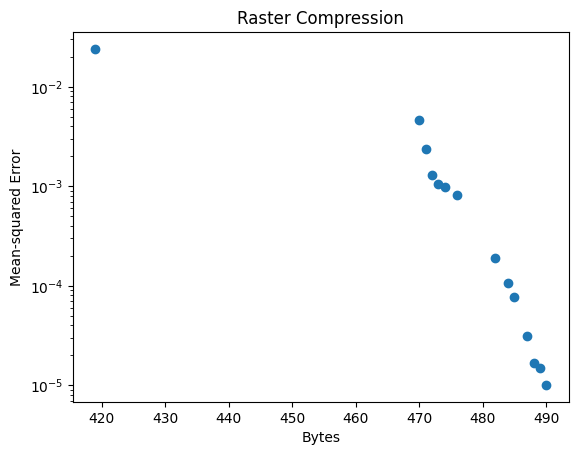

In [204]:

plt.scatter(bytes, losses)
plt.yscale('log')

plt.title("Raster Compression")
plt.xlabel("Bytes")
plt.ylabel("Mean-squared Error")
plt.show()

In [211]:
import csv
for i, beta in enumerate([1, 2, 4, 8, 16, 32, 64, 256]):
    with open(f"raster/{beta}.csv", "w") as f:
      writer = csv.writer(f)
      writer.writerows(list(zip(all_bytes[i], all_losses[i])))

In [210]:
all_bytes[-1]

[335.0,
 333.0,
 300.0,
 360.0,
 364.0,
 350.0,
 348.0,
 340.0,
 328.0,
 323.0,
 356.0,
 338.0,
 361.0,
 325.0,
 311.0,
 342.0,
 355.0,
 485.0,
 422.0,
 405.0,
 459.0,
 438.0,
 423.0,
 452.0,
 468.0,
 437.0,
 488.0,
 424.0,
 494.0,
 464.0,
 421.0,
 441.0,
 466.0,
 477.0,
 419.0,
 431.0,
 420.0,
 436.0,
 463.0,
 460.0,
 454.0,
 478.0,
 428.0,
 484.0,
 429.0,
 489.0,
 467.0,
 457.0,
 471.0,
 496.0,
 462.0,
 440.0,
 458.0,
 469.0,
 461.0,
 482.0,
 439.0,
 490.0,
 479.0,
 500.0,
 426.0,
 445.0,
 480.0,
 476.0,
 449.0,
 501.0,
 487.0,
 486.0,
 470.0,
 491.0,
 474.0,
 442.0,
 455.0,
 481.0,
 475.0,
 483.0,
 427.0,
 448.0,
 497.0,
 505.0,
 430.0,
 450.0,
 465.0,
 472.0,
 409.0,
 432.0,
 473.0,
 456.0,
 453.0,
 411.0,
 397.0,
 418.0,
 403.0,
 443.0,
 446.0,
 414.0,
 395.0,
 378.0,
 415.0,
 392.0,
 396.0,
 398.0,
 404.0,
 434.0,
 375.0,
 391.0,
 425.0,
 393.0,
 410.0,
 412.0,
 381.0,
 417.0,
 377.0,
 408.0,
 413.0,
 435.0,
 400.0,
 387.0,
 394.0,
 416.0,
 406.0,
 399.0,
 402.0,
 447.0,
 388.0,
